# TEAM-SASA     
### Initial POC and EDA for Rappler Website

In [4]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains

from time import sleep

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

## HELPER CLASS - WEBSCRAPING

In [5]:
DRIVER_PATH = 'C:\Program Files\chromedriver.exe'

class sunstarScraper:

    def __init__(self, search_url):
        self.urls = []
        self.search_url = search_url
        self.driver = webdriver.Chrome(DRIVER_PATH)

    def crawl(self):
        segments = ['bacolod', 'cagayan de oro', 'cebu', 'davao', 'dumaguete', 'iloilo', 'manila', 'pampanga', 'pangasinan',
                   'tacloban', 'zamboanga']
        for segment in segments:
            self.driver.get(self.search_url)
            search = self.driver.find_element(By.XPATH, '//*[@id="gsc-i-id1"]')
            search.send_keys(f'vaccine+{segment}')
            search.send_keys(Keys.RETURN)
            sleep(5)
            totalpages = self.get_total_pages()
            self.get_pages(totalpages)

    def get_driver(self):
        return self.driver
        
    def get_urls(self):
        return self.urls

    def get_urls_count(self):
        return len(self.urls)

    def get_total_pages(self):
        pages = self.driver.find_elements(By.CSS_SELECTOR, 'div.gsc-cursor-page')
        return len(pages)

    def add_urls(self, page):
        print(f'Start crawling article URLs for page {page}...')
        alinks = self.driver.find_elements(By.CSS_SELECTOR, 'a.gs-title')
        for a in alinks:
            link = a.get_attribute('href')
            if (link != None) and (link not in self.urls):
                self.urls.append(link)
        print('Done.')

    def get_pages(self, totalpages):
        print(f'Total number of pages to crawl: {totalpages}', end='\n\n')
        # Page 1
        self.add_urls(1)
        # Page 2 onwards
        self.driver.maximize_window()
        for p in range(1, totalpages):
            self.driver.execute_script('window.scrollBy(0, document.body.scrollHeight)', '') 
            pages = self.driver.find_elements(By.CSS_SELECTOR, 'div.gsc-cursor-page')
            pages[p].click()
            sleep(5)
            self.add_urls(p+1)

    def close_popups(self):
        try:
            self.driver.find_element(By.XPATH, '//*[@id="survicate-box"]/div/div/div[3]/div[2]/button').click()
        except:
            pass
        try:
            self.driver.find_element(By.XPATH, '//*[@id="onesignal-slidedown-cancel-button"]').click()
        except:
            pass
        try:
            # Close footer ads
            self.driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[16]//following::div/p/span').click()
        except:
            pass

    def scrape_data(self, url):
        ### PREPARE ARTICLE URL
        self.driver.get(url)
        sleep(15)

        ### PREPARE TITLE
        title = self.driver.find_element(By.CSS_SELECTOR, 'div.titleArticle')
        title = title.text
        print(f'\n[Title]\n{title}')

        ### PREPARE PUBLISHED DATE
        pubdate = self.driver.find_element(By.CSS_SELECTOR, 'div.articleDate')
        pubdate = pubdate.text
        print(f'\n[Date Pulished]\n{pubdate}')

        ### PREPARE AUTHOR NAME
        author = self.driver.find_element(By.CSS_SELECTOR, 'div.articleAuthor')
        author = author.text
        print(f'\n[Author]\n{author}')

        # Try closing popups before clicking 'SEE THE RESULTS' button
        sleep(2)
        self.close_popups()

        ### PREPARE ARTICLE CONTENT
        article = self.driver.find_element(By.CSS_SELECTOR, 'div.articleBody.articleContent.selectionShareable')
        article_content = article.text.replace('ADVERTISEMENT','').replace(' \n','').replace('\n ','').replace('\n\n','').replace('  ','') 
        print(f'\n[Content]\n{article_content}')

        ### PREPARE SENTIMENT RESULTS
        # Scroll to 'SEE THE RESULTS' button then simulate click to get sentiment results
        sleep(3)
        '''
        sentiment_classname = self.driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[16]/div[6]/div[4]/following::div').get_attribute('class')
        self.driver.execute_script(f'document.getElementsByClassName("{sentiment_classname}").scrollIntoView', '')
        
        # Automate click event to get sentiment results
        sentiment_index = 0
        for i in range(100):
            try:
                btn_sentiment = self.driver.find_element(By.XPATH, f'//*[@id="__next"]/div/div[16]/div[6]/div[4]/div[{i}]/div/div/span')
                if btn_sentiment.text.upper() == 'SEE THE RESULTS':
                    sleep(2)
                    self.close_popups()
                    action = ActionChains(self.driver)
                    action.move_to_element(btn_sentiment).click().perform()
                    # btn_sentiment.click()
                    sentiment_index = i
                    break
            except:
                pass

        sleep(3)
        # Clean some sentiment texts
        sentiment_results = self.driver.find_element(By.XPATH, f'//*[@id="__next"]/div/div[16]/div[6]/div[4]/div[{sentiment_index}]/div')
        sentiment_results = sentiment_results.text.replace('HOW OTHERS ARE FEELING', '').replace(' \n','').replace('\n ','').replace(' ARE ','-')
        # Convert each line of sentiment text to a list item
        sentiment_results = list(filter(None, sentiment_results.split('\n')))
        # Make a key-value pair of sentiment text and store it as dictionary object
        sentiment_results = {s.split('-')[1] : float(s.split('-')[0].split('%')[0])*.01 for s in sentiment_results}
        # Add a 0% value for sentiment key that does not have results in the current article and store as 'other sentiments'
        sentiment_keys = ['INSPIRED', 'HAPPY', 'AMUSED', 'NEUTRAL', 'ANNOYED', 'SAD', 'ANGRY', 'AFRAID']
        sentiment_others = {k : 0. for k in sentiment_keys if k not in sentiment_results}
        # Combine 'other sentiment dictionary' to the 'sentiment result dictionary' 
        sentiment_results = {**sentiment_results, **sentiment_others}
        print(f'\n[Sentiment]')
        print(sentiment_results)
        '''

        ### GET SENTIMENT RESULTS FROM ARTICLE
        return {'urls':url, 'titles':title, 'authors':author, 'published_dates':pubdate, 'articles_content':article_content}
    

# RUN WEB SCRAPING

In [6]:
KEYWORD = 'vaccine'
SEARCH_URL = f'https://www.sunstar.com.ph/search'

scraper = sunstarScraper(SEARCH_URL)
scraper.crawl()

dataset = []
print(f'\nTotal number of articles: {scraper.get_urls_count()}')
for i,url in enumerate(scraper.get_urls()):
    try:
        print(f'\n\n\n[{i+1}]{" ":>5}SCRAPING DATA  ~>  {url}')
        data = scraper.scrape_data(url)
        dataset.append(data)
    except Exception as e:
        print(f'SCRAPING ERROR: {e}')
        pass

scraper.get_driver().quit()

Total number of pages to crawl: 10

Start crawling article URLs for page 1...
Done.
Start crawling article URLs for page 2...
Done.
Start crawling article URLs for page 3...
Done.
Start crawling article URLs for page 4...
Done.
Start crawling article URLs for page 5...
Done.
Start crawling article URLs for page 6...
Done.
Start crawling article URLs for page 7...
Done.
Start crawling article URLs for page 8...
Done.
Start crawling article URLs for page 9...
Done.
Start crawling article URLs for page 10...
Done.
Total number of pages to crawl: 10

Start crawling article URLs for page 1...
Done.
Start crawling article URLs for page 2...
Done.
Start crawling article URLs for page 3...
Done.
Start crawling article URLs for page 4...
Done.
Start crawling article URLs for page 5...
Done.
Start crawling article URLs for page 6...
Done.
Start crawling article URLs for page 7...
Done.
Start crawling article URLs for page 8...
Done.
Start crawling article URLs for page 9...
Done.
Start crawling 




[3]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1881246/Bacolod/Local-News/Bacolod-forms-Covid-19-vaccination-council

[Title]
Bacolod forms Covid-19 vaccination council

[Date Pulished]
December 28, 2020

[Author]
MERLINDA A. PEDROSA

[Content]
BACOLOD City Mayor Evelio Leonardia has issued Executive Order (EO) No. 83, creating the Bacolod City Covid-19 vaccination (Covac) Council.Leonardia, who signed the EO on December 22, said on 9 November, the American drug company Pfizer reported that its new Covid-19 vaccine is more than 90 percent effective, and shortly after, another American company, Moderna, reported similar positive news regarding its own vaccine.He said there are also other Covid-19 vaccines in advanced stages of development in other countries that may, later on, be authorized for Philippine use by the Inter-Agency Task Force (IATF), including vaccines from the United Kingdom, Russia, India and China.On 9 November, vaccine czar and IATF Chief Implementer 




[6]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885053/Bacolod/Local-News/Bacolod-a-priority-in-vaccine-distribution-Galvez-reiterates

[Title]
Bacolod a priority in vaccine distribution, Galvez reiterates

[Date Pulished]
February 05, 2021

[Author]


[Content]
SECRETARY Carlito Galvez Jr., Malacañang’s vaccine czar, once again assured that Bacolod City is one of the priority cities of the national government in the vaccine distribution.“Don’t worry because Bacolod City is our priority after Cebu City and afterward, Iloilo City,” Galvez told the virtual special general assembly of the League of Cities of the Philippines (LCP), led by Bacolod City Mayor Evelio Leonardia as national president, Thursday, February 4.“All the highly urbanized cities (HUCs) are priorities; we will not leave anyone behind,” Galvez added.In November 2020, Galvez, who is also the chief implementer of the National Task Force Against Covid-19, had informed Leonardia via text message that Bacolo




[9]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1878204/Bacolod/Local-News/Bacolod-to-prioritize-funding-for-Covid-19-vaccine

[Title]
Bacolod to prioritize funding for Covid-19 vaccine

[Date Pulished]
November 27, 2020

[Author]
MERLINDA A. PEDROSA

[Content]
THE City Government of Bacolod will prioritize the funding for the coronavirus disease (Covid-19) vaccine once it is available.This was stressed by Mayor Evelio Leonardia after some companies already developed a clinical trial for the Covid-19 vaccine.Leonardia said he already submitted the annual budget for 2021 to the City Council, and the city is also ready to revert, re-align or augment the budget once the vaccine against the novel coronavirus is available.“We want to ensure that everybody will avail of the vaccine. We have this agreement with the city’s budget officer that vaccine spending will be the top priority. We are willing to revert, re-align and even augment the budget,” he said.The mayor said Presi




[13]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887713/Bacolod/Local-News/CLMMRH-healthcare-workers-to-be-vaccinated-with-Sinovac

[Title]
CLMMRH healthcare workers to be vaccinated with Sinovac

[Date Pulished]
March 04, 2021

[Author]
TERESA D. ELLERA

[Content]
THE 1,000 healthcare employees of Corazon Locsin Montelibano Memorial Regional Hospital (CLMMRH) will be the first to be vaccinated with Sinovac Covid-19 vaccines in Bacolod City and Negros Occidental.This was revealed Wednesday, March 3, 2021, by Dr. Jane Juanico, infections disease cluster head of the Department of Health-Western Visayas, as she confirmed that the first tranche of Sinovac vaccines that have arrived in the country will be distributed in different regions.She said they are not certain yet when and how many doses will be arriving in Western Visayas aside from CLMMRH.The Western Visayas Medical Center will also be given the vaccines because per the recommendation of the DOH national office, t




[16]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/bacolod
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[17]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884092/Bacolod/Local-News/More-businessmen-willing-to-purchase-Covid-19-vaccine-for-employees

[Title]
More businessmen willing to purchase Covid-19 vaccine for employees

[Date Pulished]
January 27, 2021

[Author]
MERLINDA A. PEDROSA

[Content]
MORE than five businessmen in Bacolod City already signified that they are willing to purchase vaccines against the coronavirus disease (Covid-19) for their employees.This was stressed by Councilor Renecito Novero, member of Bacolod Covid-19 Vaccination Council (Covac), Wednesday, January 27, 2021, after they held a meeting with businessmen at the Bacolod Government Center in December 2020.Novero said the businessmen signified their willingness to cooper




[20]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1883296/Bacolod/Local-News/Bacolod-to-join-region-wide-launching-of-measles-vaccination

[Title]
Bacolod to join region-wide launching of measles vaccination

[Date Pulished]
January 19, 2021

[Author]


[Content]
THE City of Bacolod, spearheaded by the City Health Office (CHO), is one with Western Visayas in the region-wide launching of Measles-Rubella Oral Polio Vaccine Supplemental Immunization Activity (MR OPV SIA) Campaign on February 1.The simultaneous kick-off activity will start at 9:30 a.m. in the respective city and provincial health offices, which will feature a ceremonial vaccination of a child to be done by a health worker.Dubbed "Chikiting Ligtas," the MR OPV SIA campaign, organized by the Department of Health-Western Visayas Center for Health Development, is slated until February 28.It aims to immunize 95 percent of all children aged 9 to 59 months with Measles-Rubella vaccines, and all children under 5 ye




[23]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882834/Bacolod/Local-News/Over-350K-Bacolenos-can-avail-2-doses-of-Covid-19-vaccines

[Title]
Over 350K Bacolenos can avail 2 doses of Covid-19 vaccines

[Date Pulished]
January 15, 2021

[Author]
MERLINDA A. PEDROSA

[Content]
About 355,000 Bacolenos can avail two doses of AstraZeneca vaccines against coronavirus disease (Covid-19).This was stressed by Bacolod City Vice Mayor El Cid Familiaran yesterday, January 14, after Mayor Evelio Leonardia already announced that Bacolod City is getting 650,000 doses of AstraZeneca to start off the city’s vaccine program against Covid-19.Familiaran said of 650,00 doses of AstraZeneca, 355,000 individuals in Bacolod can avail this vaccine which costs P610 for the two doses.“Those who are willing to avail the vaccine will get two doses of vaccines and it’s already enough for our constituents because those who are below 18-years-old are not beneficiaries of this vaccine. Some of the b




[26]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882903/Bacolod/Local-News/Leonardia-joins-ceremonial-signing-for-AstraZeneca-vaccine-donations

[Title]
Leonardia joins ceremonial signing for AstraZeneca vaccine donations

[Date Pulished]
January 15, 2021

[Author]


[Content]
BACOLOD City Mayor Evelio Leonardia was among the guests at the ceremonial signing Thursday, January 14, 2021, for the national government to accept donations from the private sector of AstraZeneca Covid-19 vaccines.The ceremonial signing was part of the second wave of private-sector efforts to help the national government secure more Covid vaccines for Filipinos.This private-sector drive dubbed, “A Dose of Hope,” was spearheaded by Presidential Adviser for Entrepreneurship Jose Ma. “Joey” Concepcion, vaccine czar Secretary Carlito Galvez of the National Task Force Against Covid-19, and AstraZeneca Philippines country president Lotis Ramin.President Rodrigo Duterte, who keynoted the ceremonial s




[28]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1888406/Bacolod/Local-News/648-frontliners-inoculated-in-Bacolod-City

[Title]
648 frontliners inoculated in Bacolod City

[Date Pulished]
March 10, 2021

[Author]
MERLINDA A. PEDROSA

[Content]
SOME 648 medical frontliners in Bacolod City were already vaccinated with the Sinovac vaccine against Covid-19.Emergency Operations Center (EOC) records showed as of March 9, a total of 164 medical frontliners from Corazon Locsin Montelibano Memorial Regional Hospital (CLMMRH) received their first dose of the Sinovac vaccine.A total of 358 medical frontliners from Riverside Medical Center were also vaccinated; Bacolod Adventist Medical Center (BAMC) with 1; The Doctors Hospital, Inc. (TDHI), 26; South Bacolod General Hospital (SBGH), 62; and EOC with 34 health workers.Vaccination was also held Wednesday for medical frontliners from two hospitals at Bacolod Queen of Mercy Hospital (BQMH) and Metro Bacolod Hospital, but the data wa




[32]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887807/Bacolod/Local-News/Over-3000-doses-of-Sinovac-to-arrive-in-Bacolod-March-5

[Title]
Over 3,000 doses of Sinovac to arrive in Bacolod March 5

[Date Pulished]
March 04, 2021

[Author]
MERLINDA A. PEDROSA

[Content]
MORE than 3,000 doses of Sinovac vaccines are expected to arrive in Bacolod City Friday, March 5, for the medical frontliners from Corazon Locsin Montelibano Memorial Regional Hospital (CLMMRH) and Riverside Medical Center.Dr. Chris Sorongon, deputy for medical data and analysis of Emergency Operations Center (EOC) Task Force, stressed this Thursday, March 4, after they held a meeting with the Department of Health (DOH)-Western Visayas and discussed the arrival of Sinovac vaccines intended for the medical frontliners assigned in Level-3 Covid-19 facilities in Western Visayas.Sorongon said that in Bacolod City, there are two Level-3 Covid-19 facilities, including the CLMMRH and Riverside Medical Center.A




[36]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882412/Bacolod/Local-News/City-mayors-to-meet-with-vaccine-czar-FDA-director

[Title]
City mayors to meet with vaccine czar, FDA director

[Date Pulished]
January 10, 2021

[Author]


[Content]
LEAGUE of Cities of the Philippines (LCP) national president Mayor Evelio Leonardia has called for a special online general assembly of city mayors on January 12, 2021, to meet with the vaccine czar of the National Task Force Against Covid-19 and the director-general of the Food and Drug Administration (FDA), with the availment of Covid-19 vaccines on top of the agenda.Vaccine czar Secretary Carlito Galvez has confirmed his attendance at the meeting and will present the national government’s roadmap to coordinate and assist LGUs in securing the vaccines.Galvez had earlier met with Leonardia and the LCP Committee on Vaccine Availment on December 29 to discuss the timeline of vaccine availability based on ongoing negotiations with 




[40]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885567/Bacolod/Local-News/DOH-Western-Visayas-lauds-Bacolods-efforts-in-measles-polio-immunization

[Title]
DOH-Western Visayas lauds Bacolod’s efforts in measles, polio immunization

[Date Pulished]
February 10, 2021

[Author]


[Content]
THE Department of Health (DOH) in Western Visayas commended Bacolod City’s immunization efforts under the “Chikiting Ligtas” region-wide campaign.In its evaluation report on Monday, February 8, 2021, DOH-Western Visayas, through Regional Coordinator Adrian Hort Ramos, lauded the Bacolod City Health Office (CHO) for observing the Covid-19 Referral and Triage protocols in conducting the vaccination activities.“Congratulations for the efforts! I was impressed!” said Ramos.“Chikiting Ligtas,” which runs from February 1 to 28, is a health campaign for the Measles-Rubella and Oral Polio Vaccine Supplemental Immunization of the DOH.According to Ramos, the practice of providing health declara




[43]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885305/Bacolod/Business/BPO-firm-to-provide-free-Covid-19-vaccines-to-workers

[Title]
BPO firm to provide free Covid-19 vaccines to workers

[Date Pulished]
February 08, 2021

[Author]
ERWIN P. NICAVERA

[Content]
A TOP official of Transcom said the business process outsourcing (BPO) firm will provide free vaccines against coronavirus disease (Covid-19) to its employees in the country including Bacolod City once these are available.Transcom Worldwide Chief Executive Officer for Global English Region Mark Lyndsell, in a statement Monday, February 8, 2021, said the procurement of Covid-19 vaccines for its employees is part of the company’s intensified fight against the virus.For Bacolod City alone, one of the largest sites of the company, Transcom has to provide free vaccines to about 2,900 employees.Emergency Operation Center (EOC) Task Force Deputy for Medical and Data Analysis Dr. Chris Sorongon earlier said the compa




[46]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1872073/Bacolod/Local-News/Businessman-shot-dead-in-Bacolod

[Title]
Businessman shot dead in Bacolod

[Date Pulished]
October 01, 2020

[Author]
MERLINDA A. PEDROSA

[Content]
A BUSINESSMAN was shot to death by two unidentified assailants on a motorcycle in front of his store on Galo-Ramos Streets, Barangay 19, Bacolod City Wednesday evening, September 30, 2020.Police identified the fatality as Raymart Idino, 27, of Barangay 19.Police Major Charles Gever, chief of Police Station 4, said Thursday the victim, who engaged in a chicken business, was sitting in front of his store along with his live-in partner when two unidentified suspects approached him and fired at him six times using an unidentified firearm and fled.The victim sustained gunshot wounds on his stomach. He was brought to the Corazon Locsin Montelibano Memorial Regional Hospital, but he did not survive.Gever added they are looking into personal grudges or bu




[52]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1888195/Bacolod/Local-News/Negros-Occidental-requests-6000-vaccines-for-medical-frontliners

[Title]
Negros Occidental requests 6,000 vaccines for medical frontliners

[Date Pulished]
March 08, 2021

[Author]
TERESA D. ELLERA

[Content]
THE provincial government of Negros Occidental is requesting 5,000 to 6,000 doses of Covid-19 vaccines from the first two batches that arrived in the country.Governor Eugenio Jose Lacson said they have made the request through Senator Bong Go. Former Third District Representative and Provincial Consultant Alfredo Benitez, who is in close contact with vaccine czar Carlito Galvez, is also doing his best to bring a share of AstraZeneca vaccine to the province."We hope to have the vaccines maybe next week or later," Lacson said.He said the province has about 8,000 medical frontliners, including those from the hospitals run and managed by the provincial government and of some localities."We ca




[56]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886067/Bacolod/Local-News/Mayors-urged-to-help-convince-people-to-get-vaccinated

[Title]
Mayors urged to help convince people to get vaccinated

[Date Pulished]
February 16, 2021

[Author]
TERESA D. ELLERA

[Content]
NEGROS Occidental Governor Eugenio Jose Lacson urged the mayors to help convince their constituents to brace for the coming Covid-19 vaccination."Don't think of buying the vaccines because the National Government will take care of it. The National Government has assured that it is their duty to vaccinate everyone," Lacson said when asked about the worries of some municipal mayors that they do not have available funds to purchase the vaccine.Lacson said the mayors should encourage and convince their constituents to register for the vaccination and that educating them that the vaccine is safe is important.Lacson made the reaction as reports have it that some people, even frontliners, are adamant of the vacci




[59]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1883793/Bacolod/Local-News/Bacolod-validates-identified-vaccination-centers

[Title]
Bacolod validates identified vaccination centers

[Date Pulished]
January 25, 2021

[Author]
MERLINDA A. PEDROSA

[Content]
THE City Government of Bacolod is now validating the proposed vaccination centers in the city.This was stressed by Councilor Renecito Novero, member of Bacolod Covid-19 vaccination (Covac) Council, Sunday, January 24, 2021, after they inspected some of the barangay health centers in Bacolod.Novero said they earlier submitted 22 proposed vaccination centers to Mayor Evelio Leonardia and they are still subject to validation.“We already inspected some of the health centers and we found some technicalities on it,” he said.He added they are still finalizing their report to be submitted to Leonardia so the city will be prepared for the vaccination program against Covid-19.Covac Council earlier submitted the lists of propo




[62]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887383/Bacolod/Local-News/Negros-Occidental-Capitol-braces-for-Sinovac-vaccine-arrival

[Title]
Negros Occidental Capitol braces for Sinovac vaccine arrival

[Date Pulished]
February 28, 2021

[Author]
TERESA D. ELLERA

[Content]
THE provincial government of Negros Occidental is bracing for the arrival of C-19 Sinovac vaccines this week.Lawyer Rayfrando Diaz, provincial administrator, made the statement after they were informed by Provincial Consultant Alfredo Benitez that the province will have an allocation of Sinovac vaccines."As to how much or how many doses the province will have, we have yet to know it this week," Diaz said.Diaz also said Benitez is preparing himself to be vaccinated publicly with Sinovac vaccines.Benitez's move is to build confidence in the vaccine."We are ready and hoping for the arrival of the Sinovac vaccines," Diaz said.He also said they are encouraging travelers to get the Sinovac vaccines f


[Title]
Tricycle driver shot dead by riding-in-tandem

[Date Pulished]
January 06, 2021

[Author]
MERLINDA A. PEDROSA

[Content]
A TRICYCLE driver was shot to death by two unidentified assailants on a motorcycle on Circumferential Road, Barangay Pahanocoy, Bacolod City Wednesday morning, January 6, 2021.Police identified the fatality as Noel Peraren, 54, of Purok Bantud, Barangay Pahanocoy.Police Lieutenant Colonel Ariel Pico, spokesperson of Bacolod City Police Office, said the victim was driving his motorcycle around 7:30 a.m when he was followed by the assailants on Circumferential Road.When they reached NNJ Store, the suspects fired at him and fled.The victim sustained multiple wounds and died on the spot.In 2016, Peraren was arrested for illegal possession of illegal firearms, but he was also released after he availed of the probation.Police Station 8 has been conducting a thorough investigation to determine the motive and the identity of the suspects.



[67]     SCRAPING DATA  




[70]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887605/Bacolod/Local-News/Negros-Occidental-cops-to-receive-Sinovac-vaccines

[Title]
Negros Occidental cops to receive Sinovac vaccines

[Date Pulished]
March 02, 2021

[Author]
TERESA D. ELLERA

[Content]
THE Negros Occidental Police Provincial Office (Nocppo) will also receive Sinovac Covid-19 vaccines, which are part of the initial 600,000 doses donated by the People's Republic of China to the Philippine government.Police Lieutenant Abegael Donasco, spokesperson for Nocppo, said the Sinovac vaccines will originate directly from the Philippine National Police (PNP) headquarters in Camp Crame, Metro Manila.Once the vaccines allocated for Nocppo arrive, it is expected that they will be given to the provincial police's medical personnel and frontliners.After which, the rest of the vaccines will be given to the remaining Nocppo personnel.But Donasco pointed out that although they have received information that they will 




[75]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887804/Bacolod/Local-News/Negros-Occidental-activates-vaccination-task-force

[Title]
Negros Occidental activates vaccination task force

[Date Pulished]
March 04, 2021

[Author]


[Content]
NEGROS Occidental Governor Eugenio Jose Lacson has called for a meeting for the activation of the Covid-19 Vaccination Task Force, which will lead the province to systematically and efficiently utilize the vaccination strategy in combating the virus.The meeting, held at the Provincial Capitol in Bacolod City Thursday, March 4, was attended by Board Members Ryan Gamboa and Araceli Somosa, Provincial Administrator Rayfrando Diaz II, Provincial Health Officer Dr. Ernell Tumimbang, chiefs of hospitals, Philippine National Police, concerned Capitol departments and offices, and national government agencies.Lacson said that for almost a year of battle against the virus, the Provincial Government is proud of its accomplishments.He lauded al




[78]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1771067/Bacolod/Local-News/48000-dogs-vaccinated-in-Bacolod-City

[Title]
48,000 dogs vaccinated in Bacolod City

[Date Pulished]
October 26, 2018

[Author]


[Content]
THE City Veterinarian Office (CVO) has vaccinated 48,000 dogs in the city covering all 61 barangays.City Veterinarian Agueda Trinidad dela Torre said they have already wrapped up the vaccination program but they still have enough vaccine left to cater to 10,000 more dogs.She said the walk-in clients who are requesting for vaccination can still be accommodated at the CVO downtown area at P50 per dog.Dela Torre said she is grateful of the public’s cooperation but noted that there are still several residents and pet owners who are unmindful of the city’s anti-rabies program.The city veterinarian said their next activity will be the impounding of stray dogs and their adoption.She said that 50 dogs are in the city's impounding facility and are up for adoption 




[82]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882593/Davao/Local-News/Online-registration-for-Covid-19-vaccine-eyed

[Title]
Online registration for Covid-19 vaccine eyed

[Date Pulished]
January 12, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
SINCE not all Dabawenyos are willing to get the Covid-19 vaccine, Davao City Mayor Sara Duterte-Carpio said the local government will set up an online registration site to "forecast" the number of vaccine doses the city will initially need.Duterte-Carpio said on Monday, January 11, that the online registration will be intended for those who are willing to get the Covid-19 vaccine.This is to shy away from the face-to-face registration, which might result in further Covid-19 transmission.The registration, she said, will serve as a "forecast" for the city to determine the number of people who would want to get the vaccine.The mayor recently said that the City Government will not be placing a budget limit on the procuremen




[87]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/ampArticle/1888406
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[88]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1787262/Bacolod/Local-News/22-Bacolod-villages-with-suspected-measles-cases

[Title]
22 Bacolod villages with suspected measles cases

[Date Pulished]
February 12, 2019

[Author]
MERLINDA A. PEDROSA - TERESA D. ELLERA

[Content]
AT LEAST 22 barangays in Bacolod City have suspected measles cases this year, an official of the City Health Office (CHO) said yesterday.City Health Officer Ma. Carmela Gensoli said from January 1 to February 11, Bacolod has a total of 53 suspected measles-rubella cases, affecting three-month to 45-year-old patients.No deaths were recorded.Of the 61 barangays, Barangay Taculing has the highest number of suspected cases with seven.Others are Barangays Mansilinga




[91]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1796452/Bacolod/Business/NegOcc-lacks-anti-rabies-vaccine

[Title]
NegOcc lacks anti-rabies vaccine

[Date Pulished]
March 12, 2019

[Author]


[Content]
IN THE bid to address the province's need for additional anti-rabies vaccine, the Provincial Veterinary Office (PVO) has been urging local government units (LGUs) to allocate funds for its purchase.Dr. Ryan Janoya, head of Animal Health and Meat Inspection Services Division of the PVO, said the Bureau of Animal Industry can only provide 500 vials of rabies vaccine for the province this year.Janoya said that though the Provincial Government also purchased additional vaccines, the available supply is not yet enough to cover the entire dog population in Negros Occidental.“Negros Occidental lacks vaccines for dogs, thus, LGUs should not only rely on the Provincial Government,” he said. “We are doing visits with mayors and other local officials encouraging them to allocate b




[95]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1750899/Bacolod/Local-News/DOH-launches-school-based-health-services

[Title]
DOH launches school-based health services

[Date Pulished]
July 03, 2018

[Author]


[Content]
THE Department of Health (DOH) in Western Visayas is urging the parents to avail the free immunization program for their children in public schools.The DOH in partnership with the Department of Education (DepEd) and the Department of the Interior Local Government (DILG) yesterday, July 2, launched the Integrated School-based Health Services at the Rodolfo A. Medel Sr. Elementary School in Barangay Tangub.Dr. Renilyn Reyes, DOH-Western Visayas Family Health and Nutrition Cluster head, said the activity aims to strengthen the advocacy on the implementation of school-based health services such as immunization, deworming and weekly iron and folic acid (WIFA).Under the school-based immunization, all Grade 1 pupils in public schools will be vaccinated with 




[99]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1883384/Cagayan-De-Oro/Local-News/Public-to-still-observe-health-protocols-after-vaccination

[Title]
Public to still observe health protocols after vaccination

[Date Pulished]
January 20, 2021

[Author]
JO ANN SABLAD

[Content]
HEALTH officials in Cagayan de Oro City have reiterated the need to practice the minimum public health standards even after vaccination.City Health Office Epidemiologist Dr. Joselito Retuya said during the city's daily press conference on Wednesday, January 20, 2021 that until the city achieves the herd immunity, the public should continue to observe the minimum health protocols, such as wearing of face masks and face shields and social distancing.By herd immunity, Retuya said, it means that about 60 to 85 percent of the country's population is vaccinated so they can develop antibodies against the novel coronavirus.Northern Mindanao Medical Center (NMMC) liaison officer Dr. Bernard Rocha, for hi




[104]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884197/Cagayan-De-Oro/Local-News/Oro-to-set-up-online-registration-system-for-vaccine-rollout

[Title]
Oro to set up online registration system for vaccine rollout

[Date Pulished]
January 28, 2021

[Author]
JO ANN SABLAD

[Content]
CAGAYAN de Oro will be setting up an online registration system for the city's residents in preparation for the Covid-19 vaccination rollout, Acting City Health Officer Dr. Lorraine Nery said Thursday, January 28, 2021.Nery said long-time residents of the city, who came from other areas but wanted to be vaccinated in Cagayan de Oro, may also be registered once the city finishes setting up the registration system."Ang katong individual kung dugay na gyud siya nag reside, make sure lang pud nga during the time nga magpa-roll out ta sa atong online registration, makaparehistro gyud siya kay in the end, mao man to ang basihan, master list nato sa kung kinsa ang eligible nato nga pwede mabakunah




[110]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884084/Cagayan-De-Oro/Local-News/Online-survey-on-Covid-19-vaccines-eyed

[Title]
Online survey on Covid-19 vaccines eyed

[Date Pulished]
January 27, 2021

[Author]
JO ANN SABLAD

[Content]
IN A bid to identify the barriers in the Covid-19 vaccination rollout, the City Government is considering the conduct of an online survey on the public's opinion on the vaccines and the vaccination program."Kung pananglitan moabot kanang atong vaccine, andam na ba ang atong katawhan sa pagdawat sa maong vaccine?" City Health Office epidemiologist Dr. Joselito Retuya said.Retuya said that through the online survey, the City Health Office will be able to get data on the public's vaccine preferences, as well as whether they are willing to be vaccinated or not through their comments in social media.He added that the online survey may be done on Facebook by asking questions such as "at this point of time, do you want yourself to be vacc




[115]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1878153/Cagayan-De-Oro/Local-News/City-health-DOH-IATF-will-decide-on-priority-areas-for-vaccine

[Title]
City health: DOH, IATF will decide on priority areas for vaccine

[Date Pulished]
November 26, 2020

[Author]
JO ANN SABLAD

[Content]
ACTING City Health Officer Dr. Lorraine Nery on Thursday, November 26, 2020, said while it is expected that everybody will be vaccinated, the Department of Health and the Inter-Agency Task Force (IATF) will still have to identify the priority areas to distribute the vaccines."Before ipanghatag kanang mga vaccine, the Department of Health and the IATF will have to identify priority areas kung asa ni sila ipang-inahon," Nery said.She added that among the areas that the health department and the IATF consider as priority are those with high number of Covid-19 cases."Tibuok Pilipinas will have their own share also of the vaccine, and it will really depend also the number of population an




[119]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1881075/Cagayan-De-Oro/Sports/Vaccine-tips-inspires-Mindanao-coaches-to-organize-LMYBL-youth-hoopfest

[Title]
'Vaccine tips' inspires Mindanao coaches to organize LMYBL youth hoopfest

[Date Pulished]
December 24, 2020

[Author]
LYNDE SALGADOS

[Content]
THE best is yet to come for basketball sports in Mindanao.Undaunted by the devastating effect of pandemic that crippled majority of the sporting activities around the world, at least three dedicated coaches have taken the cudgel to organize the ambitious Liga Mindanao Youth Basketball League (LMYBL) slated to open doors in Year 2021.All of them--Van Halen Parmis, Raymon Mercader and Reynold Dangcal--were optimistic the vaccine for Covid-19 virus will be administered right in time of the Mindanao-wide tourney's opening early next year."We're now actively in the planning stage though we can't start the competition without the vaccine first for the deadly disease. But we'




[124]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885136/Cagayan-De-Oro/Local-News/LGUs-not-allowed-to-buy-own-Covid-19-vaccines

[Title]
LGUs 'not allowed' to buy own Covid-19 vaccines

[Date Pulished]
February 06, 2021

[Author]
JO ANN SABLAD

[Content]
PRESIDENTIAL Communications Operations Office (PCOO) Secretary Martin Andanar said local government units (LGUs) should not purchase coronavirus disease (Covid-19) vaccines directly from the pharmaceutical company as LGUs are in a tripartite agreement with the National Government and the company."Dili pwede ang LGU nga modiretso, kailangan naay approval ang National Government," Andanar said."The local government must always accede to the national government. Meaning the national government will be the ones to purchase kay government to government man ni," he added.Several LGUs have recently announced that they are setting aside funds that will be used to purchase Covid-19 vaccines from the pharmaceutical company of 




[128]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/SUPERBALITA-CDO
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[129]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882913/Cagayan-De-Oro/Local-News/Data-on-target-recipients-preparedness-crucial-to-vaccination-rollout

[Title]
Data on target recipients, preparedness 'crucial' to vaccination rollout

[Date Pulished]
January 15, 2021

[Author]
JO ANN SABLAD

[Content]
CAGAYAN de Oro City Mayor Oscar Moreno said the data from the City Social Welfare and Development and City Health Office will have to be revalidated to strengthen the preparedness of the city's vaccination program."Ang ako karon, ang gapakita gyud nga problema is more of our preparedness. Are we prepared?" Moreno said."Dili pa ko kombinsido kaayo mao nang ang data sa atong Social Welfare ug sa atong City Health will have to be revalidat




[134]     SCRAPING DATA  ~>  http://www.sunstar.com.ph/cagayan-de-oro/lake-lanao-watershed%20%E2%80%98grossly-mismanaged%E2%80%99
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[135]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886142/Cagayan-De-Oro/Local-News/Cagayan-de-Oro-City-Health-Office-identifies-15-vaccination-sites

[Title]
City Health identifies 15 vaccination sites in Oro

[Date Pulished]
February 16, 2021

[Author]
JO ANN SABLAD

[Content]
CITY Health Office identified 15 strategic locations as vaccination sites in Cagayan de Oro, health officer Dr. Lorraine Nery said on Tuesday, February 16, 2021.Among the sites are Barangays Kasuwagan, Carmen, Iponan, Canitoan and Bulua in west district; Barangays Bugo, Cugman, Lapasan, Gusa and Tablon in east district; Barangays Camaman-an, Macasandig, and Macabalan in central district; and Barangays Ma




[141]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1888250/Cagayan-De-Oro/Local-News/City-Health-Use-of-gloves-PPEs-by-vaccinators-is-impractical

[Title]
City Health: Use of gloves, PPEs by vaccinators is impractical

[Date Pulished]
March 09, 2021

[Author]
JO ANN SABLAD

[Content]
THE use of gloves and personal protective equipment (PPEs) by vaccinators during the Covid-19 vaccination procedure is impractical and costly, Acting City Health Officer Dr. Lorraine Nery said on Tuesday, March 9.This, after several people who witnessed the vaccination procedure through photos and videos expressed concern after seeing the vaccinators giving the first dose of the Sinovac vaccines to the healthcare workers without using PPEs or gloves.According to Nery, there was no advice from the Department of Health (DOH) that wearing of gloves or PPEs during the vaccination process is necessary."Kung mag gloves ka, every person nga i-vaccinate nimo, mag change ka og gloves. So it's not so




[147]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/SPORTS-CAGAYAN-DE-ORO-
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[148]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1861243/Cagayan-De-Oro/Local-News/48-firms-in-Northern-Mindanao-permanently-close

[Title]
48 firms in Northern Mindanao permanently close

[Date Pulished]
June 24, 2020

[Author]
ALWEN SALIRING

[Content]
FORTY-EIGHT firms in Northern Mindanao have permanently shut down their operations due to the effects of the coronavirus disease (Covid-19) pandemic as of June 17, the National Economic Development Authority (Neda)-Northern Mindanao reported Tuesday, June 23.Neda-Northern Mindanao Assistant Director Leonila Cajarte said the closure of these business establishments affected 813 workers.On the other hand, 15 establishments have temporarily closed, affecting 424 employees, while 1




[155]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882141/Cagayan-De-Oro/Local-News/Cagayan-de-Oro-registers-21-new-Covid-19-cases-4-recoveries

[Title]
Cagayan de Oro registers 21 new Covid-19 cases; 4 recoveries

[Date Pulished]
January 07, 2021

[Author]
JO ANN SABLAD

[Content]
TWENTY-ONE residents of Cagayan de Oro have tested positive for the novel coronavirus, bringing the total number of confirmed cases in the city to 2,929.Acting City Health Officer Dr. Lorraine Nery said eight of the 21 new local cases are close contacts of previously confirmed cases and 13 are local index cases.Of the 2,929 total Covid-19 cases in the city, 404 are under the returning overseas Filipino workers/locally stranded individuals (ROFs/LSIs) category and 2,525 cases are local transmissions.According to Nery, the 2,525 local cases consist of 182 persons deprived of liberty, 1,282 local index cases, and 1,061 local cases with link.Cagayan de Oro has recorded 294 active cases, 91 of wh




[162]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1508550/Cagayan-De-Oro/Local-News/DOH-No-shortage-ofanti-rabies-vaccine-in-Northern-Mindanao

[Title]
DOH: No shortage of anti-rabies vaccine in Northern Mindanao

[Date Pulished]
April 19, 2018

[Author]
PAMELA JAY F. ORIAS

[Content]
AN OFFICIAL of the Department of Health (DOH) in Northern Mindanao Region said there is no shortage of the anti-rabies vaccine for humans in the region, pointing out they have enough allocation of the vaccine to every animal bites center across the region.Dr. Ellenietta Gamolo, DOH-Northern Mindanao medial officer, however, said that Cagayan de Oro City's health office might be experiencing the shortage because of the high incidence of dog bites.READ: Cagayan de Oro running out of anti-rabies vaccines (http://www.sunstar.com.ph/article/1505041/Cagayan-De-Oro/Local-News/Cagayan-de-Oro-running-out-of-anti-rabies-vaccines)Gamolo also clarified that local health centers should have the capaci




[168]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884842/Cagayan-De-Oro/Local-News/Cagayan-de-Oro-logs-20-new-Covid-19-cases-38-recoveries

[Title]
Cagayan de Oro logs 20 new Covid-19 cases, 38 recoveries

[Date Pulished]
February 04, 2021

[Author]
JO ANN SABLAD

[Content]
TWENTY residents of Cagayan de Oro have tested positive for the novel coronavirus, one of whom is a locally stranded individual (LSI), one is a returning overseas Filipino worker (ROF) and 18 are local transmissions.This brought the total number of confirmed Covid-19 cases in the city to 3,352.Acting City Health Officer Dr. Lorraine Nery said of the 18 new local cases, six are close contacts of previously confirmed cases, 10 are local index cases and two are local authorized persons outside residence (Apors).Of the 3,352 total Covid-19 cases in the city, 421 are under the returning overseas Filipino workers/locally stranded individuals (ROFs/LSIs) category and 2,931 cases are local transmissions.Ac




[173]     SCRAPING DATA  ~>  http://www.sunstar.com.ph/cagayan-de-oro/trabahante-nalubong-nga-buhi
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[174]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1879407/Cagayan-De-Oro/Local-News/11-residents-in-Cagayan-de-Oro-contract-Covid-19

[Title]
11 residents in Cagayan de Oro contract Covid-19

[Date Pulished]
December 08, 2020

[Author]
JO ANN SABLAD

[Content]
THE Cagayan de Oro Health Office has logged 11 new coronavirus disease (Covid-19) cases, one of whom is a locally stranded individual (LSI) and 10 are local transmissions, bringing the total number of confirmed coronavirus infections in the city to 2,495.Acting City Health Officer Dr. Lorraine Nery said of the 10 new local cases, two are close contacts of previously confirmed cases.Of the 2,495 total Covid-19 cases in the city, 391 are under the returni

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[182]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885527/Cagayan-De-Oro/Local-News/Cagayan-de-Oro-logs-29-new-Covid-19-cases-19-recoveries

[Title]
Cagayan de Oro logs 29 new Covid-19 cases, 19 recoveries

[Date Pulished]
February 10, 2021

[Author]
JO ANN SABLAD

[Content]
TWENTY-NINE residents of Cagayan de Oro have tested positive for the novel coronavirus, all of which are local transmissions, bringing the total number of confirmed Covid-19 cases in the city to 3,511.Acting City Health Officer Dr. Lorraine Nery said of the 29 new local cases, nine are close contacts of previously confirmed cases, 19 are local index cases and one local authorized person outside residence (Apor).Of the 3,511 total Covid-19 cases in the city, 422 are under the returning overseas Filipino workers/locally stranded individuals




[188]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/cagayan-de-oro/misor-escapee-recaptured
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[189]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887013/Cagayan-De-Oro/Local-News/10-new-Covid-19-cases-in-Cagayan-de-Oro

[Title]
10 new Covid-19 cases in Cagayan de Oro

[Date Pulished]
February 25, 2021

[Author]
JO ANN SABLAD

[Content]
THE City Health Office of Cagayan de Oro reported Wednesday, February 24, 10 new coronavirus disease (Covid-19) cases, all of which are local transmissions, health officer Dr. Lorraine Nery said.This brought the total number of confirmed Covid-19 infections in the city to 3,746.Nery said of the 10 new local cases, three are close contacts of previously confirmed cases, six are local index cases, and one local authorized person outside residence (Apor).Of the 3,746 total Cov




[192]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1880214/Cebu/Local-News/Cebu-City-to-be-prioritized-in-Covid-19-vaccine-rollout

[Title]
Cebu City to be prioritized in Covid-19 vaccine rollout

[Date Pulished]
December 16, 2020

[Author]


[Content]
RESIDENTS of Cebu City will be given priority by the national government when the Covid-19 vaccine becomes available next year.Cebu City Mayor Edgardo Labella made the announcement after speaking with Secretary Carlito Galvez, the chief implementer of the Inter-Agency Task Force (IATF) for the Management of Emerging Infectious Diseases.“The most important thing he told me was that Cebu City will be a priority in the distribution of the vaccine. I had goosebumps and I was very happy that among the local governments, Secretary Galvez considers Cebu City as a priority,” Labella, speaking in Cebuano, told reporters on Tuesday, Dec. 15, 2020.Labella said not all Cebuanos will be given the vaccine once it is rolled out next yea




[195]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1880725/Cebu/Local-News/Go-Priority-areas-for-acquisition-of-Covid-vaccine-to-include-Cebu

[Title]
Go: Priority areas for acquisition of Covid vaccine to include Cebu

[Date Pulished]
December 20, 2020

[Author]


[Content]
CEBU will be one of the areas that will be prioritized for the acquisition of the coronavirus vaccine, according to Sen. Christopher “Bong” Go, chairman of the Senate Committee on Health.He made the announcement while visiting fire survivors in Sitio Superior, Barangay Looc in Mandaue City on Thursday, Dec. 17, 2020.Cebu will include the cities of Cebu, Mandaue, Lapu-Lapu and the whole Cebu Province.Go said President Rodrigo Duterte assured that the vaccine will be available to indigent Filipinos for free.He said the government will also prioritize frontliners and vulnerable sectors like senior citizens.Meanwhile, the senator said he will not change his stand against the in-person classroom setup un




[197]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882281/Cebu/Local-News/Medical-frontliners-police-senior-poorest-first-to-get-vaccine

[Title]
Medical frontliners, police, senior, poorest first to get vaccine

[Date Pulished]
January 08, 2021

[Author]


[Content]
MEDICAL frontliners will be the first to be vaccinated once the Cebu City Government has a Covid-19 vaccine.Cebu City Mayor Edgardo Labella, in a press conference on Jan. 8, 2021, said the medical frontliners are the most exposed to the suspected and confirmed Covid-19 patients, so there is a need to prioritize them.Labella said next in line are the police and military forces.Labella said law enforcement groups have been deployed to man the checkpoints around the city since the city was placed under enhanced community quarantine (ECQ) in March 2020.Other sectors to be prioritized in the vaccination program are the senior citizens and those considered the “poorest of the poor.”Labella targets to have 70 per




[201]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882738/Cebu/Local-News/Labella-says-public-may-choose-vaccine-brand

[Title]
Labella says residents may choose vaccine brand

[Date Pulished]
January 14, 2021

[Author]


[Content]
CEBU City Mayor Edgardo Labella on Wednesday, January 13, 2021, said he will not force residents to take the Sinovac vaccine that will be provided by the national government.He said the City Government plans to purchase the vaccines developed by Pfizer-BioNTech and Moderna. Residents who prefer these brands over the Sinovac vaccine may wait until these become available in the second half of 2021.Vaccine czar Carlito Galvez Jr. earlier said Cebu City and Davao City, aside from Metro Manila, may be able to purchase these vaccines because of the presence of cold storage facilities.Labella said a Swiss company in Cebu City has a facility that can store the Pfizer-BioNTech vaccine, which requires storage temperature of between -60 and -80 degrees




[204]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885341/Cebu/Local-News/Nearly-2500-VSMMC-workers-willing-to-get-Covid-vaccine

[Title]
Nearly 2,500 VSMMC workers willing to get Covid vaccine

[Date Pulished]
February 08, 2021

[Author]


[Content]
ALMOST 2,500 healthcare workers at the Vicente Sotto Memorial Medical Center (VSMMC) are willing to be vaccinated against coronavirus disease 2019 (Covid-19), Department of Health Central Visayas (DOH 7) spokesperson Mary Jean Loreche announced Monday, Feb. 8, 2021.She said the VSMMC, a tertiary government hospital in Cebu City, listed 2,987 healthcare workers as priority recipients of the vaccine.Of this number, 2,480 have agreed to be inoculated.Loreche did not cite any reason for the refusal of the remaining 507 medical frontliners.The Pfizer-BioNTech vaccines are expected to arrive in the country either on Feb. 15 or in the last week of February, Loreche said.She did not specify the number of doses allocated for Cebu C




[206]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887960/Cebu/Local-News/Private-hospitals-next

[Title]
Private hospitals next

[Date Pulished]
March 06, 2021

[Author]
WENILYN SABALO

[Content]
MEDICAL workers employed in level 3 private hospitals in Cebu City will be among the next priority for the Covid-19 inoculations, a health official said on Friday, March 5, 2021.Department of Health (DOH) 7 spokesperson and chief pathologist Mary Jean Loreche said healthcare workers in Chong Hua Hospital, Cebu Doctors’ University Hospital,University of Cebu Medical Center (UCMed), Perpetual Succour Hospital, Visayas Community Medical Center, and Southwestern University Medical Center will be included in the next vaccinations as 17,480 additional doses of the Sinovac Covid-19 vaccines arrived in Cebu on Friday.Aside from these Cebu City hospitals, the vaccines will be distributed to the level 3 private and government-run hospitals in the provinces of Cebu, Bohol, Negros Orient




[209]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882893/Cebu/Local-News/EXPLAINER-Procuring-Covid-vaccine-is-primarily-national-governments-job-LGUs-may-watch-and-wait-as-Cebu-province-does-or-take-pro-active-role-For-sure-no-consent-no-inoculation

[Title]
EXPLAINER: Procuring Covid vaccine is primarily national government's job. LGUs may watch and wait, as Cebu province does, or take 'pro-active role.' For sure: no consent, no inoculation.

[Date Pulished]
January 15, 2021

[Author]
PACHICO A. SEARES

[Content]
AT A GLANCE, from what Friday's Capitol meeting and news sources told us:[1] Local governments may buy vaccines of their choice but the national government must be a party to the sale, per policy accord among the world's vaccine manufacturers.[2] While Cebu City and Mandaue City have appropriated money for their own vaccines, not one Cebu LGU has yet negotiated with and signed a deal with any supplier.[3] No person, including health workers and other frontli




[211]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1883884/Cebu/Local-News/DOH-Central-Visayas-works-on-having-Covid-19-vaccine-freezers

[Title]
DOH-Central Visayas works on having Covid-19 vaccine freezers

[Date Pulished]
January 25, 2021

[Author]


[Content]
THE Department of Health Central Visayas (DOH 7) is working on acquiring appropriate bio-freezers for the incoming Covid-19 vaccines.Dr. Mary Jean Loreche, DOH 7 spokesperson, said there is no specific number of doses or a specific vaccine brand to be used in Cebu yet, but DOH 7’s preparations are ongoing. She assured the public that they will hasten this.Loreche said there is a need to assess the region’s storage capabilities and they are doing inventory on the number of freezers that have a 220-degree capacity and those ultra-low freezers that have -70 degrees.“We will try to act fast on this so that when the vaccines are ready, we have a place for them,” she said.She said there are institutions in the region




[213]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886745/Cebu/Media&

[Title]
Seares: Criticisms on news report of OFWs vaccinated abroad but tested positive in Cebu. Did media get the story wrong?

[Date Pulished]
February 22, 2021

[Author]
PACHICO A. SEARES

[Content]
"Why post a headline saying 'OFW from UAE tested positive even if ... vaccinated?' The vaccine was never meant to prevent you from getting the virus; it prevents you from dying if you do get the virus. Why can't the media get that? Are you trying to scare people or make a sale?" -- From a Facebook post, February 20, 2021"I read in a newspaper a few days ago this story that said 'Two vaccinated OFWs get Covid.' The story is patently wrong because it gives the impression that anti-Covid vaccines no longer allow a person to get the disease." -- From a newspaper column, February 22, 2021THE Facebook comment clearly complained about the headline, quoting the allegedly offensive heading. The newspaper colum




[215]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885241/Cebu/Local-News/Cebu-City-ranks-bottom-in-number-of-babies-vaccinated-against-polio-measles-in-region

[Title]
Cebu City ranks bottom in number of babies vaccinated against polio, measles in region

[Date Pulished]
February 07, 2021

[Author]


[Content]
CEBU City’s target is to vaccinate 103,819 of its baby population against polio, but only 10,351, or 9.97 percent, have been vaccinated as of Friday, Feb. 5, 2021.It also falls short of its target to vaccinate 87,921 babies against measles, having vaccinated only 9,120, or 10.37 percent.The city has the lowest coverage in the vaccination against polio, a life-threatening disease, and measles, a highly contagious infectious disease, among cities and provinces in Central Visayas, based on the data of the Department of Health (DOH) 7.City Health Department (CHD) officer-in-charge Jeffrey Ibones said factors such as the ongoing coronavirus disease 2019 (Covid-19) pa




[218]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885794/Cebu/Local-News/Over-200K-children-in-Region-7-get-measles-rubella-vaccine

[Title]
Over 200K children in Region 7 get measles-rubella vaccine

[Date Pulished]
February 13, 2021

[Author]


[Content]
A TOTAL of 222,247 children nine to 59 months old in Central Visayas have received measles-rubella (MR) vaccine under the second phase of the MR Oral Polio Vaccine Supplementary Immunization Activity (MR OPV SIA) phase two as of Feb. 10, 2021, the 10th day of the month-long vaccination campaign of the Department of Health (DOH).In a report issued on Thursday, Feb. 11, the DOH 7 said the inoculated children covers 32.06 percent of 693,210 children that the agency targets to administer with supplementary MR vaccine until the end of February.Cebu City, which has the fourth highest number of target children, currently has the lowest coverage for MR vaccine SIA at 20.38 percent—Of the 87,921 target number of eligible chi




[221]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885574/Cebu/Local-News/VSMMC-to-get-initial-1900-doses-of-Pfizer-vaccine

[Title]
VSMMC to get initial 1,900 doses of Pfizer vaccine

[Date Pulished]
February 10, 2021

[Author]


[Content]
THE government-owned Vicente Sotto Memorial Medical Center (VSMMC) will get an initial 1,900 doses from the initial shipment of the Pfizer/BioNTech vaccine against coronavirus disease 2019 (Covid-19).The initial shipment of 114,000 doses for the entire Philippines is expected to arrive between Feb. 12 and Feb. 15, 2021, Department of Health Central Visayas (DOH 7) Director Jaime Bernadas said in a press conference on Wednesday, Feb. 10.VSMMC hospital administrator Gerardo Aquino Jr. said the number of employees who have agreed to be inoculated has increased to 2,904.Given that the Pfizer/BioNTech vaccine must be administered in two doses 28 days apart, VSMMC would need 5,808 doses.Aquino said the vaccination site at VSMMC will be th




[224]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884831/Cebu/Local-News/Palma-Broadcast-bishops-getting-vaccine-shots-on-TV

[Title]
Palma: Broadcast bishops getting vaccine shots on TV

[Date Pulished]
February 03, 2021

[Author]


[Content]
CEBU Archbishop Jose Palma said he is ready to have himself vaccinated.Palma, during the launching of the Archdiocese’s official website and the website and social media platforms for the 500 Years of Christianity (500 YoC) celebration on Tuesday, Feb. 2, 2021, said they have defined their priority in case the Covid-19 vaccine becomes available.“We, bishops, should be vaccinated in front of the TV, so that people will know. The question is, asa man (which part of the body)? Sa bukton (in the arm)? Tiyan o sa tiil (stomach or feet)? Anyway, we are that ready,” he said during the press conference.Palma said the people should be open to vaccination.The prelate said that while waiting for the vaccine, they still monitor the cases re




[226]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886305/Cebu/Local-News/OFW-vaccinated-vs-Covid-tests-positive-for-virus

[Title]
OFW, vaccinated vs Covid, tests positive for virus

[Date Pulished]
February 18, 2021

[Author]


[Content]
AN OVERSEAS Filipino worker (OFW) from Mandaue City, who has been inoculated with the Sinopharm vaccine against coronavirus disease 2019 (Covid-19), tested positive for the novel coronavirus, the Department of Health in Central Visayas (DOH 7) confirmed Wednesday, Feb. 17, 2021.Dr. Mary Jean Loreche, DOH 7 spokesperson, cited three possible reasons for the infection.She said it was “highly probable” that the protection promised by the vaccine has not kicked in.Secondly, she said there has been no scientific evidence yet on the extent of immunity that a vaccine can provide.Thirdly, the OFW may have been infected with a new variant of Sars-CoV-2, the virus that causes Covid-19.The OFW is now asymptomatic, Loreche said.All vaccines deve




[229]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882875/Cebu/Opinion/Nalzaro-Whos-afraid-of-China-made-vaccines

[Title]
Nalzaro: Who’s afraid of China-made vaccines?

[Date Pulished]
January 15, 2021

[Author]
BOBBY NALZARO

[Content]
President Rodrigo Duterte said he is willing to be vaccinated by a Covid-19 vaccine either from China or Russia. In Cebu City, Vice Mayor Michael Rama volunteered to be vaccinated first but not if the vaccine came from China. The Sinovac and Sinopharm vaccines are made by China while Sputnik is made by Russia.The Philippine government through vaccine czar Secretary Carlito Galvez has been negotiating with various pharmaceutical manufacturers for our National Vaccination Program. According to the latest update, the US-Germany manufactured vaccine by Pfizer-BioNtech will arrive first in the middle of February before China’s Sinovac vaccine named CoronaVac. Well, whichever comes first at least we are already assured that we can start our 




[231]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887407/Cebu/Local-News/Vaccine-arrival-brings-relief-to-Cebu-leaders

[Title]
Vaccine arrival brings relief to Cebu leaders

[Date Pulished]
March 01, 2021

[Author]


[Content]
LOCAL government and business leaders expressed their relief over the arrival of the first batch of vaccines against the coronavirus disease 2019 (Covid-19) to the country, saying such development will help revive Cebu’s business climate.“The arrival of the Sinovac vaccines brings relief, at least. (Vaccines) are starting to arrive. I'm sure more will come in the following days. Any brand is better than no vaccine. Let's get everyone to understand that being vaccinated is the only way we can all move forward,” said Felix Taguiam, president of the Cebu Chamber of Commerce and Industry.On Feb. 28, the Philippines received 600,000 doses of donated Sinovac vaccine from the People’s Republic of China. The delivery of 525,600 doses of the AstraZeneca




[235]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1836060/Superbalita-Cebu/Balita/Masuso-patay-human-bakunahi

[Title]
Masuso patay human bakunahi

[Date Pulished]
December 12, 2019

[Author]
KATE F. DENOLANG

[Content]
NAGLISOD sa pagdawat sa iyang kamatayon ang mga ginikanan sa usa ka buwan pa kapin nga masuso nga namatay usa ka adlaw human bakunahi sa government hospital sa Barangay Jagobiao, Mandaue City.Ang magtiayon nagtuo nga ang bakuna maoy hinungdan sa kamatayon sa ilang anak. Apan maglisod sila sa pagmatuod niini tungod kay gilubong na kini nga wa mapailawom sa autopsy.Ang mag- live-in partner nga sila Crisela Tuniacao ug Johnnel Abello nidala sa ilang anak sa Eversley Child Sanitarium aron pabakunahan. Apan human mabakunahi sa usa ka nars ang ilang anak, nagsige na kini og hilak sa ilang pag-uli.Dinhi na nagsugod nga ang ilang anak ingon sa gisakitan.HilanatSila si Toniacao ug Abello nga nahinabi sa SunStar Cebu niingon nga dihang gianak ang masuso, si Crise




[237]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887354/Cebu/Local-News/Cebu-City-officials-optimistic-over-arrival-of-Covid-vaccines

[Title]
Cebu City officials optimistic over arrival of Covid vaccines

[Date Pulished]
February 28, 2021

[Author]


[Content]
THE arrival of coronavirus disease 2019 (Covid-19) vaccines in the country is a "breather" for Cebu City officials.1. Labella says vaccine program can help revive business climate in Cebu CityCebu City Mayor Edgardo Labella said the coming of AstraZeneca, the second vaccine to arrive in the country, will help pave the way for the new normal in Cebu City and the whole country.The national government previously announced that Cebu City is one of the priority areas for the vaccination program of the national government.Labella said once the vaccination program will start in Cebu City, it can help revive the business climate in the city."It is a welcome development that we have been hoping for in the fight against




[240]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1874595/Cebu/Local-News/DOH-7-encourages-public-to-get-flu-shot-pneumonia-vaccine

[Title]
DOH 7 encourages public to get flu shot, pneumonia vaccine

[Date Pulished]
October 25, 2020

[Author]


[Content]
THE public has been urged to get the influenza and pneumonia vaccines to help the immune system fight against the coronavirus disease 2019 (Covid-19).Dr. Mary Jean Loreche, Department of Health (DOH) 7 spokesperson, said studies have shown that an individual immunized against influenza has a better immune response when exposed to Sars-CoV-2, the virus that causes Covid-19.“There is cross-reactivity of immunity between flu and coronavirus due to the similarity of their structures,” she said.Cross reactivity means the influenza virus and Sars-CoV-2 have some degrees of similarity in their antigenic structures.The immune system of the individual will recognize Sars-CoV-2 and mount a response against it, thereby affording




[243]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886699/Cebu/Local-News/Parents-urged-to-get-their-children-vaccinated-against-measles-polio

[Title]
Parents urged to get their children vaccinated against measles, polio

[Date Pulished]
February 22, 2021

[Author]


[Content]
THE Department of Health (DOH) 7 has urged the public to support its ongoing Measles Rubella and Oral Polio Vaccine Supplemental Immunization Activity (MR-OPV SIA) amid the coronavirus disease 2019 (Covid-19) pandemic.Dr. Jaime Bernadas, DOH 7 director, earlier this week said the community should not lose sight of its fight against other types of vaccine-preventable diseases while it continues to battle the current health crisis.The DOH 7 dedicated the whole month of February to conduct phase two of the MR-OPV SIA.Bernadas reminded their partners in the provinces, cities and municipalities to step up efforts to immunize children.He said Central Visayas’ immunization accomplishment is the lowest 




[246]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1877369/Cebu/Opinion/Mailiong-Vaccine

[Title]
Mailiong: Vaccine

[Date Pulished]
November 19, 2020

[Author]
FRANK MALILONG

[Content]
After a dark summer when Cebu City oftentimes logged new cases in the hundreds every day, the Covid-19 situation eased up significantly during the last three months. The second week of November rudely jolted us, however, to the reality that what we enjoy is a temporary reprieve, that until such time that a vaccine is available, we remain vulnerable to the coronavirus.It’s not just us, if that offers any consolation. The whole world continues to suffer from the plague. The Johns Hopkins Covid-19 dashboard reported 56,178,674 cases yesterday from 191 countries and regions all over the world. A total of 1,348,348 people already died.The Philippines is number 26 in the same list with 412,097 cases. Our number of deaths is, however, lower than many countries that had lesser Covid-19 incidenc




[249]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1872382/Cebu/Local-News/Cebu-City-Mayor-Edgardo-Labella-wants-to-set-aside-P500M-for-vaccine-purchase

[Title]
Labella wants to set aside P500M for vaccine purchase

[Date Pulished]
October 04, 2020

[Author]


[Content]
IF APPROVED, the health, infrastructure, education and social welfare sectors will get the biggest chunk of the 2021 annual budget of Cebu City.However, City Councilor Raymond Alvin Garcia, chairman of the committee on budget and finance, said the City may have to limit its expenditures next year since the City will most likely fail to reach its target tax collection for 2020.Mayor Edgardo Labella said different City Hall departments are currently reviewing next year’s proposed budget.He said the local finance committee and department heads are deliberating whether to include in the budget intended for the City Health Department (CHD) the purchase of vaccines for the coronavirus disease 2019 (Covid-19).




[252]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887726/Cebu/Business/Businesses-in-Cebu-working-to-secure-vaccines-for-employees

[Title]
Businesses in Cebu working to secure vaccines for employees

[Date Pulished]
March 04, 2021

[Author]
JOHANNA O. BAJENTING

[Content]
MAJOR business chambers in Cebu are now working on securing vaccine doses against Covid-19 for their employees.Cebu Chamber of Commerce and Industry president Felix Taguiam said they participated in the vaccine procurement through the Philippine Chamber of Commerce and Industry and the Go Negosyo project of Presidential Adviser for Entrepreneurship Joey Concepcion.“The groups have already done four seminars with the big vaccine makers accepting pre-order status. Many companies have signed up and taken part in the reservation of the vaccines,” he said.He noted companies are still waiting for the actual delivery dates amid pending suppliers’ documentation and authorization.“All these companies that or




[255]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1888217/Cebu/Local-News/Vaccination-of-health-workers-in-private-hospitals-kicks-off

[Title]
Vaccination of health workers in private hospitals kicks off

[Date Pulished]
March 09, 2021

[Author]


[Content]
HEALTHCARE workers in private hospitals were inoculated Tuesday, March 9, 2021, of the Sinovac vaccine donated by China after their counterparts in public health were vaccinated last week.The Department of Health (DOH)-Central Visayas has allocated vaccines to various private hospitals in Cebu.Chong Hua Hospital (CHH) started its vaccination on March 8, 2021 while Cebu Doctors' University Hospital and Perpetual Succour Hospital started vaccinating their health workers on Tuesday, March 9, 2021.Dr. Potenciano "Yong" Larrazabal III, President and Chairman of the Board, received the first dose of CoronaVac (Sinovac) vaccine to kick off the vaccination roll out in CebuDoc Group and to boost the confidence of CebuDoc Gr




[257]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882635/Cebu/Business/Cathay-Pacific-Cargo-develops-solution-for-vaccine-distribution

[Title]
Cathay Pacific Cargo develops solution for vaccine distribution

[Date Pulished]
January 13, 2021

[Author]


[Content]
CATHAY Pacific Cargo has built on its many years of experience in transporting pharmaceutical shipments to develop a vaccine solution specifically for the fast and effective distribution of Covid-19 vaccines across the globe.Cathay Pacific Director Cargo Tom Owen said: "With our 20 dedicated freighters and cargo bellies of passenger aircraft supporting our extensive freighter network, we stand ready to assist with what will be the biggest humanitarian response to a situation involving civil aviation that anyone has ever seen."Ultra TrackCathay Pacific Cargo is progressively rolling out Ultra Track as a key part of the vaccine solution. The next-generation track-and-trace system monitors information including 




[260]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886174/Cebu/Local-News/Mandaue-barangays-tasked-to-form-vaccine-committees

[Title]
Mandaue barangays tasked to form vaccine committees

[Date Pulished]
February 16, 2021

[Author]


[Content]
TO STRENGTHEN the data gathering for the Covid-19 vaccine registration, all the 27 barangays in Mandaue City are tasked to formulate a special vaccine committee.Mandaue City Mayor Jonas Cortes is meeting the barangay officials by batch to discuss the vaccination plan of the city.Cortes met with the barangay officials of Mantuyong and Pagsabungan on Feb. 16, 2021.Cortes said the special vaccine committee will be included in the data gathering in the barangays.With the coordination of the special vaccine committee of the barangays and the city’s vaccine board, Cortes said, the city can acquire proper data on the number of households, number of senior citizens, number of frontliners and other information.He said with the information




[264]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885287/Cebu/Opinion/Cabaero-Vaccine-jab-on-FB-Live-or-TV

[Title]
Cabaero: Vaccine jab on FB Live or TV

[Date Pulished]
February 08, 2021

[Author]
NINI CABAERO

[Content]
THE common response to a recent survey on whether they would take the vaccine against Covid-19 was that of wait and see–wait for what will happen before we decide, or let others be first then we will see.Well, the list of people wanting to go first to help boost confidence in the vaccination program against the coronavirus disease (Covid-19) is growing longer. And they’re willing to do it in public. Perhaps à la influencer on social media for better impact and wider reach.The government’s vaccination program is working on a priority list based on World Health Organization (WHO) guidelines. At the top of the list are medical frontliners who have to be strong enough to care for the sick, followed by the elderly, indigent and law enforcers.To try to co




[266]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/cebu
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[267]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1881571/Cebu/Local-News/Labella-business-groups-express-optimism-for-2021

[Title]
Labella, business groups express optimism for 2021

[Date Pulished]
December 31, 2020

[Author]
JERRA MAE LIBREA

[Content]
THE purchase of Covid-19 vaccines and the establishment of Cebu City’s first community college are in Mayor Edgardo Labella’s bucket list for 2021.Labella is bullish about 2021, saying it will be a year of recovery for the city and businesses beset by the Covid-19 pandemic.The City included in the 2021 budget around P300 million earmarked for the purchase of Covid-19 vaccines. If the need for an additional budget arises for the vaccine acquisition, a supplemental budget must be passed, Labella 




[269]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885076/Cebu/Local-News/Mandaue-City-needs-500-700-people-to-help-in-vaccination-program

[Title]
Mandaue City needs 500-700 people to help in vaccination program

[Date Pulished]
February 06, 2021

[Author]


[Content]
THE Mandaue City Management Information Systems Office (Miso) will start sending its personnel to barangays by next week to orient them on the procedure for the electronic immunization registration.Ernie Manatad, chairman of the Mandaue City Vaccine Board and president of the Association of Barangay Captains, said the Miso has finalized the city’s electronic immunization registration software.Miso personnel headed by Krister Cosedo have attended an orientation training conducted by the Department of Health (DOH) 7 on the Covid-19 vaccination registration program.Manatad said they are identifying implementing units in vaccination posts, the number of personnel per vaccination team and composite teams and 


[Title]
More VSMMC healthcare workers say yes to Sinovac

[Date Pulished]
March 04, 2021

[Author]
WENILYN SABALO

[Content]
THOUGH hesitant at first, the number of healthcare workers (HCWs) at the Vicente Sotto Memorial Medical Center (VSMMC) in Cebu City who consented to be inoculated with Sinovac’s CoronaVac Covid-19 vaccine has increased as of Wednesday, March 3, 2021.VSMMC chief Dr. Gerardo Aquino Jr. said 1,246 HCWs of the hospital have already agreed to be vaccinated.Aquino, 56, was the first to get the Sinovac vaccine during a ceremony for the first vaccine rollout in the Visayas and Mindanao held inside the new Center for Behavioral Sciences building of the VSMMC at 2:30 p.m. on Thursday, March 4.After Aquino, Dr. Juanito Tiu of St. Anthony Mother and Child Hospital, Dr. Pythagoras Zerna of Eversley Childs Sanitarium and General Hospital, Ret. Maj. Gen. Melquiades Feliciano of the Inter-Agency Task Force Central Visayas, and Dr. Mary Jean Loreche, Department of Health (DOH) 7


[Title]
Nalzaro: Convincing vaccine skeptics

[Date Pulished]
February 13, 2021

[Author]
BOBBY NALZARO

[Content]
My main employer, GMA 7 Network Inc., has conducted a survey among employees who want to be vaccinated against coronavirus disease 2019 (Covid-19). Maybe the company is planning to purchase its own vaccines for its employees and will not wait for the government‘s free vaccination program. Media people are not on the priority list of those to be inoculated.Admittedly, I am still undecided whether to avail myself or not if there is any vaccine to be given for free from the management. If I will submit myself, maybe I will choose the brand of vaccine. Not because I am against vaccination but I have just a little reservation like so many others. This is maybe because I give more weight to the negative results of the vaccine based on the articles I have read. I have some friends even from the medical profession who, like me, are skeptical about the vaccine. But if the company’




[274]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1883968/Cebu/Business/DOF-PH-targets-55-vaccination-end-2021

[Title]
DOF: PH targets 55% vaccination end-2021

[Date Pulished]
January 26, 2021

[Author]


[Content]
FINANCE Secretary Carlos Dominguez III has revealed in an exclusive interview with CNBC that the country is set to receive the initial doses of the Covid-19 vaccine in February, with the government targeting majority of the 55 percent of the population to be inoculated by the end of 2021.The national government is pouring P82.5 billion for the acquisition of the vaccines from various global pharmaceutical firms.“Probably by the end of this year, we should have vaccinated the majority of the people,” Dominguez said.Asked by CNBC why only 55 percent, Dominguez replied that a large percentage of the Philippine population is below 18 years old.“That’s not recommended for vaccination. We have a total of 110 million people and around 40 million are below 18 year




[277]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1888328/Cebu/Local-News/Nearly-39000-Covid-19-vaccine-doses-arrive-in-Central-Visayas

[Title]
Nearly 33,000 Covid-19 vaccine doses arrive in Central Visayas

[Date Pulished]
March 10, 2021

[Author]


[Content]
A TOTAL of 32,540 Covid-19 vaccine doses have arrived and allocated for health care workers in Central Visayas.Dr. Mary Jean Loreche, Department of Health (DOH)-Central Visayas spokesperson, in her presentation in a vaccination drive in Tanjay, Negros Oriental on Wednesday, March 10, 2021, said these include:• 7,200 doses of Sinovac vaccines allocated in Vicente Sotto Memorial Medical Center on March 2• 17,480 doses of Sinovac vaccines for private and other government-owned hospitals in Cebu that were delivered on March 4• 2,680 Sinovac vaccine doses for the Gov. Celestino Gallares Memorial Medical Center in Bohol allocated on March 5• 5,000 doses of the same brand of vaccines for Negros Oriental Provincial Hosp




[281]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1869230/Cebu/Opinion/Libre-Race-for-the-vaccine

[Title]
Libre: Race for the vaccine

[Date Pulished]
September 04, 2020

[Author]
MEL LIBRE

[Content]
In this column published on Feb. 1, 2020 entitled, “Disease X factory,” we made mention of the Netflix “Explained” series episode titled “The Next Pandemic” that described how the coronavirus could spread from the wet markets in China referred to as disease X factory. Bill Gates was interviewed and he warned that it would takes years to find a cure should a new form of virus emerge. I wrote that scientists are working at breakneck speed to develop a silver bullet to stop the outbreak.Since the outbreak, there have been 25,884,895 confirmed cases of Covid-19 with number of deaths reaching a staggering 859,130 as of Sept. 3. This has become personal to a number of us, with friends and acquaintances succumbing to the virus.There can be no end to this pandemic until the vacc


[Title]
DOH 7: Protect children against other vaccine-preventable diseases

[Date Pulished]
February 18, 2021

[Author]


[Content]
THE Department of Health (DOH)-Central Visayas reminded the public that while the community is at war with the coronavirus disease (Covid-19) pandemic, it should also not lose sight of its fight against other types of vaccine-preventable diseases.Dr. Jaime Bernadas, DOH-Central Visayas director, said the DOH is also currently in the middle of a campaign against diseases like measles, rubella, and poliomyelitis.The campaign is dubbed as the Measles-Rubella, Oral-Polio Vaccines Supplementary Immunization Activity (MR OPV SIA) that started on February 1 until February 28, 2021.He reminded their partners in the provinces, cities, and municipalities to support and ramp up efforts for the MR OPV SIA as the region’s accomplishment is still in the lowest yet.
RELATED STORY: Cebu City ranks bottom in number of babies vaccinated against polio, measles in region
Ber




[288]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885720/Davao/Local-News/Davao-City-starts-online-registration-for-Covid-19-vaccination

[Title]
Davao City starts online registration for Covid-19 vaccination

[Date Pulished]
February 12, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
THE Davao City Government has started its registration for residents who want to avail themselves of free Covid-19 vaccines.Davao City Covid-19 Vaccination Program head Dr. Josephine Villafuerte said in a radio interview on Thursday, February 12, that Davao City residents can now visit their respective health districts to sign up for a slot ahead of the mass vaccination.But Villafuerte said only those 18 years old and up are qualified to register, while pregnant women are not permitted to take the vaccine."Gi-awhag nato ang tanan kung asa ang pinakaduol nila nga health center, o di kaha barangay health worker, o barangay nutrition scholars, magparehistro na sila, ihatag nila ilang da




[291]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885938/Davao/Local-News/Davao-City-to-position-vaccination-hubs-near-hospitals

[Title]
Davao City to position vaccination hubs near hospitals

[Date Pulished]
February 14, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
A DAVAO City health official said most of the city’s Covid-19 vaccination hubs will be positioned at nearby hospitals to monitor and attend to anyone who may experience side effects.Davao City Health Office (CHO) Acting Head Dr. Ashley Lopez said in a press conference that the City Government has tapped several universities and schools as major vaccination hubs in the city.The health official earlier named the Ateneo de Davao University, University of Mindanao and University of Southeastern Philippines as among the schools they are eyeing to designate as vaccination hubs.He also said they are under negotiation with the University of the Immaculate Conception (UIC) to use its Bajada Campus as a vacci


[Title]
Davao City to conduct Covid-19 vaccination simulation

[Date Pulished]
February 05, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
A SIMULATION on the Covid-19 vaccination is expected to be conducted in Davao City in the coming weeks in preparation for the initial rollout of the vaccine, a councilor said.Councilor Mary Joselle Villafuerte said in a radio interview on Thursday, February 4, 2021, that the simulation exercise will be conducted to determine the readiness of the city to conduct the vaccination."They will go through the motions on how to prepare the vaccines, and i-follow ‘yung (follow the) proseso," Villafuerte said in an interview on 87.5 FM Davao City Disaster Radio.She said representatives from the national Inter-Agency Task Force on Emerging Infectious Diseases (IATF-EID) will be going to the city to observe the exercise.Villafuerte said the venue for the exercise has yet to be announced, but she said it will be conducted in a government and a private hospi


[Content]
DAVAO City Mayor Sara Duterte-Carpio said on Friday, January 8, 2021, that the City Government will be getting its Covid-19 vaccines from multiple sources since relying on one vaccine manufacturing can pose a logistical problem.Based on the city's estimated population, which is around 1.8 million, Duterte-Carpio said at least 1.2 million Dabawenyos are targeted to be administered with Covid-19 vaccine to achieve "herd immunity.""Assuming na tag two doses ni nga bakuna, walay makahatag og (Assuming that the approved vaccine will require two doses, no company can provide) 2.4 million doses. Walay makadeliver og ingon ana to a single city by any vaccine maker sa pagkakaron (No vaccine maker can commit to produce that number to a single city as of now)," Duterte-Carpio said in a radio interview on 87.5 FM Davao City Disaster Radio on Friday, January 8, 2020.Duterte-Carpio said the city will continue negotiating with other vaccine companies to be able to achieve its goal of vacci


[Title]
#AllYouNeedToKnow: AstraZeneca's Covid-19 vaccine

[Date Pulished]
January 17, 2021

[Author]
REUEL JOHN F. LUMAWAG

[Content]
DAVAO City Mayor Sara Z. Duterte-Carpio announced on Monday, January 11, 2021, that the city government has already made progress in its procurement for Covid-19 vaccines.“Pirmado na tanang contracts nga gipangayo sa atoa sa AstraZeneca. Nahatagan na pud ta og authority gikan sa Sangguniang Panlungsod para mopirma. Gi-submit na nato tanan sa ilaha," Duterte-Carpio said on Monday, January 11, 2021.(All the necessary contracts that AstraZeneca asked from us have been signed and submitted to them. The Sangguniang Panlungsod has given us the authority to sign the documents.)But what are the details behind the vaccine of AstraZeneca? Here is #AllYouNeedToKnow about Covid-19 Vaccine AstraZeneca.Covid-19 Vaccine AstraZenecaThe Covid-19 Vaccine AstraZeneca, also known as ChAdOx1 nCoV-19 and AZD1222, is a viral vector Covid-19 vaccine developed by AstraZeneca a




[298]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886761/Davao/Local-News/Davao-City-expecting-30000-Covid-19-vaccines-from-AstraZeneca

[Title]
Davao City expecting 30,000 Covid-19 vaccines from AstraZeneca

[Date Pulished]
February 22, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
DAVAO City Mayor Sara Duterte-Carpio said British–Swedish biopharmaceutical company AstraZeneca committed to delivering 30,000 doses of Covid-19 vaccine to the city but won't be delivered anytime soon."Ang commitment sa (The commitment of) AstraZeneca, at that time, was third quarter ang ilahang delivery (was they will deliver by third quarter this year), and it will not be delivered one time but by tranches or batches," Duterte-Carpio said in an interview on 87.5 FM Davao City Disaster Radio.The mayor said the 30,000 doses will be good for 15,000 individuals. The AstraZeneca Covid-19 vaccine is administered in two doses per person.Duterte-Carpio announced on January 11 that the City 




[300]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884586/Davao/Local-News/DQR-to-be-incorporated-with-vaccine-registration

[Title]
DQR to be incorporated with vaccine registration

[Date Pulished]
February 01, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
DAVAO City Mayor Sara Duterte-Carpio said they will incorporate the Safe Davao QR (DQR) code for the online registration for the Covid-19 vaccination.Duterte-Carpio said they want to do away with the face-to-face registration, which could result in mass gathering and Covid-19 transmission."You will use your own DQR for that. It's the same account that you will use," the mayor said on Monday, February 1, in an interview on 87.5 FM Davao City Disaster Radio.On Monday afternoon, the mayor said they will meet with the developer on how to expand the use of DQR to accommodate the vaccination program.Duterte-Carpio said the DQR will be required before the applicant will proceed in filling up his or her form for the re




[303]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882466/Davao/Local-News/Davao-City-signs-contract-with-AstraZeneca-vaccine-ready-by-Q3

[Title]
Davao City signs contract with AstraZeneca; vaccine ready by Q3

[Date Pulished]
January 11, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
DAVAO City Mayor Sara Duterte-Carpio announced on Monday, January 11, that the City Government formally signed a contract with AstraZeneca Pharmaceuticals Inc., which committed to deliver initial doses of its Covid-19 vaccines to the city by third quarter of 2021.“Ang latest pirmado na tanang contracts gipangayo sa atoa sa AstraZeneca. Gitagaan na ta og authority sa SP (Sangguniang Panlungsod) na mupirma (We already signed the contracts asked of us by AstraZeneca. The Sangguniang Panlungsod has given us the authority to sign),” Duterte-Carpio said in a radio interview.The mayor said they already submitted the necessary documents to the drug company who will be the one who to publiciz




[305]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1879075/Davao/Lifestyle/Salvador-You-are-the-vaccine-to-Davao-tourisms-economy

[Title]
Salvador: You are the vaccine to Davao tourism’s economy

[Date Pulished]
December 05, 2020

[Author]
JINGGOY SALVADOR

[Content]
YOU’VE heard the news, the Covid-19 vaccine is rolling out this month and, hopefully, we get our shots soon. Yup, I look forward to stepping out of the house without fear of contracting the virus, minus the face mask and shield, mingle with family and friends, hug them and travel!But before you hop on that plane and head off to your favorite out-of-town destination after your shot, why not give local tourism its much-needed shot to jumpstart the local community’s economy? By local, I mean Davao City. Give love to your hometown.That’s what I intend to do. I actually started before the lockdown was implemented, when the scare of the pandemic was slowly crawling into our lives and the local economy was slowin




[307]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1871909/Davao/Local-News/Ordinance-aims-to-strengthen-immunization-services-in-Davao-City
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[308]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886651/Davao/Local-News/Health-exec-Proper-nutrition-as-important-as-vaccine

[Title]
Health exec: Proper nutrition as important as vaccine

[Date Pulished]
February 21, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
AS DAVAO City intensifies its information campaign on the benefits of getting the Covid-19 vaccine, a health official said proper nutrition is also important to prevent one's self from contracting the Covid-19 virus.“Ang ating (Our) disease protection, prevention is not only vaccination. We have to eat healthy food, we have to clean our environment, we have to avoid vices, we have to have




[310]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1762500/Davao/Lifestyle/5-things-you-need-to-know-about-HPV-Vaccine

[Title]
5 things you need to know about HPV Vaccine

[Date Pulished]
September 03, 2018

[Author]
JENNIE P. ARADO

[Content]
CERVICAL cancer is the second deadliest cancer among women next to breast cancer. In the official website of the Department of Health, it says that an estimated 7,277 new cases occur annually and about 3,807 of these end up in death.The primary cause of cervical cancer is the human papilloma virus (HPV) that is transmitted through sexual intercourse. However, there are also special cases wherein females who have yet to have sexual intercourse still had cervical cancer. One reason is that HPV can also be spread by skin to skin genital contact with or without sexual encounter. The HPV infection can affect both males and females. As HPV infection does not have early symptoms, it can develop into cervical cancer later in life.Only a 




[313]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882011/Davao/Local-News/Davao-City-needs-2-years-to-vaccinate-residents

[Title]
Davao City needs '2 years' to vaccinate residents

[Date Pulished]
January 06, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
WITH Davao City's entire population nearing two million, a high-ranking health official said it will take around two years to vaccinate its whole population.Davao City Covid-19 focal person Dr. Ashley Lopez said in a virtual presser on Wednesday, January 6, 2021, there is a need for the city government to prepare for the rolling out of vaccines once the national government approves a certain brand of the vaccine.This is in response to the proposed Covid-19 Immunization Program of Davao City ordinance, passed under first reading on Tuesday, January 5, by Councilor Mary Joselle Villafuerte.The proposed ordinance, which will undergo a series of committee hearings in the coming weeks, will still have to await the gu


[Content]
THE vaccination in Davao City is set to begin on Friday, March 5, after the arrival of 12,000 doses of Covid-19 vaccine from Sinovac Biotech Ltd on Tuesday morning, March 2.The vaccines from Manila arrived at the Francisco Bangoy International Airport, also known as Davao International Airport, on a Philippine Airlines flight around 6:40 a.m. of March 2.The vaccines were immediately transported to the Department of Health Davao Center for Health Development (DOH-DCHD).The arrival of Covid-19 vaccines in Davao City was just two days after 600,000 doses of Sinovac's CoronaVac vaccines were received by the Philippines on Sunday, February 28.The vaccines arrived earlier than expected. Vaccine czar Secretary Carlito Galvez Jr. said on Monday, March 1, that vaccines were expected to be transported to Davao City on March 5 and 6.DOH-Davao Director Anabelle Yumang said in an ambush interview that the rollout will be conducted for a week and 8,000 healthcare workers (HCWs) will be pr




[318]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1883187/Davao/Local-News/Dabawenyos-wont-be-forced-to-get-themselves-vaccinated

[Title]
Dabawenyos won't be forced to get themselves vaccinated

[Date Pulished]
January 18, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
DAVAO City Mayor Sara Duterte-Carpio reiterated that the City Government will not force Dabawenyos to get the Covid-19 vaccine, even if the number of individuals who want themselves vaccinated falls short of the city's target to achieve the "herd immunity.""Masking dili nato ma-reach ang herd immunity, dili nato pwede na pugson ang tao para magpabakuna (Even if we won't be able to reach our targeted herd immunity, we cannot force the people to have themselves vaccinated)," Duterte-Carpio said on Monday, January 18, 2021, in an interview on 87.5 FM Davao City Disaster Radio.The mayor said in a previous report that the City Government is targeting to procure vaccines for at least 1.2 million Dabawenyo




[320]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1868701/Davao/Feature/AllYouNeedToKnow-Sputnik-V

[Title]
#AllYouNeedToKnow: Sputnik V

[Date Pulished]
August 30, 2020

[Author]
REUEL JOHN F. LUMAWAG

[Content]
ON OCTOBER 4, 1957, Sputnik 1 was launched by the Soviet Union into the Earth's orbit making it the world's first artificial satellite.On August 11, 2020, another Sputnik has made a mark in world history. However, this time it is not an artificial satellite. On this date, Sputnik V was registered by the Russian Ministry of Health making it the first registered coronavirus disease 2019 (Covid-19) vaccine on the market.Sputnik V, developed by the Gamaleya National Research Institute of Epidemiology and Microbiology (Gamaleya Center), is among the over a hundred vaccines being developed by scientists and medical community in response to the Covid-19 pandemic.However, despite being ahead of the pack, there are still skepticisms from the scientific community due to




[321]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1883372/Davao/Local-News/Minors-not-included-in-initial-Covid-19-vaccine-program

[Title]
Minors not included in initial Covid-19 vaccine program

[Date Pulished]
January 20, 2021

[Author]
CRISTINA E. ALIVIO

[Content]
MINORS will not be included in the Covid-19 vaccination program to be rolled out soon by both the national and local governments, said health officials in Davao Region.During the Kapihan sa DavNor on January 20, 2021 that was streamed live on Philippine Information Agency-Davao and Davao del Norte Facebook pages, Dr. Jasmin de la Cruz, Pediatric Infection Diseases specialist and Medical Officer IV at the Infection Control Unit of the Davao Region Medical Center, said that so far, the Covid-19 vaccines will only be rolled out for the adults."Wala pa man guy directive sa Covid-19 vaccine para sa mga bata, since wala pay studies sa Covid-19 vaccine sa mga bata (There's no directive yet to include the minors




[324]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1888290/Davao/Local-News/AstraZeneca-vaccines-to-arrive-in-Davao-next-week

[Title]
AstraZeneca vaccines to arrive in Davao next week

[Date Pulished]
March 09, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
DAVAO City is expected to receive the initial batch of doses of Oxford-AstraZeneca's Covid-19 vaccine coming from the National Government next week, a health official confirmed in a radio interview on Tuesday, March 9."Ang AstraZeneca, gihulat nato by next week muabot siya (We are waiting for the arrival of the AstraZeneca vaccines next week)," Davao City Covid-19 Vaccine Cluster Head Dr. Josephine Villafuerte said in an interview on 87.5 FM Davao City Disaster Radio.Nearly 500,000 doses of AstraZeneca vaccine arrived in Manila on March 4, making it the second Covid-19 vaccine to reach the Philippines after the 600,000 doses of Sinovac vaccine donated by China arrived on February 28.It is the first batch of the 


[Content]
LOCAL health officials are targeting to improve vaccine logistics as the initial doses are expected to arrive within the month.The Department of Health (DOH)-Davao Region, along with other partner agencies, spearheaded the first simulation exercise in Davao City early morning of Wednesday, February 10, in preparation for the initial arrival of the Covid-19 vaccines.The exercise began at the Francisco Bangoy International Airport, also known as the Davao International Airport, the port of entry of the vaccines.Here, the proper handling and delivery of the vaccines to its storage facility in the Southern Philippines Medical Center (SPMC) was demonstrated.This is the first of the series of exercises that will be conducted in preparation for the arrival of the vaccines coming from the national government this February, as initially reported.DOH-Davao Director Dr. Annabelle Yumang said the exercise is one of the critical steps in ensuring that vaccines will be delivered to the di




[329]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1866133/Davao/Local-News/Davao-City-attains-102-polio-immunization-target

[Title]
Davao City attains 102% polio immunization target

[Date Pulished]
August 06, 2020

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
AMID the coronavirus disease (Covid-19) pandemic, the City Government of Davao achieved a 102 percent target of children vaccinated against polio during its fifth and last round polio immunization, surpassing the 95-percent "community immunity" from the virus.According to the data from the City Health Office, a total of 191,575 children received the oral polio vaccine (OPV) from the two-week "Sabayang Patak Kontra Polio" in the city that was held from July 20 to August 2. The figure exceeded the targeted 186,864 children.CHO Technical Division Head Dr. Julinda Acosta said the coverage surpassed the ideal 95 percent target, making all the children in the city "shielded" from poliovirus."As long as we would reach 




[332]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1883640/Davao/Local-News/Some-medical-professionals-wary-to-get-Covid-19-vaccines

[Title]
Some medical professionals wary to get Covid-19 vaccines

[Date Pulished]
January 22, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
HEALTH officials in Davao City revealed that some medical practitioners are having reservations about getting the Covid-19 vaccine due to various reasons.Davao Medical Society (DMS) president Dr. Jose Beltran Jr. told SunStar Davao in a phone interview that this was the sentiment of some of its members, who are from different medical fields and specializations.Beltran said their medical association was invited as a stakeholder consultant in the crafting of the Davao City Vaccination Program, which is currently being scrutinized at the 19th Davao City Council. The program is crafted by the committee on health chaired by Councilor Mary Joselle Villafuerte.He said the Office of the City Mayor reques




[334]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886163/Davao/Local-News/National-Task-Force-lauds-Davao-Citys-vaccination-program

[Title]
NTF lauds Davao City's vaccination program

[Date Pulished]
February 16, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
OFFICIALS from the Inter-Agency Task Force on Emerging Infectious Diseases (IATF) lauded Davao City's preparation on its vaccination program.The City Government conducted the fourth simulation exercises on the transport of vaccines and vaccination activity in the city on Tuesday morning, February 16, at the Mabini Elementary School, the primary vaccination site of the city, and the Southern Philippines Medical Center (SPMC).Present during the exercise is Davao City Mayor Sara Duterte-Carpio, along with the Coordinated Operations to Defeat Epidemic (Code) Team officials led by National Task Force (NTF) Covid-19 Response Chief Implementor Secretary Carlito Galvez Jr., Presidential Spokesperson Harry Roque Jr.,




[337]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885365/Manila/Local-News/Government-conducts-simulation-of-vaccine-logistics

[Title]
Government conducts simulation of vaccine logistics

[Date Pulished]
February 09, 2021

[Author]


[Content]
THE Inter-Agency Task Force (IATF) for the Management of Emerging Infectious Diseases and the National Task Force (NTF) Against Covid-19 conducted on Tuesday, February 9, 2021, a simulation of the arrival and transport of coronavirus disease 2019 (Coivid-19) vaccines.The exercise involved the government agencies and private organizations that shall be responsible for the logistics management of the vaccines upon arrival in the country.It included customs clearance through the one-stop shop; loading from the airport; transport of vaccines to the cold chain storage facility; unloading, receiving and inspection of vaccines; storing at the Research Institute for Tropical Medicine (RITM); preparation of vaccines for distribution; lo




[341]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1881462/Davao/Opinion/Editorial-Unfair-to-some

[Title]
Editorial: Unfair to some

[Date Pulished]
December 30, 2020

[Author]


[Content]
NO MATTER how the Palace nor the Armed Forces of the Philippines defend some of the members of the Presidential Security Group (PSG) being vaccinated first with the Sinopharm vaccine against coronavirus disease 2019 (Covid-19), this is still unfair to some.While it is understandable that there is a need for them to be vaccinated due to the nature of the job, this was an insensitive and unfair action towards the actual people who are attending to Covid-19 patients -- doctors, nurses, medical technologists, and other health care workers.Many of our health workers are working day and night to attend to Covid-19 patients. Many of them were infected with Sars-CoV-2 and the disease has claimed the lives of several others. Some of them have not seen their families for months due to fears of




[344]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1826991/Davao/Local-News/City-eyes-mandatory-immunization

[Title]
City eyes mandatory immunization

[Date Pulished]
October 10, 2019

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
THE Davao City Health Office (CHO) bared that the city is working on with an ordinance mandating all parents to have their children immunized through vaccination.CHO technical division chief Dr. Julinda Acosta said during the iSpeak media forum yesterday, October 10, that their office is currently coordinating with Councilor Mary Joselle Villafuerte in crafting an ordinance that requires all their children to undergo vaccination.Acosta said prior to her communication with Villafuerte, CHO also proposed the ordinance during a local health board meeting.Although she clarified that the ordinance will not have any penal clause, hence, its goal is to encourage more parents to have their children immunized especially with the ongoing poliovirus outb




[346]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1883286/Davao/Local-News/Nabunturan-allots-P5M-for-Covid-19-vaccine

[Title]
Nabunturan allots P5M for Covid-19 vaccine

[Date Pulished]
January 19, 2021

[Author]


[Content]
NABUNTURAN Mayor Chelita Amatong created on Monday, January 18, the town's Covid-19 Vaccine Task Force through Executive Order 02-2021.The task force will be chaired by Municipal Health Officer Dr. Danielo Rubillos, with members from the different departments in the Municipal Government.According to the order, the task force will supervise and implement the procurement, profiling and prioritization, logistics, mobilization, funding, and information education campaign about the virus.The mayor also specified in the order that the vaccines that will be acquired are those authorized by the Food and Drug Administration (FDA), in coordination with national government.The local government has allocated more than P5 million as initial budget for the purc




[349]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1866654/Davao/Opinion/Editorial-Vaccine-in-the-distance

[Title]
Editorial: Vaccine in the distance

[Date Pulished]
August 11, 2020

[Author]


[Content]
GOVERNMENTS and pharmaceutical companies around the world are racing to release the vaccine against the coronavirus disease 2019 (Covid-19). Currently, these vaccines are in various stages of development.However, one country may be ready to release the Covid-19 vaccine earlier than others.Russia has been vocal about how it may have a vaccine ready by October this year.Russian Ambassador to the Philippines Igor Khovaev said during an online press conference on August 7, 2020, they are now just waiting for the documentary approval before the country conducts mass vaccinations.The vaccine is being developed by the Moscow-based Gamaleya National Research Institute of Epidemiology and Microbiology. The development and production of the vaccine will be funded through a join




[353]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1828327/Davao/Local-News/638-polio-vaccination-coverage-in-Davao-City

[Title]
63.8% polio vaccination coverage in Davao City

[Date Pulished]
October 19, 2019

[Author]


[Content]
THE targeted poliovirus immunization coverage in Davao City has reached 63.8 percent as of Wednesday, October 18, since the citywide mass vaccination called Sabayang Patak Kontra Polio started last October 14.City Health Office (CHO) technical division chief Julinda Acosta said the synchronized immunization conducted in all health centers and house-to-house visits already vaccinated 119,307 children ages five and below in the entire city.“It’s still partial because there are other districts who have not yet submitted their reports,” Acosta told SunStar Davao on Friday, October 18.She said they target to cover a total of 186,869 children.Acosta said these children were vaccinated with an oral polio vaccine type 2 (OPV2), which will only be di




[356]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885513/Davao/Local-News/Officials-Covid-19-vax-doses-still-to-be-determined

[Title]
Officials: Covid-19 vax, doses 'still to be determined'

[Date Pulished]
February 10, 2021

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
CONTRARY to earlier reports, local health officials said they are not yet certain which vaccine and how many doses will initially arrive in Davao City.Department of Health (DOH)-Davao Director Dr. Annabelle Yumang said during the simulation exercise on Wednesday, February 10, that the National Government is still not certain what vaccine will first arrive in the country.She said they are still awaiting the latest pronouncement of the DOH national, although initial doses are expected to arrive in the country on February 12."Kung madayon na nga adlawa and kung naa flight during that day also going to Davao City, himuon na siya, pero wala pa ta kahibalo. No definite date yet as to when will this vaccine 




[359]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/SUPERBALITA-DAVAO
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[360]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1879573/Davao/Opinion/Editorial-A-silver-lining

[Title]
Editorial: A silver lining

[Date Pulished]
December 10, 2020

[Author]


[Content]
DAVAO City Mayor Sara Z. Duterte-Carpio on Monday, December 7, disclosed that the city government has initiated discussions with two Covid-19 vaccine manufacturers for the possibility of procuring some for the city.However, she said the first pharmaceutical company replied that "they will only sell it to the Department of Health (DOH)" for "non-profit" purposes.The second one responded to her saying that "Since there is still no eligible registered vaccine, all current inoculations are for emergency use. Large scale production and sale cannot be 




[363]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1881465/Davao/Local-News/Davao-City-Mayor-Sara-Duterte-Carpio-calls-for-unity

[Title]
Davao City mayor calls for unity

[Date Pulished]
December 30, 2020

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
AS THE year 2021 enters, Davao City Mayor Sara Duterte-Carpio said Dabawenyos should unite more than ever, as the city will still be facing another struggle brought about the Covid-19 pandemic."This is not the year nga magbulag-bulag tang tanan. Maghiusa gihapon tang tanan (This is not the time to be divided. We have to unite). Maghiusa gihapon ta (We have to unite) towards our common goal of security and development here in our city," Duterte-Carpio said in an ambush interview right after the Rizal Day commemoration ceremony at the Rizal Park on Wednesday morning, December 30.In her previous radio interview, the mayor admitted that things will still not go back to normal until the vaccines will be rolled out to the public




[366]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/426983/Business/Human-anti-rabies-vaccines-running-out

[Title]
Human anti-rabies vaccines running out

[Date Pulished]
April 05, 2018

[Author]
KARINA V. CANEDO

[Content]
DAVAO City Mayor Sara Duterte-Carpio said the city will initiate the buying of human vaccines for anti-rabies as reports bared that the city's animal bite center's supply for the said vaccine is running out.Duterte-Carpio told reporters yesterday after the boodle fight with the Davao City Police auxiliary that the City Mayor's Office will buy more vaccines."I will ask my chief of staff to procure more anti-rabies vaccines for humans," she said.Technical Division staff of the Davao City Health Office (CHO) Julinda Acosta, during the I-speak media forum, said: "As of today, hindi ko alam kung may available pa na vaccine sa animal bite center but I think last week and two weeks ago nabigyan ata sila ng 100 vials pero sa dami ng mga pasyente nagkakaubusa


[Title]
Editorial: No forcing

[Date Pulished]
January 19, 2021

[Author]


[Content]
DAVAO City Mayor Sara Z. Duterte-Carpio has made it clear on Monday (January 18, 2021) that the City Government will not force the residents to be inoculated with the vaccine against the coronavirus disease 2019 (Covid-19)."Masking dili nato ma-reach ang herd immunity, dili nato pwede na pugson ang tao para magpabakuna (Even if we won't be able to reach our targeted herd immunity, we cannot force the people to have themselves vaccinated)," Duterte-Carpio said on Monday, January 18, 2021, in an interview on 87.5 FM Davao City Disaster Radio.She added there will be no penalties for those who will refuse the Covid-19 vaccine.Eric Domingo, Food and Drug Administration (FDA) director general, also said Filipinos will not be forced to be inoculated with the vaccine."Wala naman po talagang pwedeng pilitin para bakunahan. Hindi po kayo pwedeng pilitin at hindi po tayo pwedeng sapilitan, kapag tayo ay nagpaba




[373]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1829783/Davao/Local-News/Advice-to-travelers-Get-polio-vaccination

[Title]
Advice to travelers: Get polio vaccination

[Date Pulished]
October 29, 2019

[Author]
RALPH LAWRENCE G. LLEMIT

[Content]
TRAVELERS are advised to get polio vaccination.Bureau of Quarantine (BOQ) official Dr. Wilson Lim said those who will be traveling not later than four weeks before their scheduled flights are recommended to receive a single dose of inactive poliovirus vaccine (IPV).Lim said this also applies to foreign nationals and returning Filipinos of all ages who intend to stay in the country for four weeks.He said, though, that not all countries are required to secure vaccination record from all passengers, but he said since the Philippines recently declared a "polio outbreak," as announced by the Department of Health (DOH) in September, the country is stricter in ensuring that all passengers going in and out of the country should be s




[381]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1813424/Bacolod/Local-News/Cop-shoots-daughter-to-death-in-Dumaguete

[Title]
Cop shoots daughter to death in Dumaguete

[Date Pulished]
July 08, 2019

[Author]
TERESA D. ELLERA

[Content]
A 22-YEAR-OLD daughter was shot dead, Sunday, July 7, by her own father who is a police officer at a boarding house in Dumaguete City, Negros Oriental.Police identified the victim as April Mae Ege, a resident of Barangay Kalindagan, Dumaguete City.Based on information given by the victim's lover to police, the suspect, 54-year-old Police Staff Sgt. Levy Ege arrived drunk at the victim's boarding house.A heated argument then took place between the two which escalated to the elder Ege drawing his .45 caliber pistol and shooting his daughter in the head.The younger Ege was killed on the spot while the suspect immediately fled the crime scene.The elder Ege was later arrested during a follow-up operation carried out by the Dumaguete City P




[386]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887854/Cebu/Local-News/Vaccines-ready-to-be-transported-to-Bohol-Negros-Oriental

[Title]
Vaccines ready to be transported to Bohol, Negros Oriental

[Date Pulished]
March 05, 2021

[Author]


[Content]
A TOTAL of 8,440 doses of Sinovac vaccines for Bohol and 1,200 doses of the same vaccine for Negros Oriental are ready for delivery.The vaccines will be transported to the Governor Celestino Gallares Memorial Hospital in Tagbilaran City, Bohol, and Silliman University Medical Center Foundation, Inc. in Dumaguete, Negros Oriental.These vaccines are the 9,640 doses of Sinovac vaccines that arrived on the morning of March 5, 2021.After they arrived at the Mactan Cebu International Airport from Manila at 7:40 a.m., they were immediately transported to the Vicente Sotto Memorial Medical Center (VSMMC) Cold Room for sorting before the vaccines will be delivered to Bohol and Negros Oriental.RELATED STORY: First vaccinationsIn 




[392]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/70700/Business/DOH-records-362-adverse-effects-of-dengue-vaccine

[Title]
DOH records 362 adverse effects of dengue vaccine

[Date Pulished]
April 25, 2016

[Author]
DOH-RECORDS-362-ADVERSE-EFFECTS-DENGUE-VACCINE-469921

[Content]
THREE hundred sixty two recipients of the dengue vaccine from the Department of Health (DOH) have experienced Adverse Event Following Immunization (AEFI).According to the DOH, they have been closely monitoring any adverse events and side effects following immunization since the program started last April 4."A total of 362 cases of Adverse Event Following Immunization (AEFI) from the three regions where the Dengue School Based Immunization Program were received," said Health Secretary Janette Garin in a media conference.The top five common reactions to the vaccine were only fever, headache, dizziness, vomiting, and rash.Not included in the list, however, is the case of an 11-year-old male, who 


[Title]
Anti-dengue vaccine program not implemented in Northern Mindanao

[Date Pulished]
December 16, 2017

[Author]
JIGGER J. JERUSALEM

[Content]
AMID the controversy surrounding the anti-dengue vaccine Dengvaxia, health officials in Northern Mindanao are thankful that region was spared from the potential risks of the vaccine to its recipients.Although Cagayan de Oro City posted a high number of dengue cases last year, city health officer Dr. Fe Bongcas said she had her reservations when Dengvaxia was released and distributed to various schools in the National Capital Region and two other regions in Luzon last year.According to the Department of Health (DOH), close to a million pupils were inoculated with Dengvaxia, manufactured by the French-based pharmaceutical company Sanofi Pasteur.However, on November 29, Sanofi Pasteur posted on its website an official statement saying that those who were injected with the vaccine but had not been previously infected may be in danger of contr




[399]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1842109/Cebu/Local-News/Anti-drug-cop-shot-dead

[Title]
Anti-drug cop shot dead

[Date Pulished]
January 30, 2020

[Author]


[Content]
THAT dreaded riding-in-tandem killers have struck again and this time, a cop in Negros Oriental is the victim.Police Executive Master Sgt. Roldan Esmajer, who was on his way to work from his home, was killed after two men in a motorcycle gunned him down just as he reached the highway.One of the witnesses told police the motorcycle was following the victim and that it was the back rider, who was wearing a black jacket, who pulled out his gun.Esmajer fell and his assailants approached him and fired more shots before leaving the scene.The cop sustained three gunshot wounds from an undetermined caliber. He was rushed to the Silliman Medical Center in Dumaguete City but was dead on arrival. Members of the Scene of the Crime Operatives recovered a slug from an M16 rifle.Police Col. Julian En




[404]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/53350/Business/Affinity-CFC-gives-flu-vaccine-to-flood-victims

[Title]
Affinity, CFC gives flu vaccine to flood victims

[Date Pulished]
January 18, 2016

[Author]
PRINCESS CLEA ARCELLAZ

[Content]
SAN SIMON - A medical center, together with the Couples for Christ (CFC)-San Simon chapter, conducted a free medical mission for flood victims here on Sunday.Some P3-million worth of flu vaccines from Affinity Health and Wellness Corporation were given to 2,000 Simonians at Nuestra Señora del Pilar Parish.Led by CFC-San Simon leaders Jess and Rose Briones, the program aims to provide health security to San Simon which is a flood-prone municipality.According to Briones, the medical center, which regularly conducts community outreach, has chosen San Simon due to the constant coordination of CFC."Instead of giving the vaccines to our family and friends, we decided to share it to indigent people of San Simon," Briones said.Volun




[408]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/428136/Business/Anti-rabies-vaccine-shortage-persists

[Title]
Anti-rabies vaccine shortage persists

[Date Pulished]
April 13, 2018

[Author]
KARINA V. CANEDO

[Content]
RESUMPTION of the distribution of anti-rabies vaccines for humans remains uncertain because supply remains low and production has been constrained by lack of raw materials and contamination problems, an official from City Health Office said.CHO Technical Office staff Julinda Acosta said during the I-Speak media forum Thursday, April 12, that the shortage of rabies vaccine is still being experienced in the city.“As of the moment we still have shortage of rabies vaccine for humans. In fact, this week although we received 100 vials of rabies vaccine, it is not enough, so we ask everyone to practice preventive measures,” she said.When bitten, she said each person needs an average of three vials of vaccine as well asa fourth booster shot if the dog dies aft




[412]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887695/AstraZeneca-vaccines-to-arrive-in-PH-March-4

[Title]
AstraZeneca vaccines to arrive in PH March 4

[Date Pulished]
March 03, 2021

[Author]


[Content]




[413]     SCRAPING DATA  ~>  http://www.sunstar.com.ph/dumaguete/local-news?quicktabs_6=0&sort=desc&order=Game&qt-sidebar_tabs=1
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[414]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887461/Philippines-kicks-off-vaccination-program-against-Covid-1

[Title]
Philippines kicks off vaccination program against Covid-1

[Date Pulished]
March 01, 2021

[Author]


[Content]




[415]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887180/The-national-government-targets-to-innoculate-Covid-19-vaccine-around-5-million-of-the-population-of-Central-Visayas

[Title]
The national governm




[419]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1881242/Bacolod/Local-News/21-Negros-Oriental-inmates-contract-coronavirus

[Title]
21 Negros Oriental inmates contract coronavirus

[Date Pulished]
December 27, 2020

[Author]
TERESA D. ELLERA

[Content]
THE Provincial Inter-Agency Task Force (PIATF) has reported that 21 inmates in Negros Oriental were infected by the coronavirus.Dr. Liland Estacion, PIATF chief, disclosed during a virtual briefing on December 26 that 21 prisoners were isolated at the custodial facility of the Dumaguete City Police Station.An initial investigation by the PIATF showed that the virus may have come from two persons deprived of liberty (PDLs) remitted by the Philippine Drug Enforcement Agency recently, who were discovered to have been positive for the virus ahead of others.All the 21 PDLs are asymptomatic, according to Estacion.Of the 76 new Covid-19 cases reported on December 23, 43 were recorded in Dumaguete City, 14 in Tanjay City, eigh




[424]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/dumaguete?qt-custom_channel_qt=0
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[425]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/118521/Business/City-Hall-gives-free-anti-rabies-vaccinations-in-80-barangays

[Title]
City Hall gives free anti-rabies vaccinations in 80 barangays

[Date Pulished]
January 04, 2017

[Author]
RONA JOYCE T. FERNANDEZ

[Content]
WITH Cebu City ranking first among cities with the most number of rabies-related cases in Central Visayas, the Department of Veterinary Medicine and Fisheries (DVMF) is conducting a massive free anti-rabies vaccination.City Veterinarian Dr. Alice Utlang said a P6-million budget was set aside by the Bureau of Animal Industry together with the Department of Agriculture for the city-wide activity.The massive anti-rabies vaccination started last Jan.




[428]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/20351/Business/-DOH-Free-pneumonia-vaccine-for-kids-now-available-

[Title]
DOH: Free pneumonia vaccine for kids now available

[Date Pulished]
July 16, 2015

[Author]
ERWIN P. NICAVERA

[Content]
CHILDREN in Western Visayas aged six weeks to one-year-old may now avail of free pneumococcal vaccine in different health centers as the Department of Health (DOH)-Western Visayas launched Tuesday its “Tatlong Turok” vaccination program in Negros Occidental.Doctor Renelyn Reyes, DOH-Western Visayas family health and nutrition cluster head, along with other health officials, led the Kalusugan Pangkalahatan Roadshow held at the Bacolod City National High School.Reyes said that vaccine for pneumonia is the most expensive - amounting to P4,000 to 5,000 per dose — thus, parents should avail it for free.The three doses of pneumococcal vaccine are given for free to children each month in three months.Aside from Bacolod City, the Kalu




[432]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/370188/Business/City-Health-Have-your-pets-vaccinated

[Title]
City Health: Have your pets vaccinated

[Date Pulished]
October 02, 2014

[Author]
LENESSE MARIE LIBRES

[Content]
CARMEN Valdehueza, 32, went to the City Health Office to get anti-rabies vaccine shot, Thursday morning. She was afraid her children will acquire rabies because a cat, who wandered into their house, scratched her daughter when they tried to shoo it away.“Isog kaayo ang iring (cat) pag-abog namo. Gi-kawras dayon niya akong anak. Ako nalang sad gidala dinhi kay makulbaan ko ba nga basin magka-rabies (The cat was ferocious when we drove it away. My daughter was clawed. I decided to have her vaccinated just to be sure),” Valduhueza said.Dr. Fe Bongcas of the City Health Office (CHO) said rabies can be acquired with just a scratch, not only with dogs but other warm-blooded animals, like in Karen’s case, a cat.With regard to Feby Rebuta and the 14 oth


[Content]
A THREE-MONTH-OLD baby died after reportedly receiving a shot of pentavalent vaccine last Wednesday, November 8, in a health center in Sitio Abuno, Barangay Pajac, Lapu-Lapu City.The fatality was identified as Ghir Vaughn McReign Igoy.The baby's mother, Gian Millicent Igoy, said that she rushed her son to the Doctor Ouano Hospital in Lapu-Lapu City on Thursday after Ghir Vaughn experienced seizures.Gian Millicent said she transferred her son to Vicente Sotto Memorial Medical Center in Cebu City on the same day after being advised to do so.The Igoy family blamed the vaccine administered to Ghir Vaughn as the cause of his death.According to the United Nations Children's Fund (Unicef), pentavalent vaccine "is a combination of five vaccines in one: diphtheria, tetanus, whooping cough, hepatitis B and Haemophilus influenza type b (the bacteria that causes meningitis, pneumonia and otitis)."The mother said that a certain Grace Mailingin, a midwife at Abuno Health Center, was the o




[438]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1844432/Cebu/Sports/PCCL-Vis-Min-Regionals-moved-to-March-1-in-Dumaguete-City

[Title]
PCCL Vis-Min Regionals moved to March 1 in Dumaguete City

[Date Pulished]
February 15, 2020

[Author]


[Content]
THE Southwestern University-Phinma Cobras and the University of the Visayas Green Lancers will be playing a lot closer to home after the Escandor Cup/Visayas - Mindanao Regional Championship of the Philippine Collegiate Champions League (PCCL) National Collegiate Championships was moved to March 1 to 5, 2020, at the Lamberto Macias Sports and Cultural Center in Dumaguete City.Initially scheduled on February 17 to 20 in Davao City, the event was postponed because of the threat of the 2019-nCoV virus and the recommendation of the Davao City government to postpone all public gatherings in their area.The development means that SWU-Phinma and UV will be competing against the top three teams in the Mindanao qualifiers — Holy Cr


[Content]
A TASK force to specifically address issues relating to Dengue Tetravalent Vaccine Inc., which is registered as Dengvaxia, was created by the Food and Drug Administration (FDA).The special task force is mandated to “conduct comprehensive review of all the records relating to the approval of the said vaccine, submit appropriate recommendations, and take appropriate actions, having in mind its fundamental mandate to protect and promote the health of the people.”This was after the Sanofi Pasteur Inc. (SPI) has recently released clinical findings stating the possible effects of the vaccine.The task force will also be in charge of the retrieval of all files concerning the vaccine, issuance of recommendations, and the taking appropriate actions together with other agencies. Because of this, FDA stated that any documents relating to Dengvaxia that are forwarded to any agencies aside from the special task force will not be considered official.“The public is thus advised that all app




[446]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/94142/Lawyer-shot-dead-in-Iligan-City-

[Title]
Lawyer shot dead in Iligan City

[Date Pulished]
August 24, 2016

[Author]
RICHEL V. UMEL

[Content]
ILIGAN CITY -- A lawyer was shot dead by a still unidentified gunmen outside his office in this city around 6 p.m., Tuesday, August 23.Police Chief Inspector Jassper Ian Pasco, station commander of Police Station 5, identified the lawyer as Allen Evasan, 60, a resident of Barangay Merila, this City.Witnesses said Evasan had just come down from his office and was walking to his car parked along Badelles Street.Evasan was shot as he was fixing his things at the trunk of his vehicle when unidentified gunmen on board a black Montero Sport SUV opened fire using a .45 caliber pistol at close range, hitting Evasan in the head.Pasco said, "Evasan sustained two gunshot wounds - in his left cheek and forehead. Responding Rescue 811 team brought Evasan to one of the hospitals but the 


[Content]
CEBU (Updated) - Businessman Richard L. King, the owner of Crown Regency Group of Hotels, was shot dead inside the Vital C Building on Sobrecary St. in Davao City at 6:45 p.m. Thursday.Major Warren Dablo of the Criminal Investigation and Detection Group (CIDG) Davao said that King, 57, suffered multiple gunshot wounds. He died on the spot.The CIDG and the local police in Davao are jointly investigating the attack.In an interview with Sun.Star Cebu Thursday night, Dablo said that based on the team’s initial investigation, King was in Davao for the closing ceremony of the wellness training for Vital C, one of his many business ventures.Richard King was known for carrying out innovative ideals in the hotel industry. (Sun.Star File photo)
King was chairman and chief executive officer of J. King & Sons Co. Inc., developer of Crown Regency, Club Ultima and the City Suites Ramos Tower. He was also the founder and Director of Boracay Multiple Properties Inc.He was eating with his em




[453]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/160157/Business/Man-shot-dead-in-Mandaue-City

[Title]
Man shot dead in Mandaue City

[Date Pulished]
August 23, 2017

[Author]
MAN-SHOT-DEAD-MANDAUE-CITY-560095

[Content]
A MAN was shot dead while walking along the highway in Barangay Maguikay, Mandaue City, past 7 p.m., Wednesday, August 23.Police identified the victim as Fidel "Junior" Yocti, a resident in Upper Laguarta, Barangay Lahug, believed to be around 37 or 38 years old.Chief Inspector Mercy Villaro, Mandaue City police spokesperson, said that Yocti was walking from Nutri Asia Company in Barangay Maguikay.When the victim reached the road near the pedestrian overpass in Sitio Sudlon, two unknown men on motorcycle arrived and shot him.The victim suffered a gunshot wound in his nape resulting to his immediate death.As of 9:50 p.m., personnel from the Mandaue Police Station 4 are conducting a hot pursuit operation to identify the suspects. (FMG)



[454]     SCR




[460]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887073/Sinovac-vaccines-set-to-arrive-in-PH-on-February-28

[Title]
Sinovac vaccines set to arrive in PH on February 28

[Date Pulished]
February 25, 2021

[Author]


[Content]




[461]     SCRAPING DATA  ~>  http://www.sunstar.com.ph/superbalita-cebu/all?qt-sidebar_tabs=0
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[462]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1774879/Cebu/Sports/Cebuanos-win-in-Dumaguete-tri

[Title]
Cebuanos win in Dumaguete tri

[Date Pulished]
November 19, 2018

[Author]


[Content]
CEBUANO triathletes ruled the 2018 Dumaguete Triathlon last Sunday, Nov. 18, at the Plaza Escaño in Dumaguete City.National team member Andrew Kim Remolino, won the men’s overall title in the standard distance race, which covered 1.5-kilometer swim, 40K bike and 10K run.The Paref-




[467]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/140103/Magalang-town-conducts-anti-rabies-vaccination

[Title]
Magalang town conducts anti-rabies vaccination

[Date Pulished]
May 03, 2017

[Author]
MAGALANG-TOWN-CONDUCTS-ANTI-RABIES-VACCINATION-539900

[Content]
MAGALANG -- The Local Government Unit of Magalang in coordination with the Department of Agriculture (DA) on Wednesday conducted an anti-rabies vaccination drive in Barangay San Agustin.Hundreds of pets, usually cats and dogs were injected with the vaccine that is good for six months to one year, according to the DA.“The anti-rabies vaccine is good for six months to one year only. Hence, we have do it every summer,” said agriculture technologies and livestock inspector Royce Aguilar Lising.He added that dogs and cats in 27 barangays in Magalang town need to be injected to prevent rabies cases from occurring. (Genesis Anne Lacsamana/PSAU Intern)



[468]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/articl




[471]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884879/ILOILO/Local-News/Iloilo-Province-ready-to-implement-Covid-19-vaccination-program

[Title]
Iloilo Province ready to implement Covid-19 vaccination program

[Date Pulished]
February 04, 2021

[Author]


[Content]
THE Iloilo provincial government is ready to implement its vaccination drive to stop the spread of the deadly coronavirus disease (Covid-19).Governor Arthur Defensor Jr. issued Executive Order No. 036, series of 2021, adopting the Covid-19 Vaccine Deployment and Immunization Plan 2021-2022 (Covac Plan 21-22) of the Province of Iloilo.“This is really a framework and an operational action plan,” Defensor said.The governor said some components of the plan are already in progress such as the signing of a tripartite agreement with British pharmaceutical firm AstraZeneca and the national government for Covid-19 vaccines; identification of vaccination sites; registration of eligible population; and preparation 




[475]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/iloilo
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[476]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885000/ILOILO/Local-News/Iloilo-City-to-parents-Get-measles-polio-vaccines-for-kids

[Title]
Iloilo City to parents: Get measles, polio vaccines for kids

[Date Pulished]
February 05, 2021

[Author]


[Content]
THE Iloilo City Health Office (CHO) is encouraging parents to have their children zero to five years old vaccinated during the Measles-Rubella Oral Polio Vaccine Supplemental Immunization Activity (MR-OPV-SIA) this February.The first two weeks are intensive vaccination, then the last two weeks of the month are set for those who missed their schedules.Parents are advised by barangay officials and health personnel on their corresponding schedules.The CHO targets more than 49,000 kids or 95




[481]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1868064/ILOILO/Local-News/Lawmaker-Barangay-frontliners-priority-for-Covid-19-vaccine

[Title]
Lawmaker: Barangay frontliners priority for Covid-19 vaccine

[Date Pulished]
August 25, 2020

[Author]


[Content]
TANGALAN, Aklan -- Barangay frontliners will be among those who will be prioritized to receive a vaccine for coronavirus disease (Covid-19) in case it becomes available in the country, a lawmaker said."The Duterte administration and the Congress considered the barangay frontl ners as important sector in our fight against Covid-19 pandemic. Such measures are being provided for in the Bayanihan to Heal As On Act part 2," said Aklan Second District Representative Teodorico Haresco in a press conference.Department of Health reports indicated that Covid-19 vaccines may be available by next year."After barangay frontliners, other sectors may follow to which includes our military and the police," Haresco added.The Secon


[Title]
22-year-old woman shot dead in Kalibo

[Date Pulished]
August 31, 2020

[Author]


[Content]
MOTORCYCLE-riding gunmen shot dead a 22-year-old woman in Kalibo town Friday evening, August 28.In a media briefing Monday morning, August 31, Police Chief Major Belshazzar Villanoche identified the victim as Nadine Faith Medina of Barangay Andagao, Kalibo."She came from a drug store walking with her mom. They were 'ambushed' by riding-in-tandem while going home," Villanoche said.The victim's mom was unharmed.Police learned that the victim wanted to study law.The police released on Monday, August 31, a digital sketch of the gunman."We are investigating two motives of the killing. We will inform the public as long as our investigators had make concrete angle in the said case," Villanoche said. (Jun N. Aguirre/SunStar Philippines)



[488]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/BACOLOD
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector"




[495]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1888228/ILOILO/Local-News/Biz-group-supports-Covid-19-vaccination-program

[Title]
Biz group supports Covid-19 vaccination program

[Date Pulished]
March 09, 2021

[Author]
JUN N. AGUIRRE

[Content]
THE Philippine Chamber of Commerce and Industry (PCCI)-Aklan Chapter has expressed its support to the inoculation program of the Department of Health (DOH) against coronavirus disease (Covid-19).Ramel Buncalan, outgoing president of the PCCI-Aklan, said that both officers and members of the PCCI-Aklan chapter have signed the resolution of support.The group believes that the inoculation program is a sign of economic recovery in the province.It’s resolution stated that the continued delay and acceptance of the government's Covid-19 vaccination program would result in further business closure, job losses and economic dislocation across all sectors of the country possibly until year 2023."Based on reports, only 19 percent of the




[500]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887314/ILOILO/Local-News/40000-doses-of-Sinovac-eyed-in-Boracay

[Title]
40,000 doses of Sinovac eyed in Boracay

[Date Pulished]
February 28, 2021

[Author]
JUN N. AGUIRRE

[Content]
SOME 40,000 doses of Sinovac are expected to arrive soon in Boracay Island, Malay, Aklan, according to acting town mayor Floribar Bautista.Bautista said in a phone interview that Dr. Leslie Ann Luces of the Provincial Health Office (PHO) announced this in a meeting with Boracay's stakeholders Saturday night, February 27, 2021, at La Carmela Resort.Presidential Spokesman Harry Roque earlier announced that Covid-19 vaccines are expected to arrive in Manila anytime soon."The Sinovac will be used for tourism workers as recommended by the Department of Health," Bautista said.The local government unit will start necessary preparations on Monday.Bautista will be conducting a series of meetings among local government officials for the identificat




[507]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/144209/Business/Iloilo-vaccinates-40-of-dog-population

[Title]
Iloilo vaccinates 40% of dog population

[Date Pulished]
May 26, 2017

[Author]
ILOILO-VACCINATES-40-DOG-POPULATION-544039

[Content]
THE Iloilo Provincial Veterinary Office already covered around 40 percent of the target 70 percent of dog population to be vaccinated end of June this year.“As of January up to May, more or less there are 10 rabies cases. That’s why we are doing the vaccination to reach the 70 percent dog vaccination coverage to stop the rabies,” said Doctor Darel Tabuada, Veterinarian IV.Rabies vaccines were distributed to municipalities in the province through their respective health offices. The distribution of rabies vaccines started last March in municipalities in the second district.Data from the Veterinary Office showed that there were 16,366 vials of vaccines distributed in the province or equivalent to 163,660 dogs which could be vac




[511]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884370/Manila/Local-News/Nearly-10M-kids-eyed-in-vaccination-drive-vs-measles-polio

[Title]
Nearly 10M kids eyed in vaccination drive vs measles, polio

[Date Pulished]
January 30, 2021

[Author]


[Content]
THE Department of Health (DOH) targets to immunize nearly 10 million children in phase 2 of the measles-rubella (MR) and oral polio vaccine (OPV) drive next month.In a virtual press briefing, DOH national immunization program manager Maria Wilda Silva said they target to vaccinate 5.1 million children from 9 to 59 months old children for the MR vaccine and 4.8 million children from 0 to 59 months old for OPV."We mentioned in the past that 2021 is very critical because of the accumulation of susceptibles (sic). It is very possible, it is highly possible that we can experience a very big outbreak if we do not do something to increase the immunity," said Silva."This is the time where we want to really raise the immun




[518]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882627/Manila/Local-News/Quezon-Makati-lead-LGUs-with-AstraZeneca-vaccine-deals

[Title]
Quezon, Makati lead LGUs with AstraZeneca vaccine deals

[Date Pulished]
January 13, 2021

[Author]


[Content]
THE cities of Quezon and Makati in Metro Manila are leading the list of local government units (LGUs) that have signed advance purchase agreements with multinational pharmaceutical company AstraZeneca for the procurement of its candidate vaccine against coronavirus disease 2019 (Covid-19).Quezon City announced on Monday, January 11, 2021 that it was increasing its purchase order to 1.1 million doses of the AZD1222 vaccine from the initial 550,000 doses.Makati City Mayor Abigail Binay, on the other hand, announced on Tuesday, January 12, that the City Government is procuring 1.0 million doses.They are among the more than 20 LGUs that have signed agreements with AstraZeneca, National Task Force Against Covid-19 and Departme




[521]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/FEATURE-ILOILO
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[522]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1888118/ILOILO/Local-News/Capiz-heightens-coastal-areas-monitoring-to-prevent-ASF-entry

[Title]
Capiz heightens coastal areas monitoring to prevent ASF entry

[Date Pulished]
March 08, 2021

[Author]
JUN N. AGUIRRE

[Content]
THE province of Capiz has intensified its campaign against the African Swine Fever (ASF), as it recently formed a team to monitor its coastal areas.In a one-page directive, Capiz Governor Esteban Evan Contreras created the "Bantay sa Baybay" campaign, which prohibits the entry of all pork products to all coastal areas of the province.Capiz, which is under the Western Visayas, has been on heightened alert for the possible entry of ASF, but the according to the Depar




[526]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1848524/ILOILO/Local-News/Iloilo-City-bans-entry-of-passenger-vessels

[Title]
Iloilo City bans entry of passenger vessels

[Date Pulished]
March 15, 2020

[Author]


[Content]
ILOILO City Mayor Jerry Trenas has banned the entry of all persons traveling by sea from Metro Manila and Batangas ports, as well as from countries with confirmed cases of coronavirus disease (Covid-19).In Executive Order 50, Trenas said the ban is effective March 16 to April 14, 2020.Entry of cargo ships, however, will be permitted but subject to compliance with the Department of Health’s (DOH) guidelines.The crew of cargo vessels are also not allowed to disembark, said Trenas.“Those who will break the protocols prescribed in this executive order or violate the same shall face appropriate administrative and criminal sanctions,” added the mayor.He said the ban is a pre-emptive measure to prevent the spread of the new virus that causes Covid-19.As


[Content]
A TOTAL of 730 Lapu-lapu juveniles were released to boost biodiversity of Iloilo River.Mayor Jerry Treñas thanked More Electric and Power Corp. president Roel Castro for dispersing hundreds of fishes to the waterway at the heart of the city last February 13.Castro said bringing more lives to the river means that the initiatives of the City Government in cleaning, instilling discipline in people, and regulating environment-friendly activities are very much alive.More Power also donated 23 life jackets to City hall personnel who patrol against illegal fishers using nets.Only hook and line fishing is allowed as more anglers are attracted to the trade following catches of several species of giant fishes lately.More staff also planted 200 mangroves at riverbank along the stretch of Esplanade 7 in January.More's corporate social responsibility initiatives are part of its celebration of two years in operations as new electricity distributor in the metropolis. (PR)



[534]     SCRA




[541]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/319114/Business/Pharma-firm-donates-P49-M-medicines-to-Iloilo

[Title]
Pharma firm donates P4.9-M medicines to Iloilo

[Date Pulished]
December 06, 2013

[Author]
PHARMA-FIRM-DONATES-P49-M-MEDICINES-ILOILO-317447

[Content]
THE Pharmaceutical and Healthcare Association of the Philippines (PHAP) donated P4.9-million worth of assorted medicines and anti-tetanus vaccines for thousands of typhoon survivors in Iloilo City on Friday.PHAPCares Foundation Inc. Managing Director Edgar Posadas, who was accompanied by Office of Civil Defense Regional Director Rosario T. Cabrera, turned over the medical supplies to Provincial Administrator Dr. Raul Banias at the Office of the Governor.PHAP gave 210 family packs of relief goods for three days as part of their corporate social responsibility.To ensure that the medicines are equally distributed, the donations will be channeled to “Project Buligay,” a medical mission manned by province




[545]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/ampArticle/324140
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[546]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1881851/ILOILO/Local-News/Cars-guns-for-Iloilo-City-cops

[Title]
Cars, guns for Iloilo City cops

[Date Pulished]
January 05, 2021

[Author]


[Content]
THE Iloilo City Government has committed to continue providing logistics to police.Iloilo City Police Office (Icpo) Director Eric Dampal said Mayor Jerry Treñas assured additional logistical assistance."The commitment from local government unit includes mobile patrols for six police stations and one for Swat. There will be donations of firearms. We also requested for radios. The mayor is willing to support. We also need donation of lot for police station building. The PNP headquarters will provide for the fund," Dampal said.City Hall




[550]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884753/Manila/Local-News/Special-report-Building-vaccine-confidence

[Title]
Special report: Building vaccine confidence

[Date Pulished]
February 03, 2021

[Author]
MARITES VILLAMOR-ILANO

[Content]
(This is the conclusion of the SunStar Philippines special report on efforts to defeat the Covid-19 pandemic through vaccination.)TWO recent surveys indicated that Filipinos have yet to overcome vaccine hesitancy arising from the Dengvaxia controversy.More than four out of 10, or 44.1 percent, of the 15,651 participants in the University of Santo Tomas Covid-19 vaccine awareness team survey either hesitated or said they will not / probably not get the vaccine against coronavirus disease 2019 (Covid-19).The survey was conducted from January 16 to 30, 2021 on several social media platforms. No reasons were given for their refusal to receive the vaccine.Six out of 10, or 55.9 percent, said yes / probably yes. Almost half of t




[551]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1888027/Manila/Local-News/Moderna-bares-vaccine-supply-deal-with-Philippines

[Title]
Moderna bares vaccine supply deal with Philippines

[Date Pulished]
March 07, 2021

[Author]


[Content]
MODERNA, Inc., a biotechnology company pioneering messenger RNA (mRNA) therapeutics and vaccines, on Saturday, March 6, 2021, announced a supply agreement with the Philippines for 13 million doses of its Covid-19 vaccine.Under the terms of this agreement, deliveries would begin in mid-2021.The Covid-19 Vaccine Moderna is not currently approved for use in the Philippines, and the company will work with regulators to pursue necessary approvals prior to distribution.A separate agreement with the Philippine Government and private sector for the supply of an additional 7.0 million doses is also anticipated.“We thank the Government and the private sector for their collaboration to bring the Covid-19 Vaccine Moderna to the Philippines,” sa




[553]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886928/Manila/Local-News/First-Sinovac-vaccine-shipment-arriving-in-Philippines-very-soon

[Title]
First Sinovac vaccine shipment arriving in Philippines ‘very soon’

[Date Pulished]
February 24, 2021

[Author]


[Content]
THE first batch of coronavirus disease 2019 (Covid-19) vaccines from Sinovac Biotech is expected to arrive in the Philippines in a week, a company official said Wednesday, February 24, 2021.Helen Yang, Sinovac Biotech Ltd. general manager, said in a virtual press briefing with Malacañang Wednesday that the product was ready for shipment and they were finalizing customs requirements.“We are working very hard with our Philippines counterpart to prepare for the delivery. The product (has) been prepared, so we just need to finalize the procedures for the customs and we can choose the date for the flight,” Yang said from her office in Hong Kong.“We will try our best to see whether we can deliver the produ




[556]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887157/Manila/Local-News/PGH-ready-to-receive-Sinovac-vaccine

[Title]
PGH ready to receive Sinovac vaccine

[Date Pulished]
February 26, 2021

[Author]


[Content]
PERSONNEL of the University of the Philippines Philippine General Hospital (PGH) are ready to receive the country's first batch of coronavirus disease 2019 (Covid-19) vaccines."We are part of the vaccine rollout program. We have to carry out the vaccine rollout. So we will accept the vaccines, but we will offer to our personnel, who will be willing to get inoculated," said Dr. Jonas del Rosario, PGH spokesperson."Included in the list are support staff, security, janitorial, administrative, office workers and doctors not working in Covid-19 wards," he added.He said the vaccine will not be offered to personnel who deal with Covid-19 patients."We will not include healthcare workers on duty in Covid-19 wards and are taking care of Covid-19 patients given the lo




[560]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887318/Manila/Local-News/First-batch-of-Covid-19-vaccine-arrives-in-Philippines

[Title]
First batch of Covid-19 vaccine arrives in Philippines

[Date Pulished]
February 28, 2021

[Author]


[Content]
(UPDATED) The Philippines received its first batch of vaccines against coronavirus disease 2019 (Covid-19) Sunday afternoon, February 28, 2021, more than a year after reporting its first case of infection and the first death from the infectious disease outside of China.The shipment, composed of 600,000 doses of Sinovac Biotech’s CoronaVac vaccine against Covid-19, was donated by the People’s Republic of China.It arrived on board a Xi’an Y-20 military plane from China, which touched down at the Villamor Air Base shortly after 4 p.m. Sunday, less than a week after the Food and Drug Administration issued an emergency use authorization (EUA).President Rodrigo Duterte led Philippine officials in receiving the vaccine, which wa




[563]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887312/Manila/Local-News/First-Covax-vaccine-shipment-to-arrive-March-1

[Title]
First Covax vaccine shipment to arrive March 1

[Date Pulished]
February 28, 2021

[Author]


[Content]
MALACAÑANG said the Philippines will receive 525,600 doses of the AstraZeneca-Oxford vaccine against coronavirus disease 2019 (Covid-19) on Monday, March 1, 2021.This will be the first vaccine shipment through the Covax facility, which aims to vaccinate an average of 20 percent of the population of 92 low and middle-income countries worldwide against Covid-19.The Philippines is among the lower middle income countries eligible to access the Covax advance market commitment of the Global Alliance for Vaccines and Immunization (Gavi), which will also cover part of the cost.Together with the 600,000 doses of donated Sinovac vaccine, there will be more than 1.1 million doses of vaccines in the next two days.The Sinovac donation was scheduled t




[566]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1881353/Manila/Local-News/Philippines-approves-Janssen-vaccine-clinical-trials

[Title]
Philippines approves Janssen vaccine clinical trials

[Date Pulished]
December 29, 2020

[Author]


[Content]
THE Food and Drug Administration (FDA) has approved the application of Janssen Pharmaceuticals Inc., making it the first company to conduct clinical trials for a coronavirus disease 2019 (Covid-19) vaccine candidate in the Philippines.In a virtual press briefing on Tuesday, December 29, 2020, FDA Director General Enrique Domingo announced that Janssen’s application was approved Monday, December 28.He said he expected Janssen to begin the clinical trials right after the New Year holiday.Domingo said the Vaccine Experts Panel (VEP) will identify the venue of the clinical trials as part of the protocol."They will have a few preliminary preparations and they will start recruiting subjects for clinical trials, I suppose, in the ne




[569]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887866/Manila/Local-News/Nearly-150000-doses-of-Sinovac-vaccine-distributed-to-regions

[Title]
Nearly 150,000 doses of Sinovac vaccine distributed to regions

[Date Pulished]
March 05, 2021

[Author]


[Content]
FLAG carrier Philippine Airlines (PAL) has transported a total of 145,520 doses of the Sinovac vaccine against coronavirus disease 2019 (Covid-19) to key cities nationwide since March 2, 2021.In a statement, PAL spokesperson Cielo Villaluna said the airline carried on Friday, March 5, the following:Central Visayas17,480 doses to Cebu (PR1845), second batch2,680 doses to Tagbilaran (PR2773)Western Visayas10,580 doses to Iloilo (PR2141)6,600 doses to Bacolod (PR2129)Eastern Visayas6,900 doses to Tacloban (PR2983)BARMM17,940 doses to Cotabato (PR2959), second batchCaraga8,940 doses to Butuan (PR2934)On Thursday, March 4, PAL made the following deliveries:Northern Mindanao17,400 doses to Cagayan de Oro (PR2519)Dav




[573]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887978/Manila/Workers-urged-to-report-no-vaccine-no-work-policy

[Title]
Workers urged to report no vaccine, no work policy

[Date Pulished]
March 06, 2021

[Author]


[Content]
AFTER issuing a stern warning to employers, the Department of Labor and Employment (DOLE) on Saturday, March 6, 2021, urged employees to report their employers who implement a no vaccine, no work policy.In a televised public briefing, Labor Secretary Silvestre Bello III said they have not received complaints as of Saturday."They can report to any of our offices or through our hotline. This is a very illegal policy. That is not allowed," said Bello."So far, our office has not received any formal complaint from any labor group, any employee saying they are not allowed to go to work because they are not vaccinated," he added.Aside from being illegal, such a policy is illogical as vaccines against coronavirus disease 2019 (Covid-19) are limited."Ho




[577]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884994/Manila/Local-News/116000-healthcare-workers-in-NCR-now-in-vaccine-master-list

[Title]
116,000 healthcare workers in NCR now in vaccine master list

[Date Pulished]
February 05, 2021

[Author]


[Content]
AT LEAST 116,000 healthcare workers in the National Capital Region (NCR) are now entered in the master list for the anti-coronavirus vaccination program, according to the Department of Health (DOH).In a virtual press briefing, DOH - Covid-19 Surveillance and Quick Action Unit deputy chief Razel Nikka Hao said the list still has to be finalized as the hospitals are not done profiling their personnel."The hospitals are still going through the process of going through each of their staff, who have comorbidities or who have exclusions," said Hao.DOH Undersecretary Maria Rosario Vergeire said it is necessary to complete the master list in Metro Manila because the healthcare workers there are first in the prioritizat




[580]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1876534/Manila/Local-News/DOH-wants-Covid-19-vaccine-exempted-from-procurement-rules

[Title]
DOH wants Covid-19 vaccine exempted from procurement rules

[Date Pulished]
November 11, 2020

[Author]
THIRD ANNE PERALTA-MALONZO

[Content]
DEPARTMENT of Health Undersecretary Maria Rosario Vergeire said on Wednesday, November 11, 2020, that in order to expedite the acquisition of the coronavirus disease 2019 (Covid-19) vaccines, it has to be exempted from the procurement rules which prohibit advance payment."Yung sinasabi na bawal kang mag-advance payment . . . Pinag-uusapan yan ngayon and we have sought the assistance of the OP (Office of the President) para magkaroon tayo ng mas malinaw na direksyon kung puwede magkaroon ng special exemption from this specific provision of the law that (states) we cannot pay until the order is here,” Vergeire said in a press briefing.“Many of the vaccine manufacturers and other partners we


[Title]
Pfizer vaccine gets first emergency validation from WHO

[Date Pulished]
January 01, 2021

[Author]


[Content]
THE World Health Organization (WHO) on December 31, 2020 listed the Comirnaty Covid-19 mRNA vaccine for emergency use, making the Pfizer/BioNTech vaccine the first to receive emergency validation from WHO since the outbreak began a year ago.The WHO’s Emergency Use Listing (EUL) opens the door for countries to expedite their own regulatory approval processes to import and administer the vaccine.It also enables Unicef and the Pan-American Health Organization to procure the vaccine for distribution to countries in need.“This is a very positive step towards ensuring global access to Covid-19 vaccines. But I want to emphasize the need for an even greater global effort to achieve enough vaccine supply to meet the needs of priority populations everywhere,” said Dr Mariângela Simão, WHO assistant director general for Access to Medicines and Health Products.“WHO and our partn




[584]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1880751/Manila/Local-News/PH-biotech-firm-signs-Covid-vaccine-distribution-deal-with-Bharat-Biotech

[Title]
PH biotech firm signs Covid vaccine distribution deal with Bharat Biotech

[Date Pulished]
December 21, 2020

[Author]


[Content]
PHILIPPINE vaccine retailer Family Vaccine & Specialty Clinics, through IP Biotech and Ambica International Corporation, signed an exclusive agreement with Bharat Biotech International Ltd to import and distribute Covaxin, India’s Covd-19 vaccine candidate, upon completion of ongoing Phase 3 clinical trials and FDA approval.The partnership with Family Vaccine & Specialty Clinics (FVSC) and Ambica International Corporation, both Philippine-based vaccine and pharmaceutical companies, with Bharat Biotech, one of the foremost Covid-19 vaccine developers worldwide, would enable the Philippines to access Covaxin in the near future.“At Ambica International, our goal is to provide greater acc




[587]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1877909/Manila/Local-News/Russias-Covid-19-vaccine-to-cost-less-than-$10-per-dose

[Title]
Russia’s Covid-19 vaccine to cost less than $10 per dose

[Date Pulished]
November 24, 2020

[Author]


[Content]
THE Russian Direct Investment Fund (RDIF), Russia’s sovereign wealth fund, announced on Tuesday, November 24, 2020, the cost of the Russian Sputnik V vaccine for international markets at less than $10 per dose starting from February 2021, or less than $20 for the two doses necessary to vaccinate one person.Sputnik V will be two or more times cheaper than foreign vaccines based on mRNA technology with similar efficacy rates, the RDIF said in a statement. For Russian citizens, vaccination with Sputnik V will be free of charge.The uniqueness of the Russian vaccine lies in the use of two different vectors based on the human adenovirus, which allows for a stronger and longer-term immune response as compared to vaccines usin


[Content]
VACCINE czar Carlito Galvez Jr. said a total of 2,793 people have been inoculated with the Sinovac vaccine against coronavirus disease 2019 (Covid-19) as of Tuesday evening, March 2, 2021.On Monday, March 1, the vaccination campaign was launched at the UP-Philippine General Hospital (PGH), Jose N. Rodriguez Memorial Center and Sanitarium, Veterans Memorial Medical Center, Philippine National Police General Hospital and Victoriano Luna Medical Center, all in Metro Manila.The Department of Health (DOH) earlier said 756 people, mostly medical frontliners and uniformed personnel, were vaccinated.Leading the list of vaccinees were PGH Director Gerardo Legaspi, testing czar Vince Dizon, Food and Drug Administration Director General Eric Domingo and Galvez.On Tuesday, March 2, symbolic vaccination was held at the Pasig City General Hospital, Pasay City General Hospital, Sta. Ana Hospital, Lakeshore Vaccination Hub, Marikina City Sports Complex and in various military hospitals.On W




[592]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1881588/Manila/Local-News/Pfizer-vaccines-emergency-validation-to-hasten-EUA-application

[Title]
Pfizer vaccine's emergency validation 'to hasten EUA application'

[Date Pulished]
January 01, 2021

[Author]


[Content]
PHILIPPINES health officials believe the World Health Organization's (WHO) listing for emergency use of Pfizer/BioNTech's Covid-19 vaccine will augur well for its own application for emergency use authorization (EUA) in the country.In separate interviews, Department of Health (DOH) Secretary Francisco Duque III and Food and Drug Administration (FDA) Director General Eric Domingo said the WHO decision will help Pfizer immediately secure a local EUA for its Covid-19 vaccine."This one from the WHO is a welcome addition to the regulatory approval and, therefore, should be a lot easier for the local FDA to already review the document and assess the risk benefits of the said candidate vaccine," said Duque. "Th




[596]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1878119/Manila/Local-News/Government-set-to-sign-tripartite-Covid-19-vaccine-deal

[Title]
Government set to sign tripartite Covid-19 vaccine deal

[Date Pulished]
November 26, 2020

[Author]


[Content]
VACCINE czar Carlito Galvez Jr. said the Philippines will sign on Friday, November 27, 2020, a tripartite agreement for the procurement of two million doses of the vaccine developed by the University of Oxford and British pharmaceutical firm AstraZeneca against coronavirus disease 2019 (Covid-19).Under this tripartite agreement, Galvez said during the Malacañang press briefing on Thursday, November 26, that the private sector will procure the vaccines from AstraZeneca and donate these to the government.Galvez said earlier that businessman Enrique Razon and big businesses like San Miguel Corporation and Lucio Tan Group have committed to make vaccine donations to the government.The government targets to immunize 25 millio




[599]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887860/Manila/Local-News/More-vaccines-expected-to-arrive-Galvez-says

[Title]
More vaccines expected to arrive, Galvez says

[Date Pulished]
March 05, 2021

[Author]
THIRD ANNE PERALTA-MALONZO

[Content]
THE second batch of vaccines donated under the Covax facility will be delivered to the Philippines only after the first batch of 487,200 doses of AstraZeneca (AZ) vaccine is consumed, vaccine czar Carlito Galvez Jr. said.“Sinabihan nga po ako ng WHO (World Health Organization) na ‘pag hindi po naubos ‘yan, hindi po dadating ang second tranche,” Galvez said in an interview with reporters after the arrival of the first Covax shipment on Thursday evening, March 4, 2021.A total of 4.584 million doses of AZ vaccine have been allotted for the Philippines in the first round of allocations of the Covax facility.Galvez said Sinovac will also send before the end of March one million doses that were procured by the government.Th




[602]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1881254/Manila/Local-News/DOH-Covid-19-vaccines-must-get-FDA-approval-before-use

[Title]
DOH: Covid-19 vaccines must get FDA approval before use

[Date Pulished]
December 28, 2020

[Author]


[Content]
THE Department of Health (DOH) on Monday, December 28, 2020, said any vaccines against coronavirus disease 2019 (COVID-19) must secure an Emergency Use Authorization (EUA) from the Food and Drug Administration (FDA) before these are administered to the public.As of Monday, the FDA has not issued any EUA allowing the use of any Covid-19 vaccines in the Philippines.The DOH issued a statement in the wake of President Rodrigo Duterte’s announcement over the weekend that many Filipinos have been inoculated with the Sinopharm vaccine.The Armed Forces of the Philippines on Monday confirmed that members of the Presidential Security Group have received the vaccine."DOH maintains that all vaccines should undergo the evaluation and




[605]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887748/Manila/Local-News/Around-9000-vaccinated-in-3-days-in-NCR

[Title]
Around 9,000 vaccinated in 3 days in NCR

[Date Pulished]
March 04, 2021

[Author]
THIRD ANNE PERALTA-MALONZO

[Content]
AT LEAST 9,000 people in the National Capital Region (NCR) received the Sinovac vaccine against coronavirus disease 2019 (Covid-19) from March 1 to 3, 2021, data from the National Covid-19 Vaccine Operations Center (VOC) showed.As of 5 p.m. Wednesday, March 3, a VOC report showed that a total of 9,077 people were vaccinated, including 2,470 individuals in 10 hospitals.A total of 1,184 people were vaccinated at the Philippine General Hospital, 221 at the Dr. Jose N. Rodriguez Memorial Hospital, 148 at the Lung Center of the Philippines, 82 at the Quezon City General Hospital, 300 at the Pasay City Health office, 86 at the Ospital ng Muntinlupa and 185 at the National Children’s Hospital.A total of 264 healthcare workers were ino




[608]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1877878/Manila/Local-News/Philippines-eyes-vaccine-deal-before-end-November
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[609]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1888134/Manila/Local-News/Nearly-30000-Filipinos-vaccinated-against-Covid-19

[Title]
Nearly 30,000 Filipinos vaccinated against Covid-19

[Date Pulished]
March 08, 2021

[Author]
THIRD ANNE PERALTA-MALONZO

[Content]
A TOTAL of 29,266 Filipinos were inoculated against coronavirus disease 2019 (Covid-19) in the first week of vaccinations, based on Department of Health (DOH) records.Citing DOH data as of Sunday, March 7, 2021, Presidential Spokesperson Harry Roque said the government has distributed a total of 383,980 doses of Sinovac and AstraZeneca vaccines to various hospitals.More than 1.1 million doses of donated Co




[612]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886447/Manila/Local-News/Group-pushes-vaccination-before-further-reopening-economy

[Title]
Group pushes vaccination before further reopening economy

[Date Pulished]
February 19, 2021

[Author]


[Content]
THE Nagkaisa Labor Coalition is pushing for vaccination against coronavirus disease 2019 (Covid-19) before further reopening the economy.In a virtual press briefing, Nagkaisa chairman Sonny Matula said that while the workers favor the reopening of the economy, they - especially the healthcare workers - want to get inoculated first."Getting inoculated first is very important if we are opening the economy as they are the ones facing Covid-19 patients in the frontlines," said Matula.He said the lives and livelihood of the workers would be at risk if community quarantine restrictions are eased further."In the absence of vaccines, we would dangerously gamble on the life and health of our country’s workforce," said Matula




[616]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1853412

[Title]
P10M awaits Filipino who can develop vaccine vs Covid-19

[Date Pulished]
April 21, 2020

[Author]
JOVE MOYA

[Content]
PRESIDENT Rodrigo Duterte is offering a P10-million reward for anyone who can develop a vaccine against the coronavirus disease (Covid-19), Presidential Spokesperson Harry Roque said on Tuesday, April 21.“Dahil po public enemy po itong Covid-19 hindi lang dito sa Pilipinas kundi sa buong mundo, inanunsyo po ng Pangulo na siya ay magbibigay ng pabuya na hanggang P10 milyong piso sa kahit sinong Pilipino na makakadiskubre ng vaccine laban sa Covid-19,” Roque said.He added that the President will also provide a “substantial grant” to the University of the Philippines (UP) and UP-Philippine General Hospital (PGH) to help local scientists research on and develop a Covid-19 vaccine.“Pinapaanunsyo rin po ng ating Presidente, na siya po ay magbibigay ng substantial grant sa UP at sa UP PGH par




[619]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882569/Tacloban/Local-News/Priest-scientist-urges-public-to-get-Covid-19-vaccines

[Title]
Priest-scientist urges public to get Covid-19 vaccines

[Date Pulished]
January 12, 2021

[Author]
RONALD O. REYES

[Content]
A KNOWN US-based Filipino Dominican priest and microbiologist has joined the global call for people, like those in the Philippines, to avail themselves of the vaccination program against the coronavirus disease (Covid-19) amid reports that many are unwilling to be inoculated after being influenced by unscientific claims and broader conspiracy theories."To be clear, as soon as a Covid-19 becomes available for which I am eligible, whether in the USA or here in the Philippines, I intend to be vaccinated with it," said Fr. Nicanor Austriaco, chief researcher at Austriaco Laboratory and professor of biology and theology at Providence College in Providence, Rhode Island, USA."Also, as soon as a vaccine becomes a




[620]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1869523/Manila/Local-News/IATF-issues-zoning-guidelines-on-vaccine-clinical-trials

[Title]
IATF issues zoning guidelines on vaccine clinical trials

[Date Pulished]
September 08, 2020

[Author]


[Content]
MALACAÑANG on Monday, September 7, 2020, highlighted the recommendations of the Inter-Agency Task Force (IATF) sub-Technical Working Group (TWG) for vaccine development on the zoning guidelines that will be used in the implementation of vaccine clinical trials for Covid-19.In his regular press briefing, Presidential Spokesperson and concurrent IATF spokesperson Secretary Harry Roque Jr. said that while the World Health Organization Solidarity Trial (WHO ST) shall be prioritized in the assignment of trial zones, independent trials shall also be considered in a way that it will not be deprived of trial sites.“Ang mga tatanggap ng bakuna sa ilalim ng World Health Organization Solidarity Trial ay kukunin mula sa lima han




[623]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887351/Manila/Local-News/Duterte-eyes-reopening-economy-but-says-no-to-in-person-classes

[Title]
Duterte eyes reopening economy, but says no to in-person classes

[Date Pulished]
February 28, 2021

[Author]


[Content]
WITH the arrival of the first batch of vaccine against coronavirus disease 2019 (Covid-19) on Sunday, February 28, 2021, President Rodrigo Duterte said he was willing to consider reopening the economy further, but he remained firm against in-person classes.He said he will reopen the economy as soon as more vaccines are delivered to the Philippines.“Magkaroon lang tayo ng stock na two million, bitawan ko na. I will open the economy. Talagang hirap tayo. You know, people have to eat. People have to work. People have to pay for their upkeep. And the only way to do it is to open the economy and for businesses to regrow,” he said in a press conference after the ceremonial turnover of the vaccines.“Kung maka-




[626]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1869519/Manila/Local-News/Government-to-choose-Covid-19-vaccine-with-lowest-price

[Title]
Government to choose Covid-19 vaccine with lowest price

[Date Pulished]
September 07, 2020

[Author]


[Content]
PRESIDENT Rodrigo Duterte on Monday evening, September 7, 2020, said the government will procure a vaccine against coronavirus disease 2019 (Covid-19) from a supplier who can offer the lowest price.“Kung sino lang mauna magbigay sa atin ng mura, doon tayo pupunta,” Duterte said during a meeting with some Cabinet members Monday evening.“They know that we do not have enough money. Kung mahal masyado, we will go with the less expensive one,” he added.Duterte said Moderna Inc., a US biotechnology company, will likely be ready with its vaccine this September.Department of Health (DOH) Undersecretary Maria Rosario Vergeire, in a media forum earlier Monday, said the government is reviewing confidential disclosure agreements (




[629]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1869251/Manila/Local-News/Gamaleya-Sputnik-V-safe-induces-immune-response

[Title]
Gamaleya: Sputnik V safe, induces immune response

[Date Pulished]
September 04, 2020

[Author]


[Content]
(UPDATED) Russian scientists on Friday, September 4, 2020, said the Sputnik V vaccine they have developed against coronavirus disease 2019 (Covid-19) is safe and “well-tolerated” based on the results of the first two phases of clinical trials.The vaccine also induced an immune response that is “sufficient to counteract any dose of Covid-19” and could last for at least two years, Gamaleya National Center of Epidemiology and Microbiology head Alexander Gintsburg said in a virtual press conference held Friday afternoon in Moscow (Friday evening in the Philippines).Kirill Dmitriev, director general of Russian Direct Investment Fund (RDIF), said the antibodies produced by the vaccine are 1.5 times higher than those produced by recovered 




[631]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887754/Manila/Local-News/WHO-warns-against-deviating-from-prioritization-framework

[Title]
WHO warns against deviating from prioritization framework

[Date Pulished]
March 04, 2021

[Author]
THIRD ANNE PERALTA-MALONZO

[Content]
FAILURE to follow the prioritization framework in the implementation of the vaccination program against coronavirus disease 2019 (Covid-19) could put vaccine shipments from the Covax facility at risk, a World Health Organization (WHO) official said on Thursday, March 4, 2021.Under prioritization roadmap of the WHO, the first to receive the vaccines should be the healthcare workers, elderly and people with comorbidities.“If we want to ensure that we continue to access the vaccines from the Covax facility, we need to demonstrate that we can follow this prioritization,” WHO country representative Dr. Rabindra Abeyasinghe said in a virtual briefing.“If we cannot demonstrate that we are following t




[634]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884670/Pampanga/Local-News/San-Fernando-earmarks-P35M-for-Covid-19-vaccine

[Title]
San Fernando earmarks P35M for Covid-19 vaccine

[Date Pulished]
February 02, 2021

[Author]
PRINCESS CLEA ARCELLAZ

[Content]
THE City Government of San Fernando is allocating P35 million for the procurement of coronavirus disease (Covid-19) vaccine.Mayor Edwin Santiago said the funds are intended to supplement the supplies that will be downloaded by the national and provincial governments."This is actually a project of the national that is augmented by our Governor Dennis Pineda and as a support also, we have allocated a portion of our budget in case it will be needed to ensure that all Fernandinos will be vaccinated for free," he said.Santiago added that a technical working group committee that is focused on the proper procurement and administering of the vaccine has already been organized by the City Government."We are now in the pr




[639]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885827/Pampanga/Local-News/Capitol-DOH-starts-free-polio-measles-vaccination-in-Pampanga

[Title]
Capitol, DOH starts free polio, measles vaccination in Pampanga

[Date Pulished]
February 13, 2021

[Author]
IAN OCAMPO FLORA

[Content]
THE Department of Health (DOH) and the Provincial Government of Pampanga started the province-wide free measles and polio vaccination in line with the national program of Phase 2 nationwide measles-rubella, oral polio vaccine supplemental immunization activity of the DOH.Health officials and workers are now doing the rounds of community vaccination all over Pampanga. The nationwide Measles Rubella-Oral Polio Vaccine Supplemental Immunization campaign will be rolled out in two phases. Phase 1 was conducted from October 26 to November 25, 2020 in Mindanao regions, Cordillera Administrative Region, Ilocos, Cagayan Valley, Mimaropa and Bicol.Phase 2 rolls out this 2021 in Visayas regions, Nat




[643]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885500/Pampanga/Local-News/Bacolor-ups-Covid-vaccine-budget-to-P20M

[Title]
Bacolor ups Covid vaccine budget to P20M

[Date Pulished]
February 10, 2021

[Author]
IAN OCAMPO FLORA

[Content]
BACOLOR town Mayor Eduardo “Diman” Datu announced that the municipal government had increased its coronavirus vaccine allocation to P20 million to better address the needs of those in need of immediate vaccination once supplies are available.Datu said the town targets to inoculate some 70 percent of its residents starting with those in the priority lineup set by the Department of Health. The increase in funding came from government savings and project realignments, according to the mayor.It could be remembered that some P5 million had been earmarked for the purchase of vaccines for his town if an approved vaccine will be made available in the country.Datu said the initial purchase would be used to inoculate front liners in the town




[647]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884406/Pampanga/Local-News/Angeles-hosts-anti-measles-rubella-polio-vaccination

[Title]
Angeles hosts anti-measles, rubella, polio vaccination

[Date Pulished]
January 30, 2021

[Author]


[Content]
THE City Government of Angeles recently hosted the regional launching of the Measles-Rubella Oral Polio Vaccine Supplemental Immunization Activity (MR-OPV SIA) of the Department of Health (DOH) in Central Luzon.The MR-OPV SIA was held on January 29, 2021, at the Angeles City Hall.During the activity, Vice Mayor Vicky Vega-Cabigting delivered Mayor Carmelo “Pogi” Lazatin, Jr.’s message of support for the DOH activity.Amid the pandemic, Lazatin wanted to ensure the safety and health of all Angelenos especially children by preventing outbreaks of vaccine-preventable diseases such as measles, rubella, and polio.Present during the second phase launching were DOH Undersecretary Gerardo V. Bayugo, Central Luzon Center for Health 


[Title]
Lazatin asks Angeleños to participate in Covid-19 vaccine survey

[Date Pulished]
March 07, 2021

[Author]
CHARLENE A. CAYABYAB

[Content]
ANGELES City Mayor Carmelo “Pogi” Lazatin Jr. is appealing to Angeleños to participate in the ongoing survey and registration for the inoculation of Covid-19 vaccines in Angles City, Pampanga.Lazatin said the data from the survey is crucial for the city government to "capture the real pulse of the people.”The city government started a house-to-house survey in Barangays Agapito Del Rosario, Claro M. Recto and Virgen Delos Remedios on March 4.City Chief Adviser and Tactician IC Calaguas, who spearheaded the survey in the three barangays, said most locals were either hesitant to participate in the survey, afraid to take the vaccine, or prefer a specific brand of vaccine.“It is difficult for us to make plans for the inoculation of Covid-19 vaccines if we do not have any data,” Calaguas said.Calaguas furthered Lazatin’s appeal to participate in 




[656]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887890/Pampanga/Local-News/Storage-for-Covid-vaccines-all-set

[Title]
Storage for Covid vaccines all set

[Date Pulished]
March 05, 2021

[Author]
IAN OCAMPO FLORA

[Content]
PAMPANGA Governor Dennis “Delta” Pineda said a cold storage that will keep the first batch of 300,000 doses of AstraZeneca Covid-19 vaccines purchased by the Pampanga provincial government from its own funds is ready after he led an inspection of the facility on Friday, March 5, 2021.The Provincial Vaccine Cold Storage Facility, which houses six freezers, is located at the Provincial Engineer’s Office Compound in Barangay Sindalan in the City of San Fernando.Four freezers can keep an average of 70,000 doses of AstraZeneca. A freezer can hold 51,030 doses of Pfizer. One can store 5,240 vials of Moderna or up to 48,960 vials of Sinovac, according to Provincial Administrator lawyer Charlie Chua. The freezers’ temperatures are set according to the br




[660]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884786/Pampanga/Local-News/Masantol-mayor-encourages-vaccination-for-children-vs-measles-rubella-polio

[Title]
Masantol mayor encourages vaccination for children vs measles, rubella, polio

[Date Pulished]
February 03, 2021

[Author]
PRINCESS CLEA ARCELLAZ

[Content]
MASANTOL Mayor Danilo Guintu encouraged all parents and guardians to immunize their children against measles, rubella and polio.During the launching of the Measles-Rubella Oral Polio Vaccine Supplemental Immunization Activity, Guintu stressed the importance of protecting the children from all types of diseases, especially if a vaccine is available and proven effective."We are in the midst of a health crisis due to Covid-19 and everyone is scrambling for the vaccine, but the vaccine for measles, rubella and polio, were developed long ago and have saved hundreds of thousands of children along the way," he said.The mayor told parents and guardians to coordin




[665]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882372/Pampanga/Local-News/Senator-Include-workers-in-Covid-19-vaccine-program

[Title]
Senator: Include workers in Covid-19 vaccine program

[Date Pulished]
January 10, 2021

[Author]
REYNALDO G. NAVALES

[Content]
SENATOR Joel Villanueva reiterated the need to include workers in the government’s vaccination program, particularly those earning minimum wage.He said the ability to sustain the country’s economic recovery relies heavily on inoculating those providing essential services to the public.Villanueva, chair of the Senate labor committee, said he would scrutinize the government’s plan for the roll-out of the Covid-19 vaccine as the Senate convenes the Committee of the Whole on Monday, January 11, 2021, to look into the vaccination program. Officials of the Inter-Agency Task Force managing the pandemic response, as well as from the Department of Health are expected to attend.“We have to make sure that workers prov




[668]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1878427/Pampanga/Opinion/Pangan-So-the-vaccine-is-here

[Title]
Pangan: So, the vaccine is here

[Date Pulished]
November 29, 2020

[Author]
BENJIE PANGAN

[Content]
WE HEAVE a sigh of collective relief as reports come in that the vaccine against Covid-19 is coming out of clinical trials and into the commercial markets.We have to take the word of the pioneer manufacturers of the anti-Covid-19 vaccine that it is almost effective against the disease, after the results of several clinical trials were evaluated by the responsible persons.Now, President Duterte, who pledged P100 million to whosoever first discovers the vaccine, can be confident in announcing through the Task Force Inter-Agency that we are nearing the end of our fight against this dreaded and deadly disease. Perhaps, the Inter-Agency Task Force would be ready to proclaim our entry into the new normal.For almost ten months already, we have been living dangerou




[672]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1888352/Pampanga/Local-News/Mayor-asks-Magalang-folks-to-join-Covid-19-vaccine-survey

[Title]
Mayor asks Magalang folks to join Covid-19 vaccine survey

[Date Pulished]
March 10, 2021

[Author]
REYNALDO G. NAVALES

[Content]
MAGALANG Mayor Romy Feliciano Pecson has asked his constituents to participate in the Covid-19 vaccination survey."Magaleños! Hinihingi po namin ang inyong pananaw sa programa ng ating pamahalaan na pagbabakuna laban sa Covid-19 sa pamamagitan ng pagsagot sa aming maikling survey," the mayor said.The residents were asked to answer a short questionnaire regarding the vaccination. "Sagutan ang aming maikling survey sa bit.ly/bakunasamagalang."The local government needs the cooperation of the people in the case that the vaccines arrived in the municipality."Kailangan po namin ang inyong kooperasyon para sa Pag-aaral na ginagawa ng Magalang-LGU patungkol sa Covid-19 vaccine distribution upang mas magin




[678]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886846/Pampanga/Local-News/Subic-Freeport-ready-for-Covid-vaccination-rollout

[Title]
Subic Freeport ready for Covid vaccination rollout

[Date Pulished]
February 23, 2021

[Author]


[Content]
HEALTH facilities and personnel in the Subic Bay Freeport are now ready for the eventual release and distribution of Covid-19 vaccines under the much-awaited mass vaccination program of the government.This was the assurance given by Subic Bay Metropolitan Authority (SBMA) Chairman and Administrator Wilma Eisma to Department of Health (DOH) officials who observed the simulation of Covid-19 vaccine administration in the Subic Bay Freeport Zone last Thursday, February 18.Eisma said that ever since the outbreak of the pandemic last year, the SBMA has prepared for any eventuality and has initiated various health measures to fight Covid-19."We don't want to get caught empty-handed," Eisma stressed. "With the anticipated arrival of Co




[682]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1795507/Pampanga/Local-News/DOH-launches-regional-JE-vaccination-in-Pampanga

[Title]
DOH launches regional JE vaccination in Pampanga

[Date Pulished]
March 05, 2019

[Author]
IAN OCAMPO FLORA

[Content]
THE Department of Health (DOH) Central Luzon, in partnership with the City of San Fernando, launched the regional mass immunization against Japanese Encephalitis (JE) with a kick-off Tuesday, March 5, at the Colegio de Sebastian covered court here.This March, the health department will be in full operation to vaccinate all children 9-59 months of age.Japanese Encephalitis is a disease spread through mosquito bites and its symptoms, such as fever, vomiting, confusion and difficulty of moving, could lead to swelling of the brain and coma and eventually death.The DOH said that there is no specific antiviral treatment for Japanese encephalitis. Vaccination is the single most important control measure.The department is advi




[687]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1862201/Pampanga/Local-News/DOH-Central-Luzon-resumes-anti-polio-drive

[Title]
DOH-Central Luzon resumes anti-polio drive

[Date Pulished]
July 02, 2020

[Author]
PRINCESS CLEA ARCELLAZ

[Content]
CITY OF SAN FERNANDO - The Department of Health (DOH)-Central Luzon is not leaving a stone unturned in its quest to protect the public from all types of diseases as it announced the resumption of its anti-polio drive.The National Polio Immunization Campaign, which will kick off on July 20, 2020, is part of the national effort, in partnership with World Health Organization (WHO) and the United Nations Children's Fund, to enhance polio prevention in the country.The first phase of its round one will start from July 20 to August 2 in Nueva Ecija, Aurora, Angeles City, and City of San Jose del Monte in Bulacan.It will be followed by another phase from August 3 to 16 in Bataan, Bulacan, Pampanga, Tarlac and Zambales, and a second-r




[691]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882548/Pampanga/Local-News/Vaccines-recovery-among-mayors-plans-in-2021

[Title]
Vaccines, recovery among mayor's plans in 2021

[Date Pulished]
January 12, 2021

[Author]


[Content]
"SINCE we are still under the Covid-19 pandemic, we will prioritize our health response and focus on reinvigorating our economy and help Fernandinos recover."Thus, said City of San Fernando Mayor Edwin Santiago of his plans for the year 2021, the final year of his mayoral term.Though the city's vision and mission remain consistent, Santiago vowed to strengthen his administration's health response and push socio-economic recovery."Wala tayong babaguhin sa mission at vision natin pero following the rules because of the pandemic, ang direksyon natin for 2021 is response pa rin. Ang laban sa Covid-19 pa rin pero sinasamahan natin ng mga magagandang programa," he said.The City Government will allocate P10 million in response to the Emerging an




[694]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887330/Pampanga/Local-News/Villanueva-Covid-19-vaccination-program-law-leaves-no-more-room-for-alibis-in-delays

[Title]
Villanueva: Covid-19 vaccination program law leaves no more room for alibis in delays

[Date Pulished]
February 28, 2021

[Author]
REYNALDO G. NAVALES

[Content]
SENATOR Joel Villanueva is confident that the newly signed Covid-19 vaccination program law will help end the country's issue on the lack of vaccines.The senator said the law will also erase the "shame of our being last in the Asean to get one.”He said the measure increases the number of buyers, removes taxes, relaxes procurement rules, and creates an indemnity fund.“Then it will make it easier for government to close vaccine supply deals,” said Villanueva, chair of the Senate labor committee.“It will make us competitive in the global vaccine race,” he addedVillanueva urged the executive branch to use this law that Congress wrote and the bud




[698]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1878172/Pampanga/Local-News/Health-department-lauds-Pampanga-for-anti-polio-program

[Title]
Health department lauds Pampanga for anti-polio program

[Date Pulished]
November 26, 2020

[Author]


[Content]
THE Department of Health (DOH) recently lauded the Provincial Government under the leadership of Governor Dennis Pineda for its exemplary contributions to the “Sabayang Patak Kontra Polio (SPKP)” program.A total of 228,255 Kapampangan kids aged zero to 59 months received a free dose of polio vaccine during the second round of the SPKP program in the province.The total number of Kapampangan children vaccinated with Monovalent Oral Poliovirus Type 2 (mOPV2) for the second round of the immunization program was seven percent higher compared to the first round, which was 213,703.Dr. Amelito Nicolas of DOH commended the province for its accomplishment both in the first and second round of the SPKP program given the challeng




[702]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884786/Pampanga/Local-News/Masantol-mayor-encourages-vaccination-for-children-vs-measles-rubella-polio?ref=rss&format=simple&link=link

[Title]
Masantol mayor encourages vaccination for children vs measles, rubella, polio

[Date Pulished]
February 03, 2021

[Author]
PRINCESS CLEA ARCELLAZ

[Content]
MASANTOL Mayor Danilo Guintu encouraged all parents and guardians to immunize their children against measles, rubella and polio.During the launching of the Measles-Rubella Oral Polio Vaccine Supplemental Immunization Activity, Guintu stressed the importance of protecting the children from all types of diseases, especially if a vaccine is available and proven effective."We are in the midst of a health crisis due to Covid-19 and everyone is scrambling for the vaccine, but the vaccine for measles, rubella and polio, were developed long ago and have saved hundreds of thousands of children along the way," he said.The mayor told 


[Content]
THE local government of Masantol is allocating an initial P10 million for the procurement of coronavirus disease (Covid-19) vaccine.Mayor Danilo Guintu said the funding will come from the local government as part of the precautions against Covid-19.He said the funds are only intended to supplement the vaccines that will be given by the national and provincial governments to the municipality."As support to Governor Dennis Pineda's plan to protect all Kapampangans from Covid-19 through free vaccination, we are initially allotting P10million funds for vaccine procurement alone," he said.Guintu said frontliners such as healthcare workers, local government employees and those from the vulnerable sector will be prioritized in the vaccination program.He, meanwhile, said that they will look into the more efficient and effective brand of vaccine before the purchase.As of Monday, January 25, there were a total of 68 confirmed Covid-19 cases in the town, in which four are currently act




[710]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1870396/Pampanga/Local-News/Angeles-City-continues-to-provide-polio-vaccine-to-kids?ref=rss&format=simple&link=link

[Title]
Angeles City continues to provide polio vaccine to kids

[Date Pulished]
September 16, 2020

[Author]
CHARLENE A. CAYABYAB

[Content]
THE Angeles City Government, led by Mayor Carmelo Lazatin Jr., has resumed the second round of the house-to-house polio vaccination to Angeleño kids.City health officials resumed providing polio vaccine to children aged 0-4 years old in Barangay Lourdes Sur, Barangay Balibago, Barangay Amsic, Barangay Anunas, Barangay Virgen Delos Remedios, Barangay Sto. Domingo, Barangay Cutud, Barangay Pulung Cacutud, Barangay Sapalibutad, Barangay Ninoy Aquino, and Barangay Salapungan.According to Chief Adviser and Tactician IC Calaguas, the Sabayang Patak Kontra Polio (SPKP), an oral vaccination project in the 33 barangays of the city, targets 48,000 Angeleño kids.Executive Assi




[716]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/SPORTS-PAMPANGA
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[717]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1879955/Tacloban/Feature/Filipino-Dominican-priest-scientist-works-on-affordable-yeast-based-Covid-19-vaccine

[Title]
Filipino Dominican priest-scientist works on affordable yeast-based Covid-19 vaccine

[Date Pulished]
December 13, 2020

[Author]
RONALD O. REYES

[Content]
AS SCIENTISTS and pharmaceutical companies in rich countries around the world are racing for the development and application of vaccine against the killer coronavirus disease (Covid-19), a Filipino Dominican priest-microbiologist based in the United States has also decided to make a vaccine that will be affordable and accessible to other middle to low income countries, including the Philippines.“I thought about deve




[719]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886954/Pampanga/Local-News/Magalang-LGU-to-resume-polio-measles-vaccination-on-February-26

[Title]
Magalang LGU to resume polio, measles vaccination on February 26

[Date Pulished]
February 24, 2021

[Author]
REYNALDO G. NAVALES

[Content]
THE local government unit (LGU) in Magalang town, Pampanga, through its two rural health units, said it will resume the vaccination of children against polio and measles on February 26, 2021.The town's Rural Health Units 1 and 2 said the vaccination is set to be completed by the said date.Residents scheduled to acquire medical certificates for travel were advised that the rural health center is closed during the said period."Sa lahat po ng manlalakbay na nangangailangan ng medical certificate, nais po naming ipabatid na sarado ang health center sa February 26, 2021 sa kadahilang kami ay iikot sa mga barangays para tapusin ang pagbabakuna sa mga batang edad 0 to 59 months," the LGU s




[723]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1844934/Pampanga/Local-News/Polio-now-in-Central-Luzon

[Title]
Polio now in Central Luzon

[Date Pulished]
February 18, 2020

[Author]
PRINCESS CLEA ARCELLAZ

[Content]
THE first positive case of polio in Central Luzon has been reported on Saturday, February 15, about five months since the outbreak of the disease was declared in the Philippines.This was confirmed by the Department of Health (DOH)-Central Luzon, noting that the patient is a one-year-old boy from Cabanatuan City, Nueva Ecija.According to the health department, the patient was detected after manifesting fever and the sudden onset of weakness on the left lower limb through the surveillance of Acute Flaccid Paralysis (AFP) cases in the community conducted by barangay health workers.The DOH-Central Luzon said it is now in close coordination with the local government of Cabanatuan City in conducting rapid response to address the polio case.The said two-week r




[725]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1880138/Pampanga/Local-News/BI-supports-use-of-Covid-19-passport

[Title]
BI supports use of Covid-19 passport

[Date Pulished]
December 15, 2020

[Author]
REYNALDO G. NAVALES

[Content]
THE Bureau of Immigration (BI) welcomed proposals for a Covid-19 passport for international travelers.The agency said this will speed up immigration processing at the airports and facilitate the revival of tourism and travel industry in the country.BI Commissioner Jaime Morente expressed the bureau's support forinitiatives to create a global Covid-19 passport that the Department of Tourism (DOT) said will usher in the entry of more tourists as it would streamline entry procedures.Morente said current procedures requiring arriving international travelers to be tested at the airport could pose problems to the BI in the near future as the country reopens its borders to more foreigners, especially tourists."The anticipated influx of more in




[733]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/162635/Business/DOH-to-introduce-JE-vaccine-in-2018-immunization-program

[Title]
DOH to introduce JE vaccine in 2018 immunization program

[Date Pulished]
September 06, 2017

[Author]
IAN OCAMPO FLORA

[Content]
CITY OF SAN FERNANDO -- The Department of Health (DOH) is set to introduce the Japanese Encephalitis (JE) vaccine in their immunization program early 2018 through its Expanded Program on Immunization (EPI).However, those who would like to avail of the vaccine may avail of it commercially. The vaccine has 90 percent effectiveness according to clinical tests but its effectiveness, however, decreases over time.Doctors clarified that most people infected by the Japanese encephalitis virus do not develop any symptoms, or they get only mild, flu-like symptoms. Only around one person in 250 develops "fully blown" Japanese encephalitis after being infected.Earlier, DOH regional epidemiologist Jessie Fantone had downpla

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[741]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1787644/Pangasinan/Local-News/Modern-hospital-rises-in-Calasiao

[Title]
Modern hospital rises in Calasiao

[Date Pulished]
February 14, 2019

[Author]


[Content]
A MODERN hospital will soon rise in Calasiao, Pangasinan with the groundbreaking of the Global Care Medical Center of Pangasinan, another addition to the growing Global Care Hospitals also located in Cabuyao, Canlubang and Bay, Laguna.The hospital, to be built in Barangay Bued, Calasiao, will be fitted with advanced medical equipment, a cancer center with radiotherapy and nuclear medicine, a cardiac center, a stone center, and a complete surgical center, aiming to elevate the quality of health care in the region.Present during the groundbreaking were (from left) Dr. Roderick Mujer, chairman of the b




[744]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/385059/Bacolod/Bani-Pangasinan-tourism

[Title]
Bani, Pangasinan tourism

[Date Pulished]
December 27, 2014

[Author]


[Content]




[745]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/424025/Lifestyle/Dumaguing-Getting-to-know-German-measles

[Title]
Dumaguing: Getting to know German measles

[Date Pulished]
March 16, 2018

[Author]
VICTOR DUMAGUING

[Content]
WITH the Dengvaxia issue still very much in the news, plus the increasing incidence of measles which started in Zamboanga and now has spread to the Visayas the MMR vaccine has come into the fore. Indeed, the Measles mumps rubella vaccine is again hugging the headlines with mothers rethinking their collective decisions as to whether they will volunteer to have their children vaccinated or not. From the medical field, pediatricians as a rule would suggest and even encourage parents to have their kids inoculated. Of course, most of us, parents, doctors 




[751]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1842820/Pangasinan/Local-News/Fire-hits-Pangasinan-inn-1-dead

[Title]
Fire hits Pangasinan inn; 1 dead

[Date Pulished]
February 04, 2020

[Author]


[Content]
SAN CARLOS CITY -- A female guest of an inn on Mabini Street in this city in Pangasinan died when a fire hit the establishment Sunday dawn, February 2, 2020.City Fire Chief Michael Samera said that based on their initial investigation, the fire started on the second floor of the building around 4:45 a.m. It reached second alarm and was put out one hour after it broke out."When we responded to the incident, the fire was already big because the establishment was made up of light materials," said Samera.A residential house beside the building was also damaged.Samera said a concerned citizen came to their office and reported the fire incident around 5 a.m. Fire out was declared at 6:20 a.m.Five fire trucks from neighboring towns of Malasiqui and Urbiztondo responded


[Title]
Drug pusher shot in roadside bust

[Date Pulished]
August 27, 2020

[Author]


[Content]
A SUSPECTED high-value individual was shot in a daylight buy-bust operation on Thursday, August 27, in Barangay San Vicente, Baguio City.Joint elements from the Baguio City Police Office-Drug Enforcement Unit (BCPO-DEU) led by Police Captain Julius Basinga, in coordination with Philippine Drug Enforcement Agency (PDEA)-Cordillera Administrative Region initiated the buy-bust and arrest of Jeffrey Tolentino.Police said Tolentino, who is the eighth regional drug personality under their watchlist, sold at least one gram of shabu worth P3,500 to a poser-buyer.The suspect shot the police while trying to evade arrest.Police fired back and shot Tolentino, who was later brought to the Baguio General Hospital for treatment. (SunStar Baguio/With Jean Nicole Cortes)



[757]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/422359/Lifestyle/Editorial-Necessary-caution

[Title]
Editorial: Neces


[Content]
THE local government unit (LGUs) in Dagupan, Pangasinan and Sual, Lingayen, Bugallon and Bayambang towns have adopted a satellite mobile market scheme to prevent their constituents from overcrowding public markets amid the coronavirus disease (Covid-19) crisis.Dagupan City is the first to launch the satellite market, particularly for its eastern barangays, on Thursday, March 26.“Mayor Brian Lim thought of setting up the satellite market as one of the city government’s social distancing measures to prevent the possible spread of the Covid-19. With the satellite market, eastern barangay residents did not have to travel to downtown Dagupan,” the city’s Public Information Office (PIO) said.In a letter dated March 25, Lim invited owners and operators of supermarkets, groceries, and convenience stores to put up rolling stores and sell basic commodities in the different barangays, subject to rules and regulations provided by the national and local governments.In a radio interview F




[764]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/tacloban
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[765]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1866211/Tacloban/Local-News/Man-shot-dead-in-Tacloban

[Title]
Man shot dead in Tacloban

[Date Pulished]
August 07, 2020

[Author]
RONALD O. REYES

[Content]
A 43-YEAR-OLD man was killed after he was shot by unidentified gunmen who were onboard an Asian utility vehicle (AUV) in Tacloban City Friday, August 7, 2020.Police identified the victim as Jason Golong, married, a resident of Tacloban.Golong was shot while on board his red Toyota Vios in front of RTR Hospital in Barangay 96-Calanipawan at 12:15 p.m. Friday.The gunmen used a caliber 5.56mm firearm, hitting the victim in the different parts of his body and this resulted in Golong's instantaneous death.The gunmen fled after the incident, s




[769]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885507/Tacloban/Local-News/Cop-37-shot-dead-in-Leyte

[Title]
Cop, 37, shot dead in Leyte

[Date Pulished]
February 10, 2021

[Author]
RONALD O. REYES

[Content]
UNIDENTIFIED gunmen shot and killed a 37-year-old police officer in Palo, Leyte Wednesday, February 10, 2021.Master Sergeant Jay Paul Culas, presently assigned at Leyte Norte Police Provincial Office, was riding his motorcycle around 8:20 a.m. Wednesday along the National Highway of Barangay Arado, Palo when the assailants aboard a four-wheeled vehicle suddenly appeared from behind and shot him in different parts of his body.The victim died on the spot, police said.Authorities are conducting follow-up investigation for the arrest of the suspects. (SunStar Philippines)



[770]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1880656/Tacloban/Local-News/Cop-shot-dead-in-Ormoc

[Title]
Cop shot dead in Ormoc

[Date Pulished]
December 20, 2020

[Author]





[777]     SCRAPING DATA  ~>  http://www.sunstar.com.ph/tacloban/lifestyle
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[778]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1886939/Tacloban/Local-News/Filipino-farmers-declared-as-new-heroes-amid-pandemic

[Title]
Filipino farmers declared as ‘new heroes’ amid pandemic

[Date Pulished]
February 24, 2021

[Author]
RONALD O. REYES

[Content]
A TOP government official declared the Filipino farmers as the “new heroes” as the country is facing a crisis due to the coronavirus disease (Covid-19).John Castriciones, secretary of the Department of Agrarian Reform (DAR), said it is high time that farmers get all the help that they need since they take the cudgel for the nation’s requirements at this time of the pandemic by “providing food on our table.”As he admired the farming sector for playing a major role, he sa




[780]     SCRAPING DATA  ~>  http://www.sunstar.com.ph/tacloban/lifestyle?qt-featured_videos=0
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[781]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1841363/Tacloban/Local-News/Samar-cop-shot-dead-in-Tacloban?ref=rss&format=simple&link=link

[Title]
Samar cop shot dead in Tacloban

[Date Pulished]
January 24, 2020

[Author]
RONALD O. REYES

[Content]
GUNMEN onboard a sports utility vehicle (SUV) shot dead a Samar-assigned police officer Friday, January 24, while he was in Tacloban City.Chief Master Sergeant Renato Singcol was about to board his vehicle along Cong. Mate Avenue in Barangay 91 around 11:45 a.m. Friday when still unidentified assassins onboard a black Ford Everest shot him using unknown caliber of firearms.Singcol sustained several gunshot wounds in his body, resulting in his instantaneous death.T




[790]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887606/Tacloban/Local-News/2-students-yield-shabu-in-Tacloban

[Title]
2 students yield ‘shabu’ in Tacloban

[Date Pulished]
March 02, 2021

[Author]
RONALD O. REYES

[Content]
TWO college students were arrested for alleged possession and selling of shabu in Tacloban City Monday evening, March 1, 2021.Police identified the suspects as alias Van, 22, a resident of Palo, Leyte, and alias Beth, 24, a resident of Tacloban."Tacloban City Police Office shall continue the relentless campaign against illegal drugs and other illegal activities while maintaining public safety amidst threats of Covid-19 in Tacloban,” said city director Colonel Darwin Miranda.Operatives of City Drug Enforcement and Intelligence Unit, led by Lieutenant Anthony Re-Amora and Major Edwin Cañamaque, confiscated from the suspects seven sachets containing substance believed to be shabu with an estimated market value of P22,000, buy-bust money, mobile pho




[799]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1793890/Tacloban/Local-News/DOH-steps-up-anti-measles-drive-in-E-Visayas

[Title]
DOH steps up anti-measles drive in E. Visayas

[Date Pulished]
February 22, 2019

[Author]
RONALD O. REYES

[Content]
THE Department of Health (DOH) in Eastern Visayas has stepped up its immunization program following the measles outbreak in the country.From January 1 to February 17 alone, the region posted 438 cases of measles with 15 deaths.There is measles outbreak in our country and Eastern Visayas was one of the identified regions with increasing number of cases, the DOH regional office said.The DOH said that the majority of the cases in the region were from Leyte, affecting at least 291 people and with ages ranging from one month to 80 years old.In its advisory, the DOH urged the public to participate and observe the precautionary measures to control the spread of the diseases.They called on the parents to have their infants and chil




[804]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1880077/Tacloban/Local-News/Mondejar-family-inks-MOA-with-Tacloban-schools-for-book-donation

[Title]
Mondejar family inks MOA with Tacloban schools for book donation

[Date Pulished]
December 15, 2020

[Author]
RONALD O. REYES

[Content]
THE Mondejar family has signed a memorandum of agreement (MOA) with Tacloban City Schools Division Superintendent Mariza Magan for the donation of books following its implementation of the Mother Tongue-Based Multi-Lingual Education (MTB-MLE) program.Lucita Mondejar, president of J. E. Mondejar Computer College (JEMCC) in Tacloban City and widow of the school founder, the late businessman and journalist Jose “Bing” Mondejar, initiated the efforts after their family learned about the lack of books in the Waray language that can be used in schools in compliance with the MTB-MLE program directive.Dr. Bernadette Mondejar-Schlueter, daughter of Bing and Lucita, came up with an illustrated s




[809]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1885458/Tacloban/Local-News/2-most-wanted-for-murder-rape-nabbed

[Title]
2 most wanted for murder, rape nabbed

[Date Pulished]
February 10, 2021

[Author]
RONALD O. REYES

[Content]
TWO most wanted persons who are facing murder and rape charges were apprehended in separate anti-criminality operations in Eastern Visayas.Police arrested 27-year-old fish vendor Jun Mengulio Jagonoy, who has been listed as number 2 most wanted-municipal level, on Monday, February 8, 2021, in Mapanas, Northern Samar.Judge Ricardo Estavillo Amos, of Regional Trial Court (RTC)-Branch 22 in Laoang town, did not recommend bail for the accused who is facing a murder case.On February 9, joint police operatives arrested the number 3 most wanted-provincial level in Dagami, Leyte.The accused, 45-year-old farm laborer Jerry Espina, had warrants for attempted murder and rape.Honorable Lolita Mercado, presiding judge of RTC-Branch 46 in Tacloban City,


[Title]
‘Illegal logger’ nabbed in Eastern Samar

[Date Pulished]
November 02, 2020

[Author]
RONALD O. REYES

[Content]
POLICE arrested a 24-year-old suspect following an anti-illegal logging operation in General MacArthur, Eastern Samar Saturday, October 31, 2020.The suspect was identified as Anthony Abadilla, single, and a resident of Balangiga, Eastern Samar.General MacArthur Municipal Police, led by Lieutenant Mark Anthony Dancel, arrested the suspect at 11 a.m. Saturday in Barangay Aguinaldo of the said town.Abadilla allegedly failed to present any document or permit while transporting 13 sacks of wood charcoal with an estimated market value of more or less P2,600.The suspect was heading towards Balangiga town, according to the police report.The arrest was in relation to Presidential Decree No. 705, otherwise known as the Forestry Reform Code of the Philippines, it added.Confiscated from his possession and control were thirteen 13 sacks of wood charcoal and one Suzuki multicab.T




[820]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1869351/Tacloban/Local-News/Hero-admits-to-raping-choking-to-death-5-year-old-niece-in-Leyte

[Title]
'Hero' admits to raping, choking to death 5-year-old niece in Leyte

[Date Pulished]
September 05, 2020

[Author]
RONALD O. REYES

[Content]
A MAN identified as “Hero” admitted to raping and choking his five-year-old niece to death in Tanauan, Leyte Friday, September 4, 2020.The victim’s body was found at the grassy area of Barangay Limbuhan Guti in Tanauan at 6:30 a.m. Friday, a day after she was declared missing by her parents on Thursday, September 3.Tanauan chief of police Captain Delfin Bardillon said that the child’s mouth was covered with blood and her underwear was missing when they retrieved her body.A personal grudge against the mother of the victim led the suspect to commit the crime, according to a report from RMN Tacloban.A case of rape with homicide will be charged against the suspect. (SunStar Philippines


[Title]
Teacher, cohort yield 'shabu' in Calbayog

[Date Pulished]
September 04, 2020

[Author]
RONALD O. REYES

[Content]
A FEMALE public school teacher and her companion were arrested in a buy-bust operation in Calbayog City, Samar recently.Authorities identified the suspects as Jingle Montalban, a high-value target, and Lilian Vargas.Operatives from Philippine Drug Enforcement Agency (PDEA)-Eastern Visayas, Northern Samar Provincial Office and Calbayog City Police arrested the two alleged drug personalities in Barangay Balud, Calbayog on September 1, 2020.Purchased and confiscated during the anti-drug operation were seven pieces of heat-sealed transparent plastic sachets containing white crystalline substance suspected to be shabu weighing MOL 10 grams, with an estimated market value of P70,000, according to the report.The suspects will be facing charges for violation of Republic Act 9165, otherwise known as the Comprehensive Dangerous Drugs Act of 2002. (SunStar Philippines)



[8




[830]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1880334/Tacloban/Local-News/Village-chief-watchlisted-suspect-nabbed-over-shabu

[Title]
Village chief, watchlisted suspect nabbed over ‘shabu’

[Date Pulished]
December 17, 2020

[Author]
RONALD O. REYES

[Content]
POLICE and operatives from Philippine Drug Enforcement Agency (PDEA) arrested a barangay captain in Hinunangan, Southern Leyte and a watchlisted drug personality in Tacloban City during buy-bust operations on December 15 and 16, 2020.Edward Almine, barangay captain and listed as a high-value target (HVT), was arrested in Barangay Talisay, Hinunangan around 3:50 p.m. on December 15.Purchased and confiscated during the said operation were two sachets containing suspected shabu weighing 11.5382 grams and with an estimated market value of P78,459, the report said.In Tacloban city, joint police and anti-narcotics operatives also arrested a watchlisted drug suspect identified as Martin Michael Diaz, 32, around 10:


[Title]
Drunk man ‘accidentally’ shoots toddler in Calbayog City

[Date Pulished]
January 08, 2021

[Author]
RONALD O. REYES

[Content]
A TWO-YEAR-OLD baby was accidentally hit by a bullet after an alleged drunk person accidentally fired his gun in Calbayog City, Thursday afternoon January 7, 2021.Police identified the suspect as 37-year-old farmer Joel Torrejas, a resident of Calbayog.Initial investigation disclosed the victim was inside their house carried by her mother when the suspect suddenly appeared and drew a gun from his waist.As the mother tried to grab the firearm from the suspect, the gun accidentally fired, hitting the baby’s right ear.The victim was brought to the hospital for medical treatment, while the suspect was arrested after a hot pursuit operation.However, the weapon used in the shooting was not recovered, according to the police.Authorities are investigating the incident. (SunStar Philippines)



[836]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/18




[839]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1829006/Tacloban/Local-News/Robinsons-Place-Tacloban-temporarily-closed-after-16-hour-blaze

[Title]
Robinsons Tacloban temporarily closed after 16-hour blaze

[Date Pulished]
October 24, 2019

[Author]
RONALD O. REYES

[Content]
ROBINSONS Place Tacloban is temporarily closed effective Thursday, October 24, to give way for clearing operations after a 16-hour fire that destroyed some portions of the mall.The fire broke out around 5:40 p.m. Wednesday, October 23. The Bureau of Fire Protection (BFP) in Tacloban City declared the fire out at 9:03 a.m. Thursday, October 24."We care about your safety," the mall's management said in a brief statement on its official Facebook page.No casualties have been reported and everyone inside the building was safely evacuated, it added.A least 250 tenants of the mall were affected, with 28 completely gutted by the fire.At least 60 percent of the mall was damaged.Mayor Alfred Romualdez, w


[Title]
Cops bring gifts to former rebels

[Date Pulished]
January 03, 2021

[Author]
RONALD O. REYES

[Content]
POLICE have brought food packs and other gift items to 14 former members of the New People’s Army (NPA), who are currently attending a government reintegration program in Eastern Visayas.Lieutenant Colonel Frederick Senal, commander of First Leyte Provincial Mobile Force Company, led the distribution of the grocery items during the recently concluded gift-giving ceremony in Baybay, Leyte.Senal said one of the 14 returnees was a recipient of their “Adopt A House” program.Colonel Rodelio Samson, director of Leyte Police Provincial Office, also hoped the rebel returnees “will serve as examples that will encourage others who are still with the rebel movement to give up the way of violence and embrace the path of peace and development.”From January to December 23, 2020, a total of 63 former rebels have already surrendered in Eastern Visayas.Meanwhile, two new surrenderers were r




[848]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1875856/Tacloban/Local-News/NPA-rebel-surrenders-in-Eastern-Visayas

[Title]
NPA rebel surrenders in Eastern Visayas

[Date Pulished]
November 05, 2020

[Author]
RONALD O. REYES

[Content]
A VICE platoon leader of the New People’s Army (NPA) under Rodante Ortal command recently surrendered to the police in Northern Samar.Authorities identified the former rebel as Ka Tonyo, a resident of Barangay E. Duran, Bobon.He brought with him a caliber .45 pistol, 1911 A1 Norinco model, one magazine and seven pieces of ammunition.Ka Tonyo’s surrender was facilitated through the collaborative efforts of the Northern Samar Provincial Mobile Force Company and Bobon Municipal Police Station, according to the Philippine Information Agency (PIA)-Eastern Visayas.The former rebel also underwent physical and medical checkup.After the processing of his benefits, Ka Tonyo is expected to avail himself of the government’s financial and liveliho


[Title]
Tacloban fiesta highlights new tourism brand

[Date Pulished]
June 11, 2018

[Author]
RONALD REYES

[Content]
TACLOBAN CITY Mayor Cristina Gonzales-Romualdez has invited the public for a month-long fiesta celebration in honor of the city’s patron saint, Señor Santo Niño de Tacloban.In line of its new tourism campaign brand “Tacloban: Home of the Happiest People in the World,” the city government kicked off this year’s various daily fiesta activities like Sangyaw main event, cultural night, Sangyaw sports, and Sangyawan musical festival.Some of the highlights include the 65th Charter Day celebration at Plaza Rizal on June 12; Pre-Balyuan Rites and the Balyuan Rites at Balyuan Grounds on June 18 and 20; Miss Tacloban 2018 pageant on June 22 at the Tacloban Convention Center; Sangyaw Queen competition on June 24 at Robinson’s North Abucay; and “Ginoong Sangyaw 2018” on June 25 at Robinsons North in Abucay.On June 26, the city will recognize its local personalities who have excell




[857]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1796273/Tacloban/Local-News/1-police-dead-1-hurt-in-Samar-ambush

[Title]
1 police dead, 1 hurt in Samar ambush

[Date Pulished]
March 11, 2019

[Author]
RONALD O. REYES

[Content]
A POLICE officer was killed and another was hurt in an ambush in Motiong, Samar Monday, March 11.Police Senior Superintendent Dante Novicio, director of Samar Police Provincial Office, identified the slain policeman as Police Officer 3 (PO3) Glenn Meniano while the wounded was Police Officer 1 (PO1) Jane Abejar.The ambush incident occurred around 7 a.m. while members of the Philippine National Police (PNP) in Motiong were onboard their Mahindra Mobile patrol car along the Maharlika highway at Barangay 1 in the town.Police said a group of still unidentified gunmen onboard another vehicle waylaid them using M16 rifles.The ambush caused the driver to lose control of the vehicle and crashed into the highway guardrail barrier, followed by the expl




[863]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1882537/Zamboanga/Local-News/Zamboanga-City-Mayor-Maria-Isabella-Climaco-Salazar-signs-pack-for-P100-million-Covid-19-vaccines

[Title]
Mayor signs pact for P100-M Covid-19 vaccines

[Date Pulished]
January 12, 2021

[Author]


[Content]
THE Zamboanga City Government is purchasing some P100 million worth of vaccines as part of its vaccination program amid the coronavirus disease (Covid-19) pandemic.Mayor Maria Isabelle Climaco-Salazar signed Monday, January 11, a multilateral agreement with AstraZeneca for the purchase of 410,000 doses of Covid-19 vaccines intended for 205,000 residents.Salazar signed the multilateral agreement based on authority granted to her by the City Council through a resolution that was unanimously approved in a special session last week.Salazar earlier announced that the City Government has allocated P200 million to purchase vaccines against Covid-19. The amount is included in the 2021 budget of




[867]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1887780/Zamboanga/Local-News/2100-Barmm-health-workers-first-to-get-vaccine-shots

[Title]
2,100 Barmm health workers first to get vaccine shots

[Date Pulished]
March 04, 2021

[Author]


[Content]
THE Ministry of Health in the Bangsamoro Autonomous Region in Muslim Mindanao (MOH-Barmm) announced Thursday, March 4, 2021, that 2,100 health personnel in Barmm are the first to receive the Sinovac vaccine, following its arrival in Cotabato City.Dr. Amirel Usman, MOH-Barmm minister, said they are set to conduct a vaccination ceremony Friday morning, March 5, at the Integrated Provincial Health Office (IPHO) in Maguindanao.With 4,200 vials of Sinovac vaccine, each of the health workers shall receive two shots, with four weeks interval from the first vaccination, according to Usman.Usman said it is for first phase of the anti-coronavirus disease 2019 (Covid-19) vaccination program of MOH-Barmm.“From these initial 2,100 shots,




[873]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1842862/Zamboanga/Local-News/112000-kids-get-vaccine-in-2nd-round-of-anti-polio-drive

[Title]
112,000 kids get vaccine in 2nd round of anti-polio drive

[Date Pulished]
February 04, 2020

[Author]


[Content]
THE second round of the Sabayang Patak Kontra Polio for monovalent oral polio vaccine (MOPV) conducted January 20 to February 2 vaccinated a total of 112,571 children below five years old.The accomplishment rate was 109.4 percent.Dr. Dulce Miravite, city health officer, said amid the challenges, health workers and volunteers were able to accomplish way above the target number of eligible children of 105,890.Miravite said that of the total 112,571 children reached, 19,878 were zero to 11 months, while 92,693 were 12 to 59 months old.Regionwide, Miravite said Zamboanga City achieved the second highest number of children vaccinated, with Isabela City as top one with 110.3 percent coverage.She said that Dipolog City c




[880]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1809811/Zamboanga/Local-News/City-vet-runs-out-of-anti-rabies-vaccines

[Title]
City vet runs out of anti-rabies vaccines

[Date Pulished]
June 13, 2019

[Author]


[Content]
THE Office of the City Veterinarian (OCVet) has temporarily deferred its scheduled rabies vaccination drives in the villages of Zamboanga City as it replenishes its supply of rabies vaccines.Dr. Mario Arriola, OCVet chief, said the supply of rabies shots of his office was fully consumed within the first quarter of this year.“Unfortunately, we only managed to tackle our Oplan Alis Rabies for the first quarter because we ran out of supplies,” Arriola said.He said they received doses of rabies vaccine enough only for 2,000 dogs.However, he added they are expecting the arrival of additional doses of the rabies vaccine from this city’s disaster fund.This, Arriola said, will hopefully be delivered this month. (Bong Garcia/SunStar Philippines)



[881]   


[Title]
Project engineer dies in gun attack

[Date Pulished]
December 12, 2018

[Author]
BONG GARCIA

[Content]
AN ENGINEER of a construction firm undertaking a government project was killed in a gun attack in Basilan province, the police said Wednesday, December 12.Senior Inspector Arnold Espares, Isabela City police chief for investigation, identified the victim as engineer Elvin Sabdulla, 44, who succumbed to eight gunshot wounds.Espares said that Sabdulla was shot and killed around 10 a.m. Wednesday in Cabunbata village, Isabela City, the capital of Basilan.He said Sabdulla, a resident of Balas, Lamitan City, was a project engineer of the Triple H Construction Firm that is implementing a government road construction project in Isabela City.The police official said Sabdulla was inspecting the road construction project when repeatedly shot by one of two men riding on a motorcycle that passed by the project site.The suspects sped off towards the direction of Lantawan municipality aft




[893]     SCRAPING DATA  ~>  http://www.sunstar.com.ph/zamboanga/all
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.titleArticle"}
  (Session info: chrome=89.0.4389.82)




[894]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1881528/Zamboanga/Local-News/Health-official-renews-call-for-protocols-compliance

[Title]
Health official renews call for protocols compliance

[Date Pulished]
December 31, 2020

[Author]


[Content]
THE local health office renewed its appeal to the public to faithfully comply with safety and health protocols and to avoid social gatherings due to the threat of a new coronavirus disease (Covid-19) variant that is feared to be more transmissible."With the detection of the new strain, which appears to be more transmissible, we appeal to everyone to practice protocols and avoid social gatherings and be socially accountable and responsible for the safety of everyone," Dr. Dulce Amore Miravite,




[900]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1884393/Zamboanga/Local-News/Zamboanga-City-police-receive-bulletproof-vests

[Title]
Zamboanga City police receive bulletproof vests

[Date Pulished]
January 30, 2021

[Author]


[Content]
AS PART of her unrelenting commitment to security, Mayor Maria Isabelle Climaco-Salazar Wednesday, January 27, 2021, turned over 10 units of bulletproof vests to the Zamboanga City Police Office (ZCPO).Salazar turned over the bulletproof vest after the City Peace and Order Council (CPOC) meeting Wednesday at the City Hall conference room.Police Colonel Rexmel Reyes, ZCPO director, personally received the vest from Salazar on behalf of the command.During the meeting, Salazar on Saturday, January 30, said they discussed the prevailing peace and order situation in this city amid the coronavirus disease 2019 (Covid-19) pandemic.The city government's investment in security has reached over P2 billion since the start of the Salazar adminis




[907]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1875965/Zamboanga/Local-News/Discontented-NPA-leader-surrenders

[Title]
Discontented NPA leader surrenders

[Date Pulished]
November 06, 2020

[Author]


[Content]
A RANKING communist New people’s Army (NPA) terrorist has surrendered to the government due to discontentment in the NPA organization, the military reported.Lieutenant General Corleto Vinluan, Jr., commander of the Western Mindanao Command, identified the NPA surrenderer as Cirilo Biosa Sumibay, who carries the aliases of Ka Ken-Ken and Ka Joy, 24, a resident of Dawa village, Josefina, Zamboanga Del Sur.Vinluan said Sumibay surrendered to the joint team of the 10th Infantry Battalion (IB) and police forces around 10 a.m. Wednesday in Misamis Occidental.Vinluan said that Sumibay is the team leader of the Abe Squad 1, Guerrilla Front Sendong of the NPA’s Western Mindanao Regional Party Committee.He said Sumibay turned over one AK-47 assault rifle, seven long m




[913]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1881088/Zamboanga/Local-News/Zamboanga-City-gives-birthday-cash-gifts-to-elderly

[Title]
Zamboanga City gives birthday cash gifts to elderly

[Date Pulished]
December 25, 2020

[Author]


[Content]
THE local government of Zamboanga City, through the City Social Welfare and Development Office (CSWDO), has distributed birthday cash gifts to elderly, who are active members of the Federation of Senior Citizens Affairs of the of the Philippines (FSCAP)-Zamboanga City Chapter.Socorro Rojas, CSWDO chief, said the distribution of the birthday gifts is in line with the implementation of Ordinance 466, that grants birthday incentives to FSCAP members.Rojas said that a total of 28,472 senior citizens from 98 villages in the city are expected to receive the incentive initiated by Mayor Maria Isabelle Climaco-Salazar.Rojas said the amount of incentives differ depending on the age of the recipient.She said that it is also given to s




[917]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1872288/Zamboanga/Local-News/Ex-NPA-rebels-undergo-mushroom-production-training

[Title]
Ex-NPA rebels undergo mushroom production training

[Date Pulished]
October 04, 2020

[Author]


[Content]
FIVE former communist New People’s Army (NPA) terrorists have undergone Mushroom Production Training and Organic Agriproducts Exhibit conducted by the Department of Agriculture (DA) in partnership with the 53rd Infantry Battalion.The training was held Friday, October 2, at the Department of Agriculture’s Betinan Research Station in San Miguel, Zamboanga del Sur.DA Regional Executive Director Rad Donn Cedeño said the training will be of great help to the trainees in terms of food and financial security, especially during this time of the pandemic.Cedeño said the program also aims to showcase and exhibit the organic agricultural products to intensify the promotion of organic agriculture in the region.Aside from the members of the


[Content]
A BUSINESSMAN was unscathed in a grenade attack in the province of Zamboanga del Sur, the police reported Tuesday, February 2, 2021.Police Captain Edwin Duco, Police Regional Office-Zamboanga Peninsula information officer, said the incident happened around 4:50 a.m. Monday in Purok Bougamel, Poblacion village, Margosatubig, Zamboanga del Sur.Duco said that businessman Luminoso Cabaluna Cortez, 66, who was inside his residence, was unscathed during the incident, as the grenade fell and exploded at the gate of the businessman's compound.The motive of the incident is extortion as Ian Kevin, the businessman's son, received a text message around 10:30 a.m. Monday from an unsaved number demanding for P500,000 in exchange for their peaceful living.Accordingly, if the victim will not give the exact amount on that day, the perpetrators will lob another grenade at their house or at the garage, the police official said. (SunStar Zamboanga)



[925]     SCRAPING DATA  ~>  https://www.su




[932]     SCRAPING DATA  ~>  https://www.sunstar.com.ph/article/1881079/Zamboanga/Local-News/Laborer-yields-P93000-worth-of-shabu

[Title]
Laborer yields P93,000 worth of ‘shabu’

[Date Pulished]
December 24, 2020

[Author]


[Content]
POLICEMEN have arrested a laborer and seized P93,000 worth of illegal drugs in an anti-drug operation in Dipolog City, the capital of Zamboanga del Norte, an official announced Thursday, December 24.Police Lieutenant Colonel Gilzen Niño Manese, Dipolog City police chief, identified the arrested suspect as Virgil Saycon Vidal, 24.Manese said Vidal was arrested in a buy-bust operation around 12 a.m., Wednesday, December 23, in Purok 7, Biasong village, Dipolog City.Manese said recovered from the possession of Vidal were some 5.5 grams of suspected shabu packed on 10 heat-sealed plastic sachets worth P93,000 and P500 marked money.He said the confiscated items were brought to Zamboanga del Norte Provincial Crime Lab Office for laboratory analysis, while V


[Title]
Zamboanga athletes win medals in swimming, weightlifting

[Date Pulished]
May 09, 2018

[Author]
BONG GARCIA

[Content]
ZAMBOANGUEÑO athletes have reaped medals during the recent Philippine National Age Group (PNAG) Swimming Champions 2018 and 1st EGAT King’s Cup International Weightlifting Championship 2018.Dr. Cecile Atilano, Zamboanga City sports development officer, said the swimming event was held on May 5 to 6 in Tagum City, Davao del Norte, while the weightlifting competition was held from May 5 to 10 in Thung-song, Thailand.Atilano said the winners in the PNAG, which is sanctioned by the Philippine Swimming Inc., were:- Delwin Gabe Santiago (1 gold, 4 silver, 1 bronze);- Jetro Paul Abilla (2 gold, 1 silver, 2 bronze);- Katrina Natasha Harvey (1 silver, 1 bronze);- Charize-ed Fernandez (1 gold, 3 silver, 2 bronze);- Austin Hampac (2 gold, 3 silver);- Eiver John Enriquez (1 bronze);- Danielle Filoteo (1 silver); and- Arhiza Gonzales (1 bronze).The Zamboanga City swimming

# EDA

In [7]:
df = pd.DataFrame(dataset)
df['news_org'] = 'sunstar'
df = df.drop_duplicates(subset=['urls'])

In [12]:
df=df[~(((df['titles'].str.contains('shot'))|(df['titles'].str.contains('Budget'))|(df['titles'].str.contains('rabies'))|(df['titles'].str.contains('measles'))))]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748 entries, 0 to 852
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   urls              748 non-null    object
 1   titles            748 non-null    object
 2   authors           748 non-null    object
 3   published_dates   748 non-null    object
 4   articles_content  748 non-null    object
 5   news_org          748 non-null    object
dtypes: object(6)
memory usage: 40.9+ KB


In [14]:
df.describe().T

count unique  \
urls               748    748   
titles             748    738   
authors            748     93   
published_dates    748    314   
articles_content   748    731   
news_org           748      1   

                                                                top freq  
urls              https://www.sunstar.com.ph/article/1887318/Man...    1  
titles                                   Polio now in Central Luzon    2  
authors                                                              301  
published_dates                                      March 04, 2021   19  
articles_content                                                       9  
news_org                                                    sunstar  748

In [15]:
df.isna().sum()

urls                0
titles              0
authors             0
published_dates     0
articles_content    0
news_org            0
dtype: int64

In [16]:
### Save a CSV dataset
df.to_csv(f'sunstar_final.csv', index=False)

# WORDCLOUD

In [17]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np

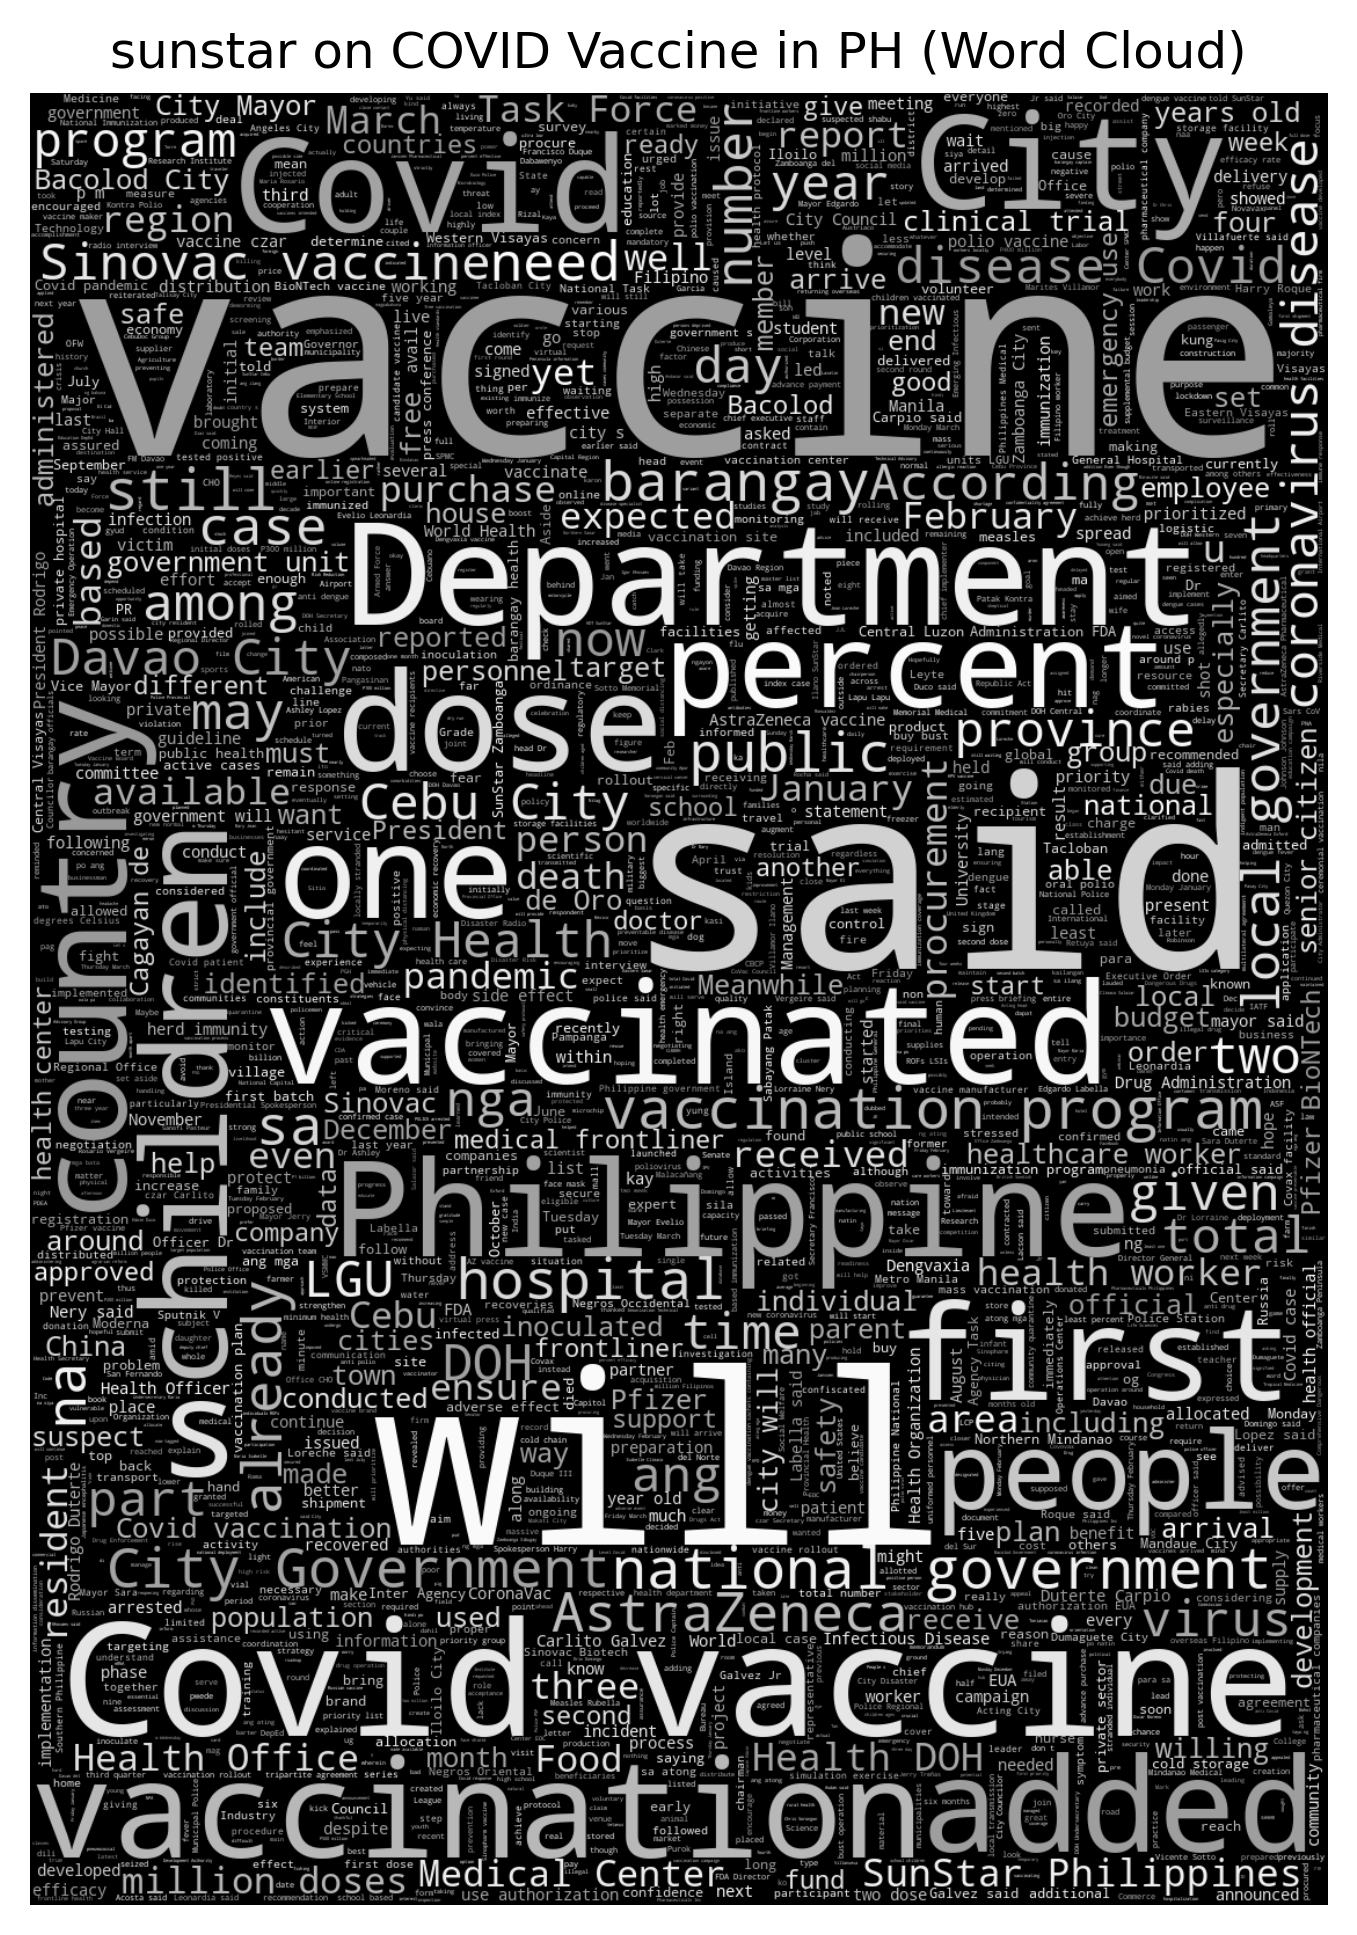

In [18]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % np.random.randint(60, 100)

mask = np.array(Image.open('bg.png'))

words = ' '.join(df['articles_content'].tolist())
wordcloud = WordCloud(background_color='black', max_words=2000, width=1024, height=720, mask=mask)
wordcloud.generate(words)

plt.figure(figsize=(20, 8), dpi=300)
plt.title('sunstar on COVID Vaccine in PH (Word Cloud)')
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42), interpolation='bilinear')
plt.axis('off')
plt.show()